In [1]:
!pip install scikeras

In [2]:
!pip install matplotlib

In [3]:
!pip install seaborn

In [4]:
!pip install statsmodels

In [5]:
!pip install tensorflow

In [6]:
!pip install openpyxl

In [7]:
!pip install optuna

In [8]:
!pip install xgboost

In [9]:
!pip install lightgbm

In [10]:
!pip install smogn

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
import lightgbm as lgb
import optuna
from smogn import smoter
from sklearn.preprocessing import PolynomialFeatures
import time
import traceback

C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
file_path = 'Общее_Агрегированные_данные_проценты.xlsx'

df = pd.read_excel(file_path)

# Анализ целевой переменной (оценка за интервалы)
target_column = "Оценка за интервал 100%"

In [11]:
# Тип данных каждого столбца
print(df.dtypes)

Полное имя пользователя                     object
Число входов в курс 25%                    float64
Число просмотров модулей 25%               float64
Число просмотров своих ошибок 25%          float64
Число просмотров полученных оценок 25%     float64
Количество выполненных заданий 25%         float64
Среднее время между заходами 25%           float64
Выполненные задания 25%                     object
Число входов в курс 33%                    float64
Число просмотров модулей 33%               float64
Число просмотров своих ошибок 33%          float64
Число просмотров полученных оценок 33%     float64
Количество выполненных заданий 33%         float64
Среднее время между заходами 33%           float64
Выполненные задания 33%                     object
Число входов в курс 50%                    float64
Число просмотров модулей 50%               float64
Число просмотров своих ошибок 50%          float64
Число просмотров полученных оценок 50%     float64
Количество выполненных заданий 

In [18]:
# Проверка дубликатов
print("\n=== Дубликаты ===")
print(f"Количество дубликатов: {df.duplicated().sum()}")


=== Дубликаты ===
Количество дубликатов: 0


In [19]:
 # Проверка пропусков
print("\n=== Пропуски ===")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
}).sort_values(by='Percentage (%)', ascending=False)
print(missing_data)


=== Пропуски ===
                                         Missing Values  Percentage (%)
Выполненные задания 25%                              23       13.609467
Выполненные задания 33%                              11        6.508876
Выполненные задания 50%                               8        4.733728
Выполненные задания 66%                               5        2.958580
Выполненные задания 100%                              3        1.775148
Полное имя пользователя                               0        0.000000
Число входов в курс 25%                               0        0.000000
Число просмотров своих ошибок 25%                     0        0.000000
Число просмотров модулей 25%                          0        0.000000
Число входов в курс 33%                               0        0.000000
Среднее время между заходами 25%                      0        0.000000
Количество выполненных заданий 25%                    0        0.000000
Число просмотров полученных оценок 25%        


=== Анализ целевой переменной ===

--- Оценка за интервал 100% ---
Минимум: 0.05528846153846154, Максимум: 10.625
Среднее: 6.69, Медиана: 6.96
Количество пропусков: 0


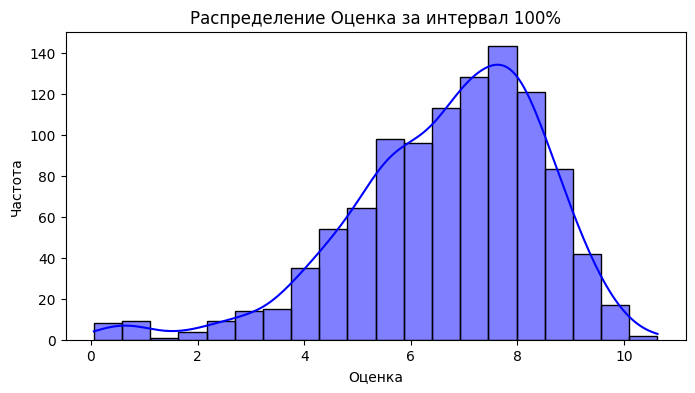

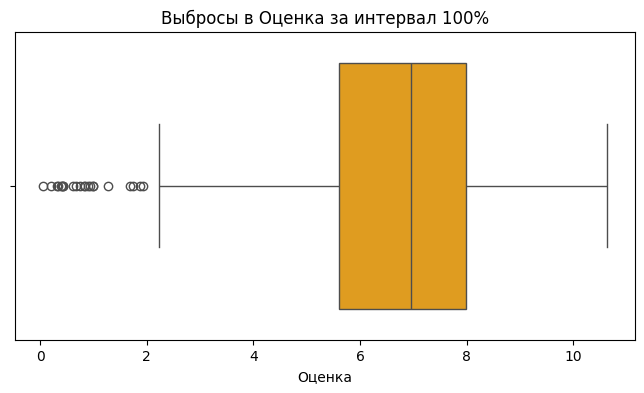

Количество выбросов: 22


In [100]:
print("\n=== Анализ целевой переменной ===")

print(f"\n--- {target_column} ---")
print(f"Минимум: {df[target_column].min()}, Максимум: {df[target_column].max()}")
print(f"Среднее: {df[target_column].mean():.2f}, Медиана: {df[target_column].median():.2f}")
print(f"Количество пропусков: {df[target_column].isnull().sum()}")

# Визуализация распределения
plt.figure(figsize=(8, 4))
sns.histplot(df[target_column], kde=True, bins=20, color='blue')
plt.title(f"Распределение {target_column}")
plt.xlabel("Оценка")
plt.ylabel("Частота")
plt.show()

# Проверка выбросов
plt.figure(figsize=(8, 4))
sns.boxplot(x=df[target_column], color='orange')
plt.title(f"Выбросы в {target_column}")
plt.xlabel("Оценка")
plt.show()

# Подсчет количества выбросов
q1 = df[target_column].quantile(0.25)
q3 = df[target_column].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df[(df[target_column] < lower_bound) | (df[target_column] > upper_bound)][target_column]
print(f"Количество выбросов: {outliers.count()}")


Признаки дисбаланса :
- Асимметрия (skewness) > 1 или < -1.
- Много выбросов (см. ящик с усами).
- Редкие значения в хвостах распределения.  
  
Логарифмическое преобразование или стандартизация могут помочь уменьшить влияние дисбаланса. Если редкие значения составляют >10% данных или сильно влияют на качество модели, примените методы вроде SMOGN.

In [101]:
# Статистика
print(f"Асимметрия (skewness): {skew(df[target_column], nan_policy='omit'):.2f}")
print(f"Эксцесс (kurtosis): {kurtosis(df[target_column], nan_policy='omit'):.2f}")

Асимметрия (skewness): -0.87
Эксцесс (kurtosis): 1.07


Графики сравнения распределений предикторов в разные периоды позволяют:

Понять, как меняется поведение студентов по мере продвижения курса.
Выявить тренды (например, увеличение или уменьшение активности).

2. Пример интерпретации для конкретного предиктора  
Пример 1: "Число входов в курс"  
Наблюдаемые изменения : Распределение числа входов в курс смещается влево по мере продвижения курса. Это может свидетельствовать о том, что студенты становятся менее активными на поздних этапах.  
Причины : Возможно, студенты теряют мотивацию или фокусируются только на выполнении заданий, а не на просмотре материалов.  
Вывод : На ранних этапах (например, 25%) активность входа в курс является важным предиктором, так как она отражает начальную вовлеченность студентов. На поздних этапах этот признак может быть менее значимым.  
Пример 2: "Количество выполненных заданий"  
Наблюдаемые изменения : Распределение количества выполненных заданий становится более смещенным вправо (увеличивается среднее значение) по мере продвижения курса.  
Причины : Студенты начинают выполнять больше заданий на поздних этапах, возможно, из-за приближения дедлайнов или осознания важности этих заданий для итоговой оценки.  
Вывод : Количество выполненных заданий становится ключевым предиктором на поздних этапах (например, 80%), так как оно напрямую связано с успеваемостью.
Пример 3: "Среднее время между заходами"    
Наблюдаемые изменения : Распределение среднего времени между заходами становится более растянутым (увеличивается разброс значений).  
Причины : Некоторые студенты начинают заходить реже, возможно, из-за потери интереса или перегрузки, в то время как другие остаются активными.  
Вывод : Этот признак может быть полезен для выявления групп риска (студентов с длительными перерывами).  
  
3. Общие выводы из графиков    
Тренды активности :
На ранних этапах курса (например, 25%) студенты демонстрируют высокую активность (частые входы, просмотры модулей), но она постепенно снижается.  
На поздних этапах (например, 80%) активность становится более целенаправленной (выполнение заданий, просмотр ошибок).  
Динамика предикторов :  
Некоторые предикторы (например, "Число входов в курс") теряют свою значимость на поздних этапах.  
Другие предикторы (например, "Количество выполненных заданий") становятся более важными.  

4. Текст для дипломной работы
"Анализ распределений предикторов в разные периоды показал, что поведение студентов изменяется по мере продвижения курса. На ранних этапах (25%) наблюдается высокая активность входа в курс и просмотра материалов, что может быть связано с начальной мотивацией студентов. Однако к поздним этапам (80%) активность входа снижается, а количество выполненных заданий, напротив, возрастает. Это подтверждает гипотезу о том, что студенты фокусируются на выполнении заданий на поздних этапах, особенно при приближении дедлайнов. Таким образом, для прогнозирования оценок на ранних этапах важно учитывать такие предикторы, как 'Число входов в курс', тогда как на поздних этапах ключевыми становятся 'Количество выполненных заданий' и 'Оцененные задания'."


=== Анализ числовых признаков ===

--- Число входов в курс 25% ---


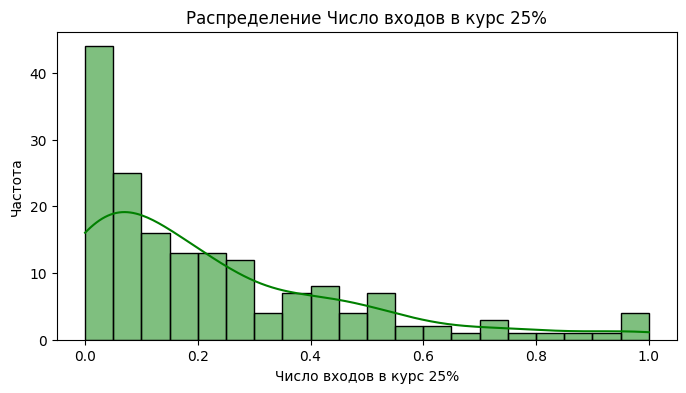

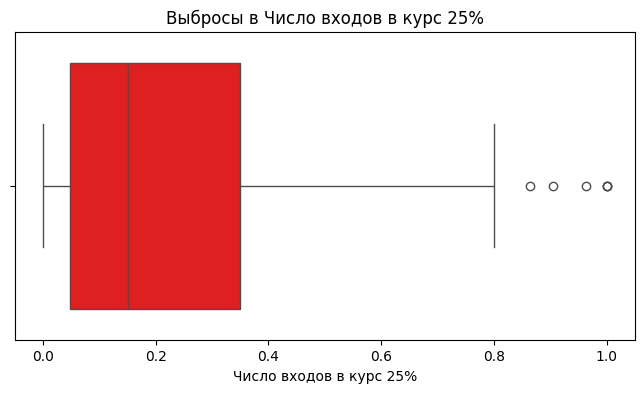


--- Число просмотров модулей 25% ---


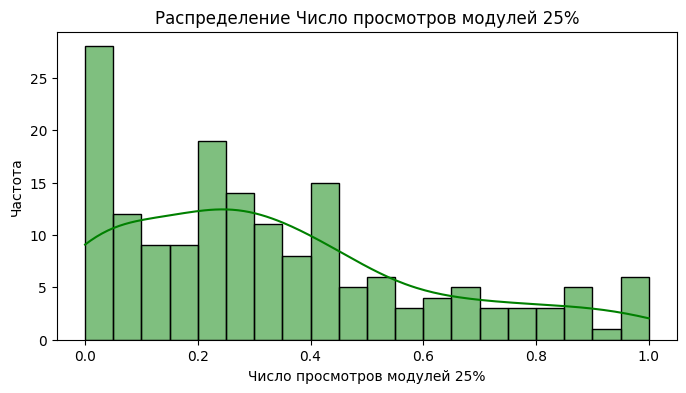

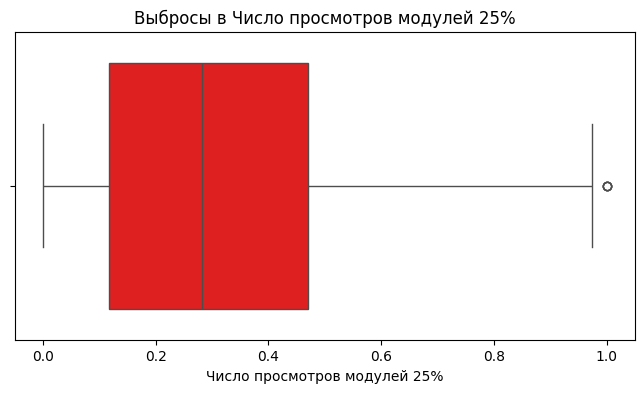


--- Число просмотров своих ошибок 25% ---


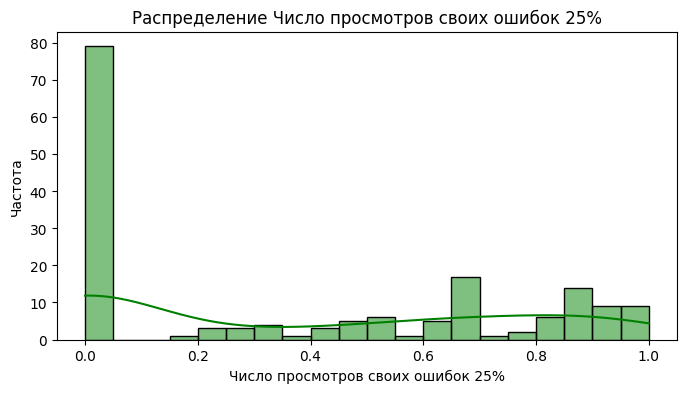

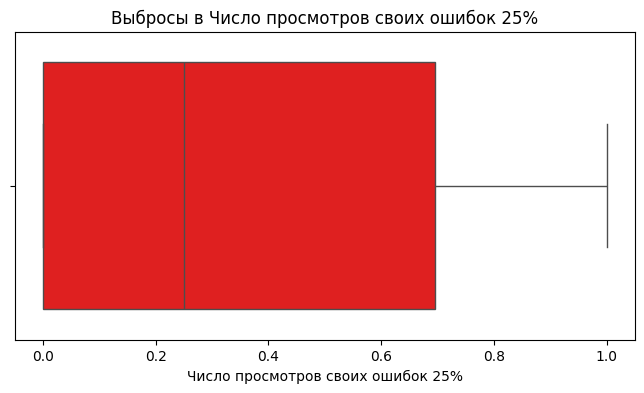


--- Число просмотров полученных оценок 25% ---


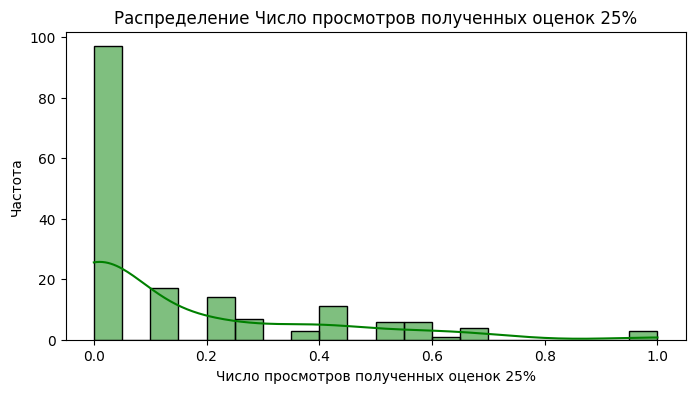

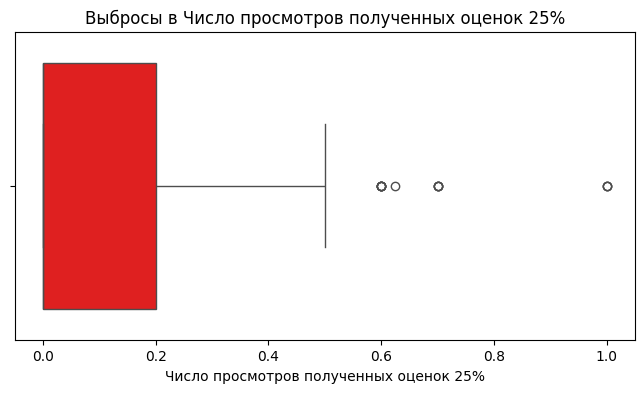


--- Количество выполненных заданий 25% ---


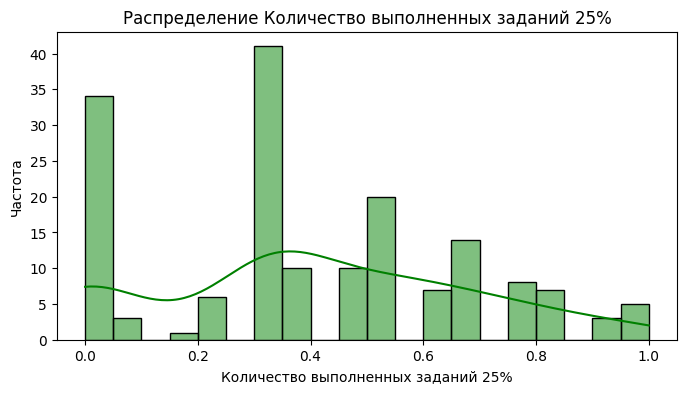

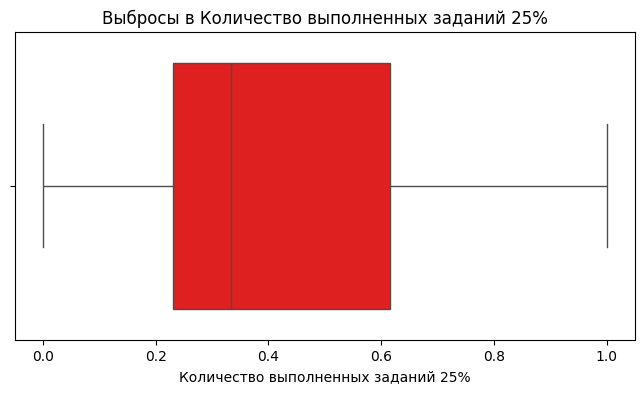


--- Среднее время между заходами 25% ---


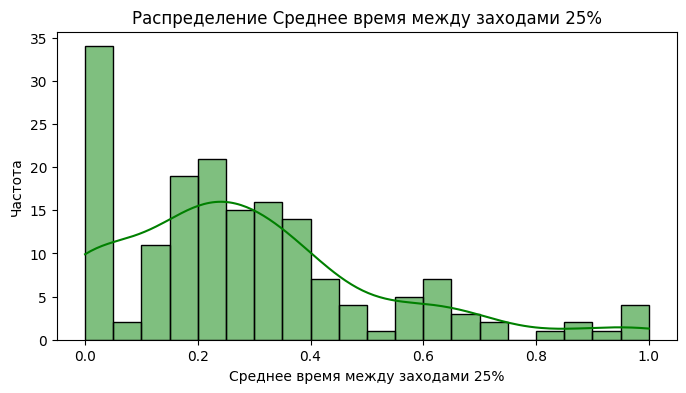

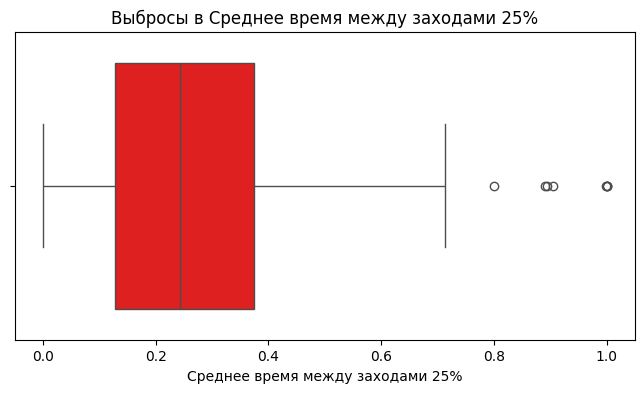


--- Число входов в курс 33% ---


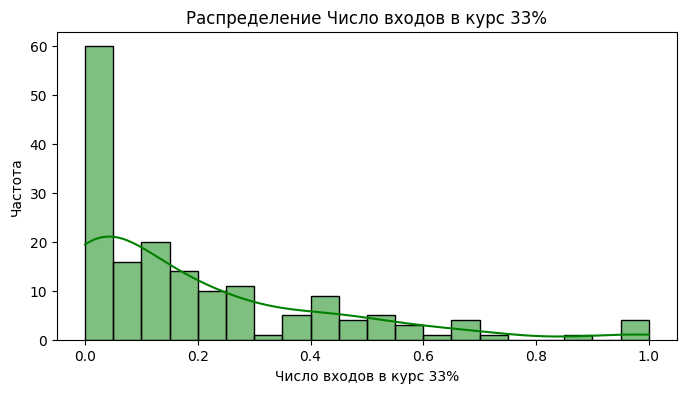

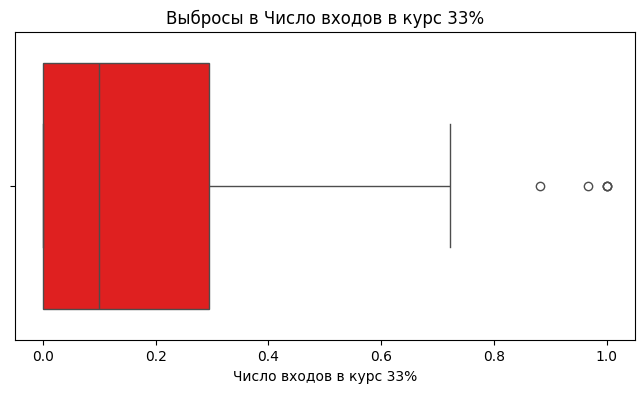


--- Число просмотров модулей 33% ---


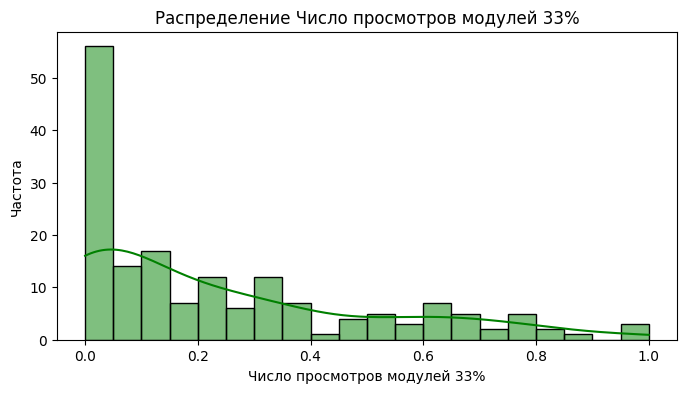

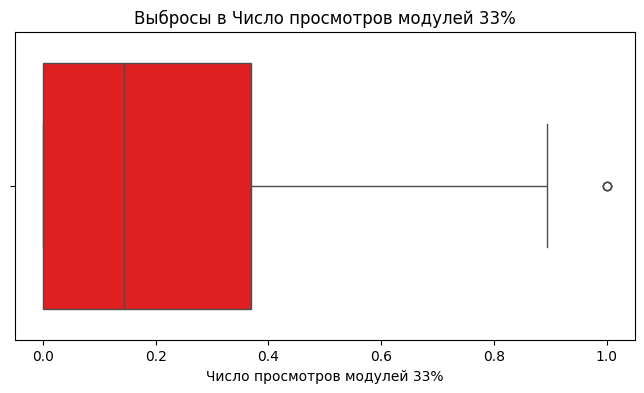


--- Число просмотров своих ошибок 33% ---


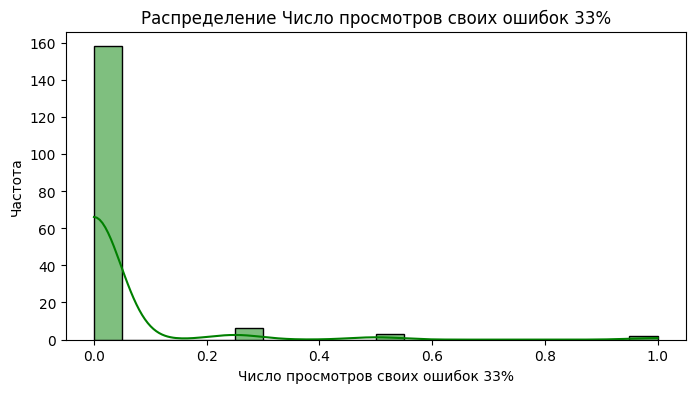

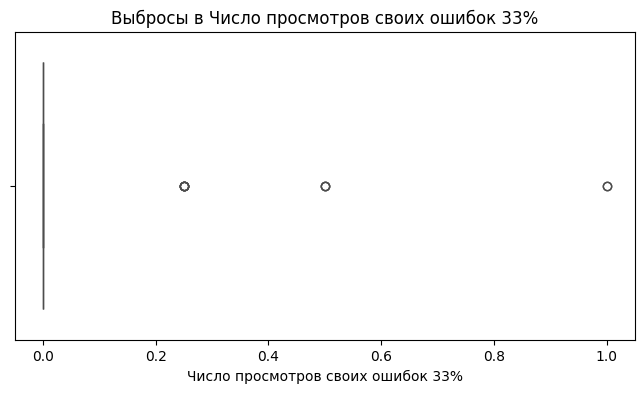


--- Число просмотров полученных оценок 33% ---


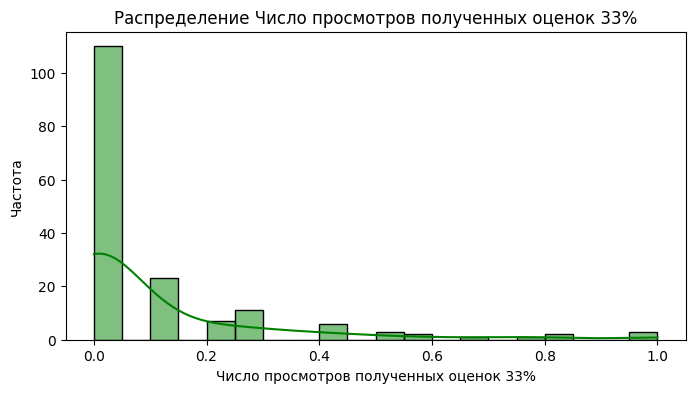

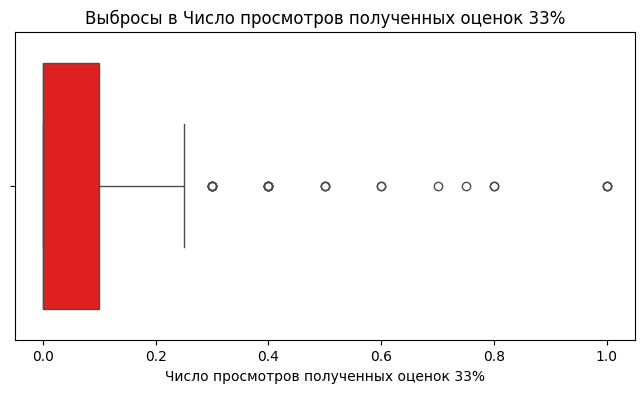


--- Количество выполненных заданий 33% ---


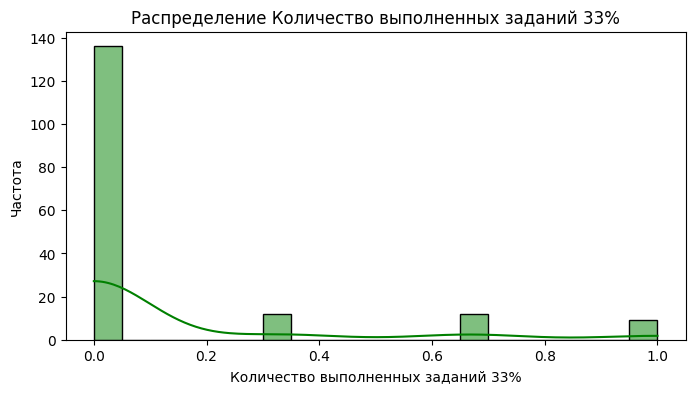

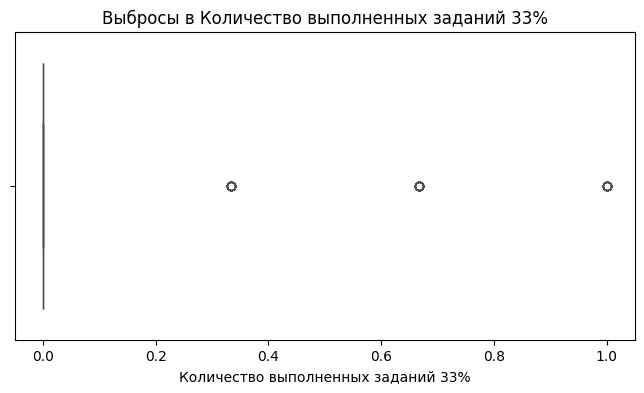


--- Среднее время между заходами 33% ---


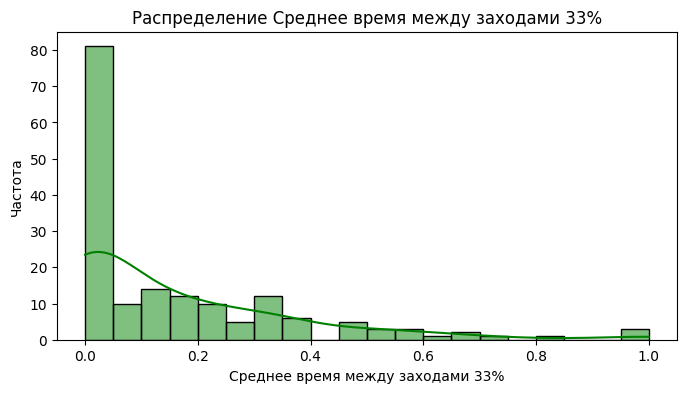

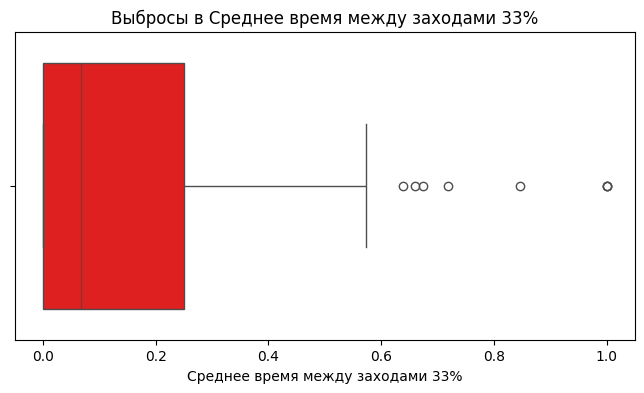


--- Число входов в курс 50% ---


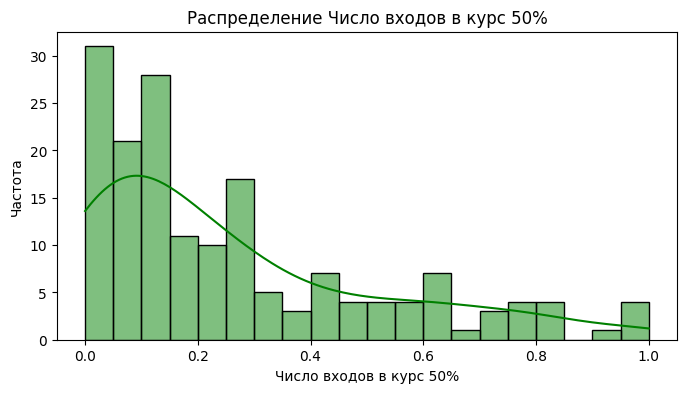

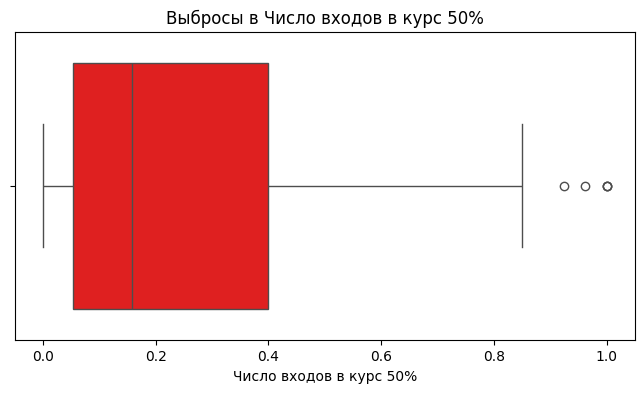


--- Число просмотров модулей 50% ---


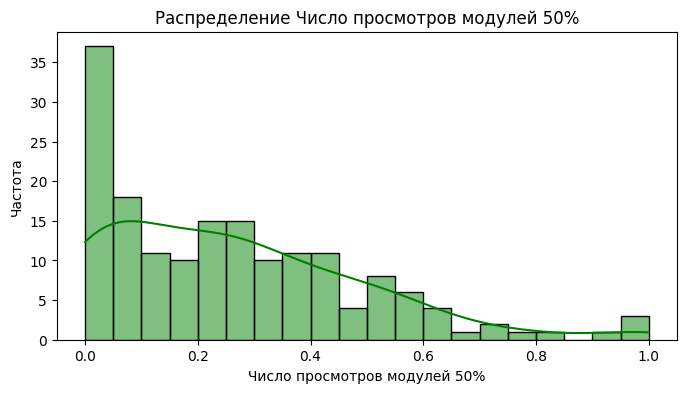

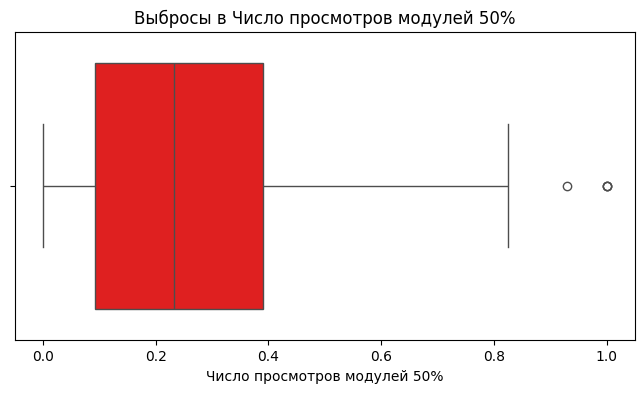


--- Число просмотров своих ошибок 50% ---


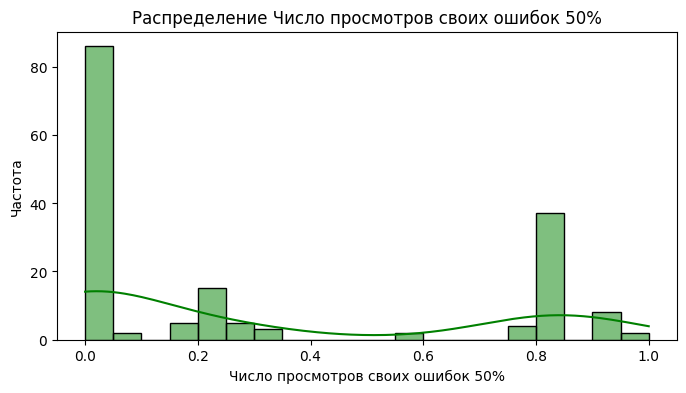

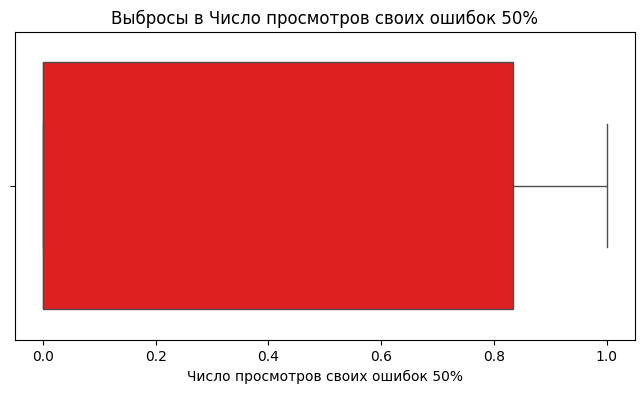


--- Число просмотров полученных оценок 50% ---


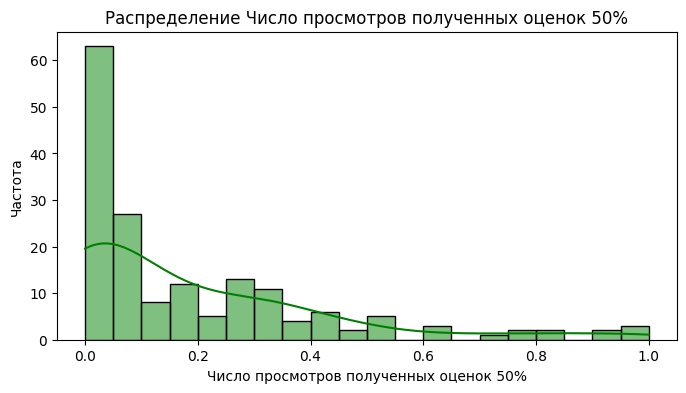

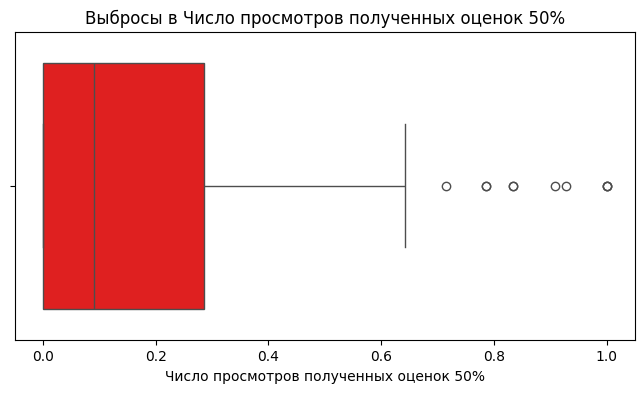


--- Количество выполненных заданий 50% ---


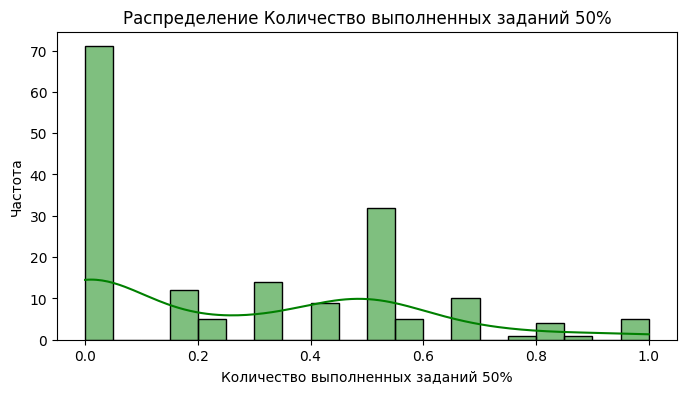

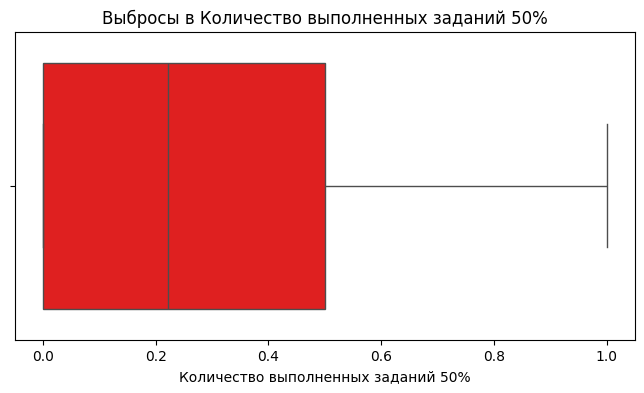


--- Среднее время между заходами 50% ---


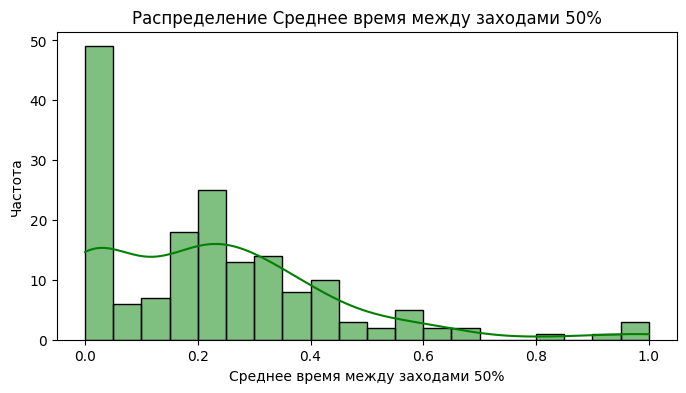

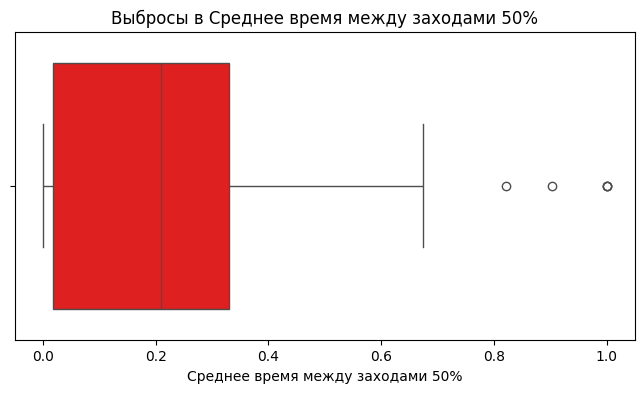


--- Число входов в курс 66% ---


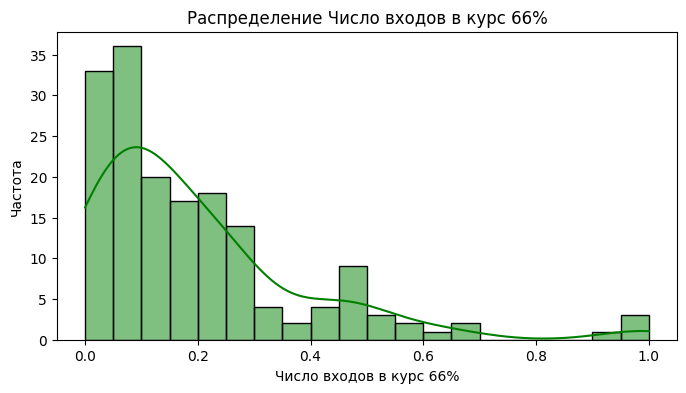

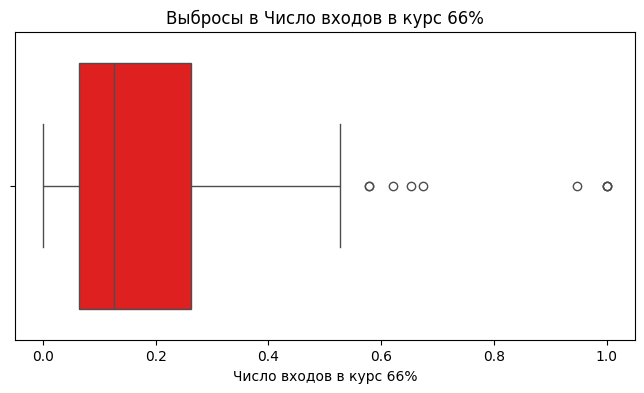


--- Число просмотров модулей 66% ---


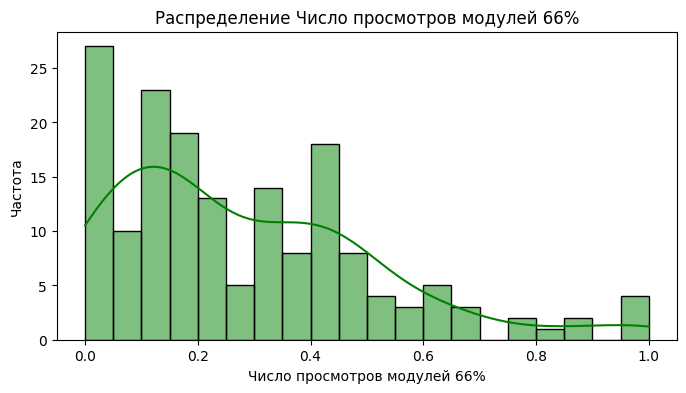

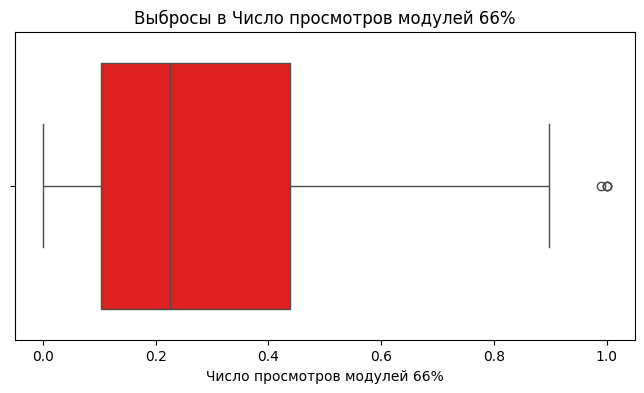


--- Число просмотров своих ошибок 66% ---


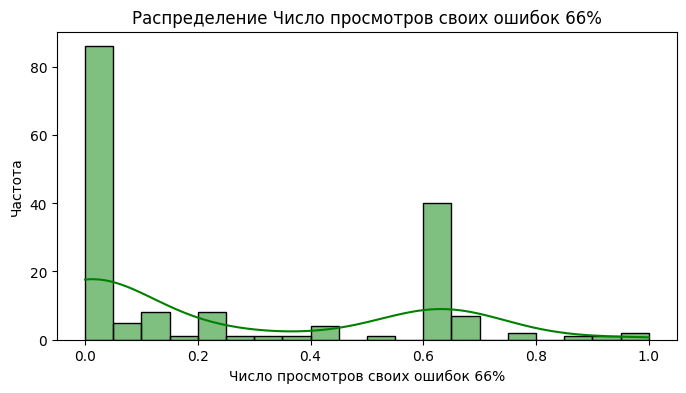

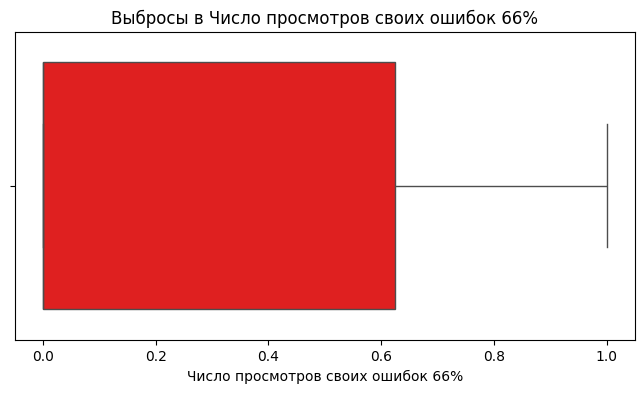


--- Число просмотров полученных оценок 66% ---


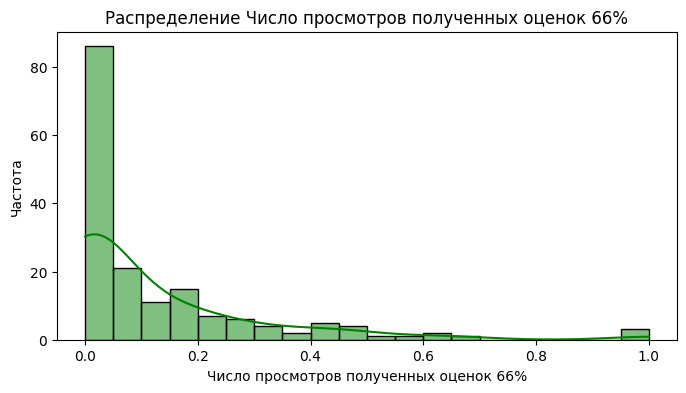

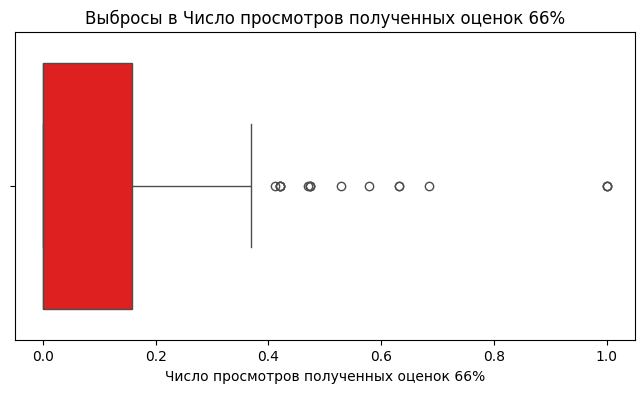


--- Количество выполненных заданий 66% ---


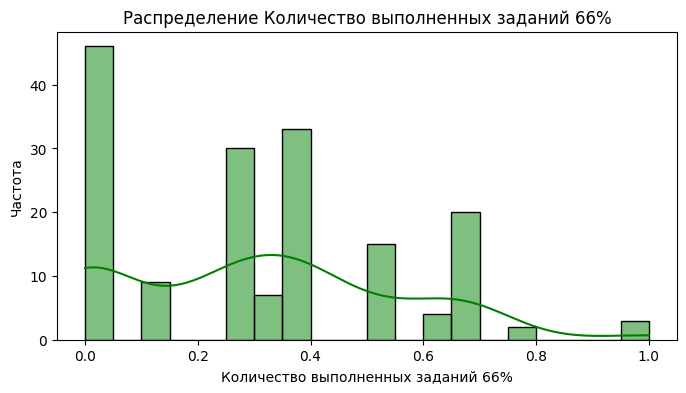

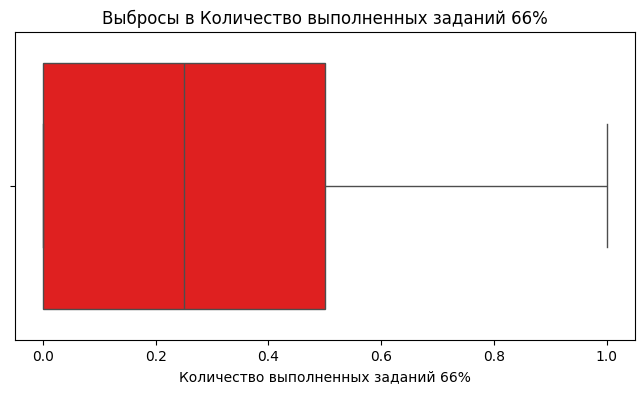


--- Среднее время между заходами 66% ---


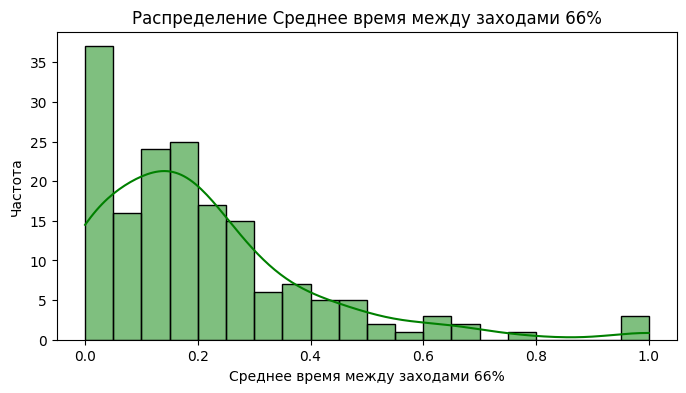

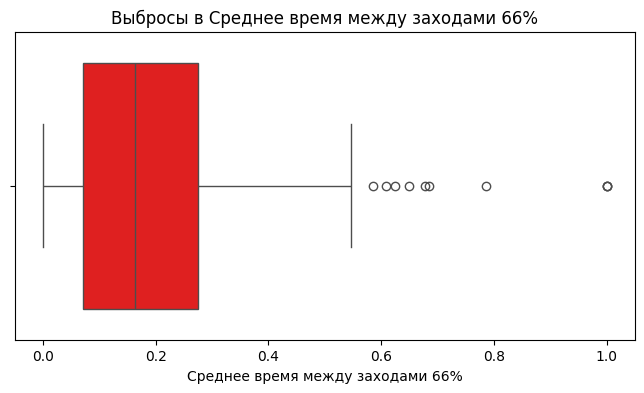


--- Число входов в курс 100% ---


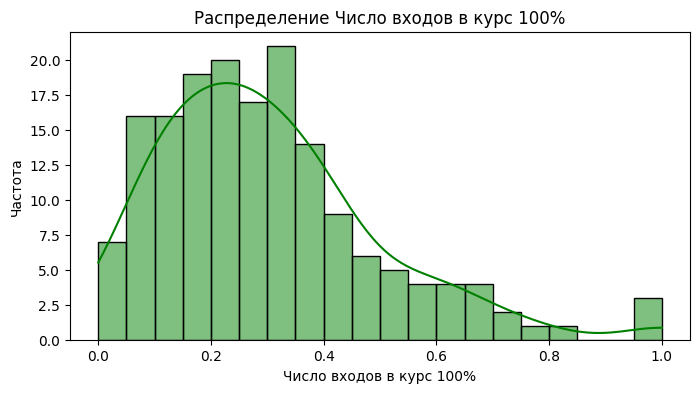

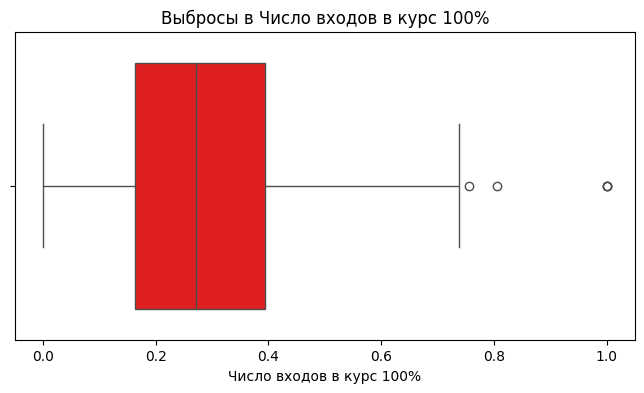


--- Число просмотров модулей 100% ---


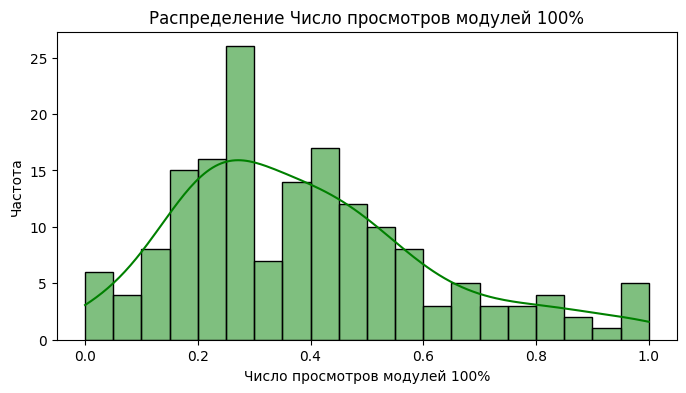

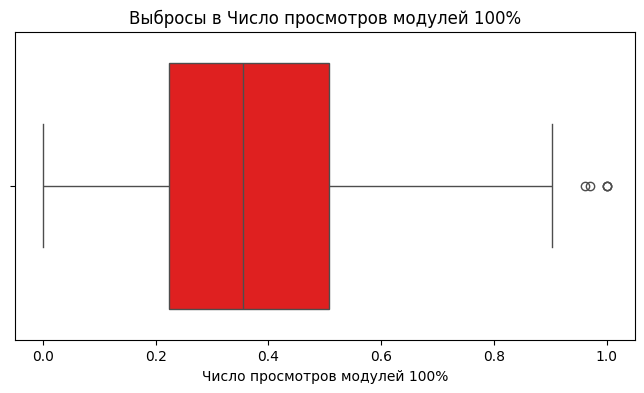


--- Число просмотров своих ошибок 100% ---


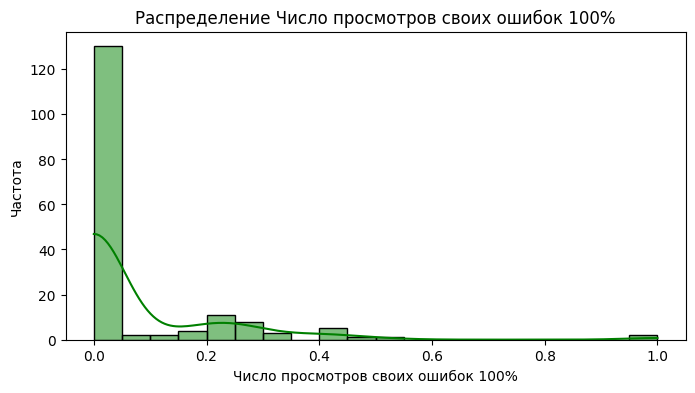

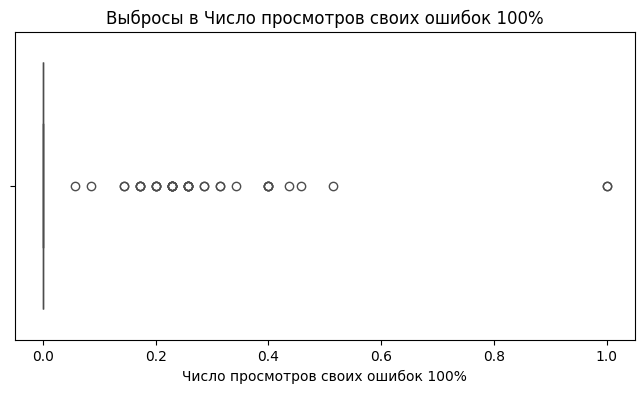


--- Число просмотров полученных оценок 100% ---


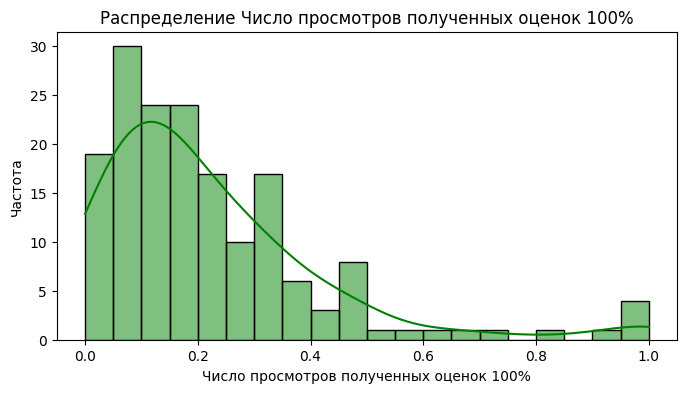

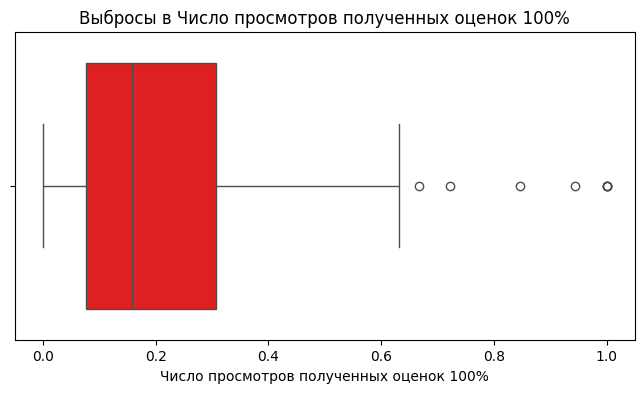


--- Количество выполненных заданий 100% ---


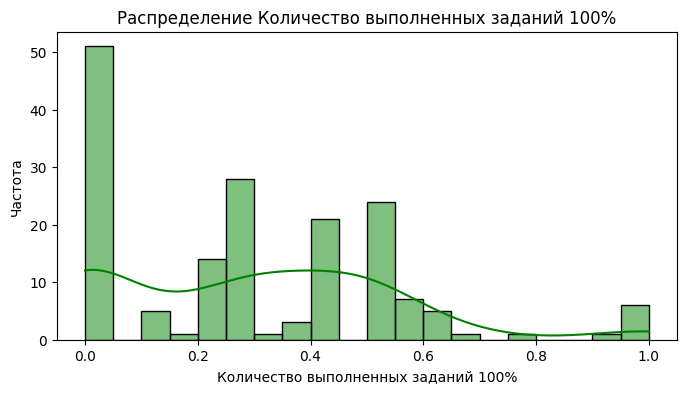

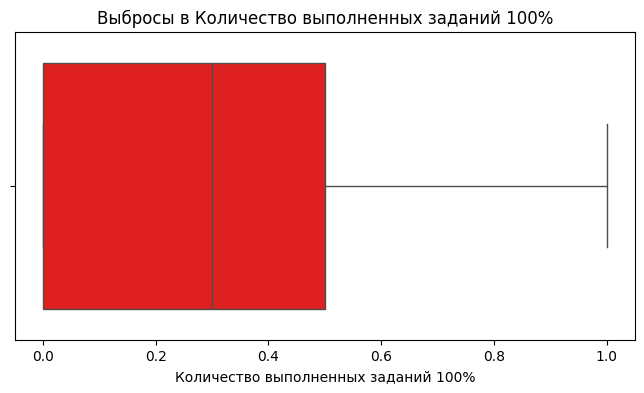


--- Среднее время между заходами 100% ---


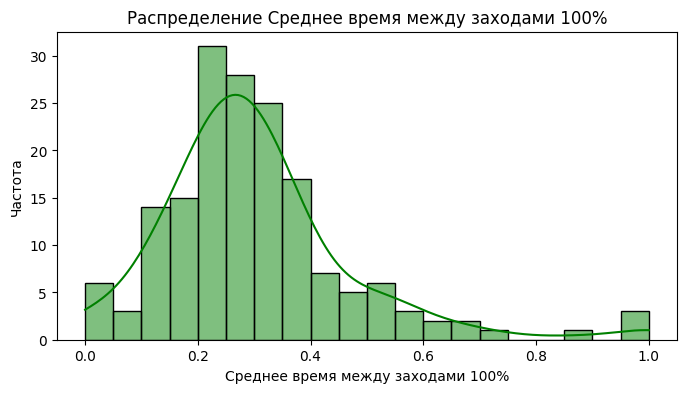

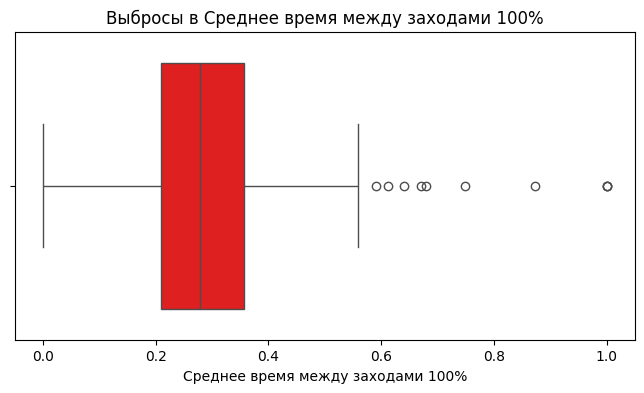


--- Оценка за интервал 25% ---


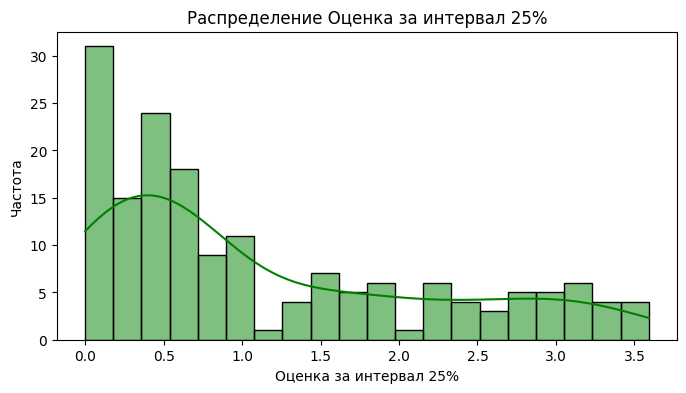

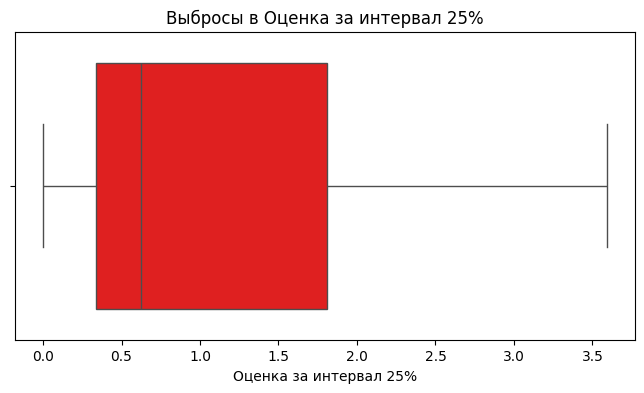


--- Оценка за интервал 33% ---


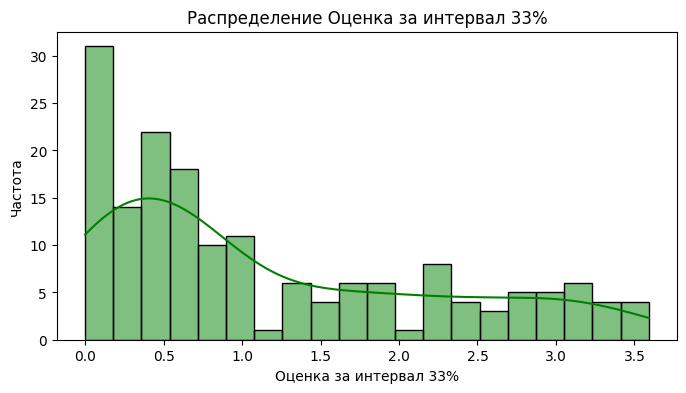

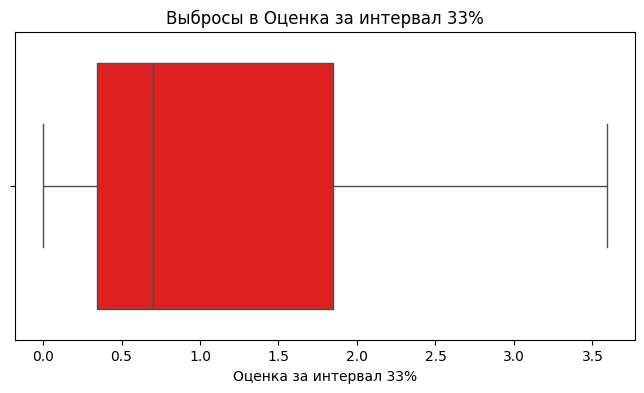


--- Оценка за интервал 50% ---


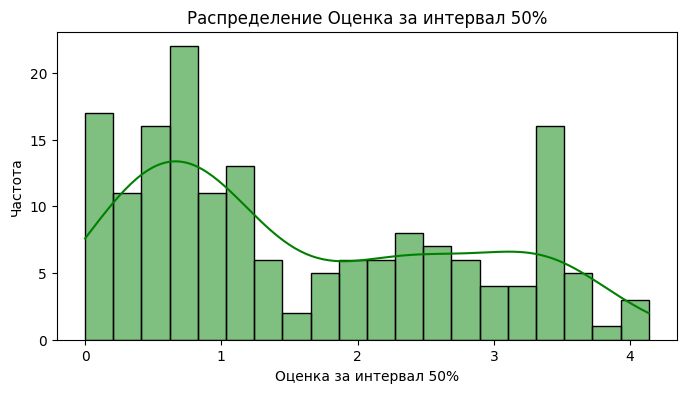

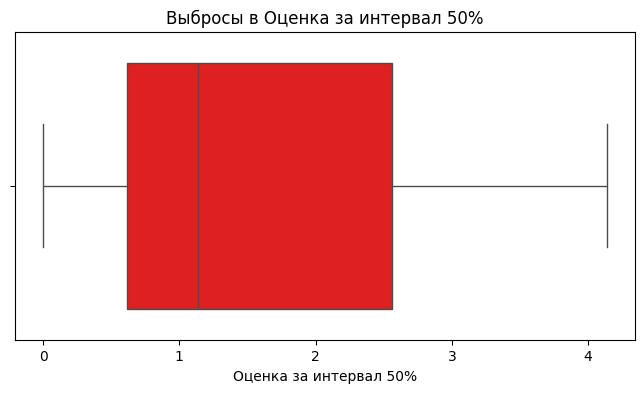


--- Оценка за интервал 66% ---


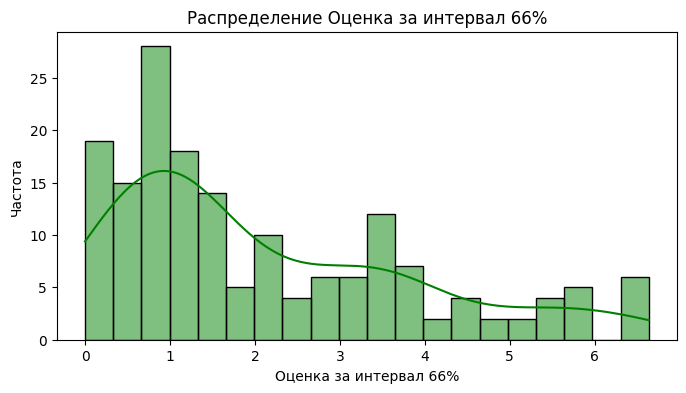

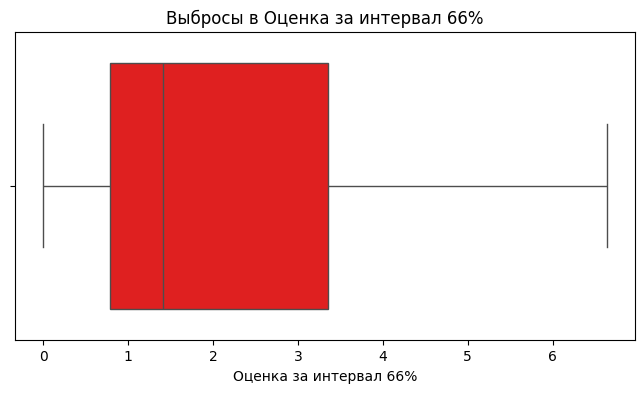


--- Оценка за интервал 100% ---


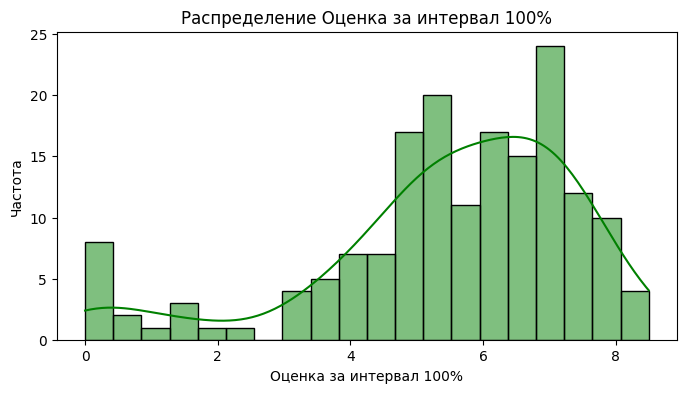

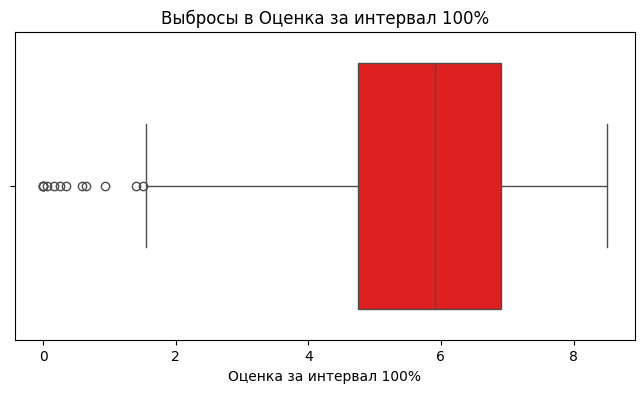

In [22]:
# Анализ числовых признаков
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\n=== Анализ числовых признаков ===")
for col in numerical_columns:
    print(f"\n--- {col} ---")

    # Визуализация распределения
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=20, color='green')
    plt.title(f"Распределение {col}")
    plt.xlabel(col)
    plt.ylabel("Частота")
    plt.show()

    # Проверка выбросов
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], color='red')
    plt.title(f"Выбросы в {col}")
    plt.xlabel(col)
    plt.show()

Пропусков в исследовании нет, данные берутся с логов и с таблицы оценок

Далее удалим выбросы у целевой переменной. Удалим для них, так как у кого меньше 4, они скорее всего отчисляются или уходят в академ. Для предикторов удалять не будем, так как эти данные важны, и выбросы будем устранять другим путем

In [13]:
# Вычисление квартилей
Q1 = df[target_column].quantile(0.25)  # Первый квартиль (25%)
Q3 = df[target_column].quantile(0.75)  # Третий квартиль (75%)
IQR = Q3 - Q1  # Межквартильный размах

# Определение границ для выбросов
lower_bound = Q1 - 1.5 * IQR  # Нижняя граница
upper_bound = Q3 + 1.5 * IQR  # Верхняя граница

print(f"Нижняя граница: {lower_bound:.2f}, Верхняя граница: {upper_bound:.2f}")

# Фильтрация данных (удаление выбросов)
df_cleaned = df[(df[target_column] >= lower_bound) & (df[target_column] <= upper_bound)]

# Сохранение очищенной целевой переменной
Y_clean = df_cleaned[target_column]

# Вывод результатов
print(f"Исходное количество строк: {len(df)}")
print(f"Количество строк после удаления выбросов: {len(df_cleaned)}")
print(f"Количество удалённых выбросов: {len(df) - len(df_cleaned)}")

Нижняя граница: 2.02, Верхняя граница: 11.56
Исходное количество строк: 1056
Количество строк после удаления выбросов: 1034
Количество удалённых выбросов: 22


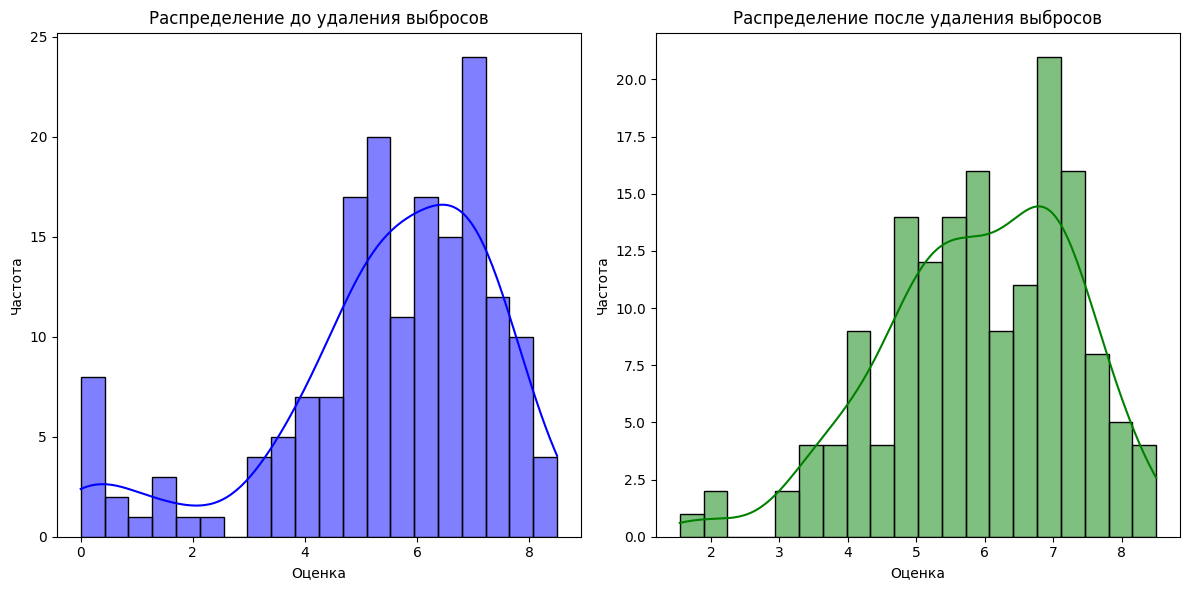

In [25]:
# График до удаления выбросов
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[target_column], bins=20, kde=True, color='blue')
plt.title("Распределение до удаления выбросов")
plt.xlabel("Оценка")
plt.ylabel("Частота")

# График после удаления выбросов
plt.subplot(1, 2, 2)
sns.histplot(Y_clean, bins=20, kde=True, color='green')
plt.title("Распределение после удаления выбросов")
plt.xlabel("Оценка")
plt.ylabel("Частота")

plt.tight_layout()
plt.show()


=== Анализ числовых признаков ===

--- Число входов в курс 25% ---


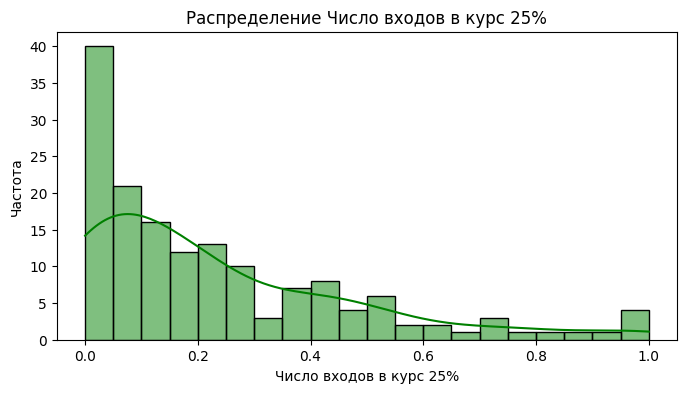

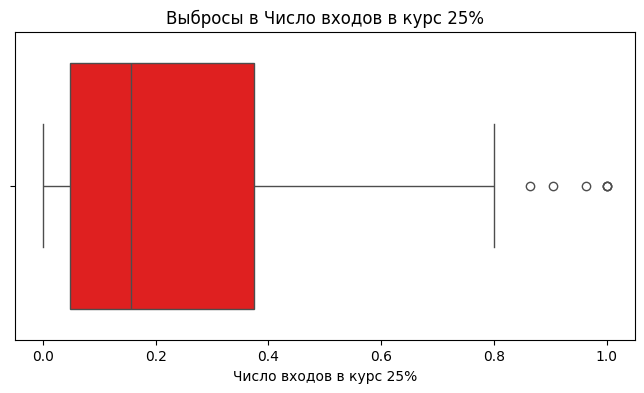


--- Число просмотров модулей 25% ---


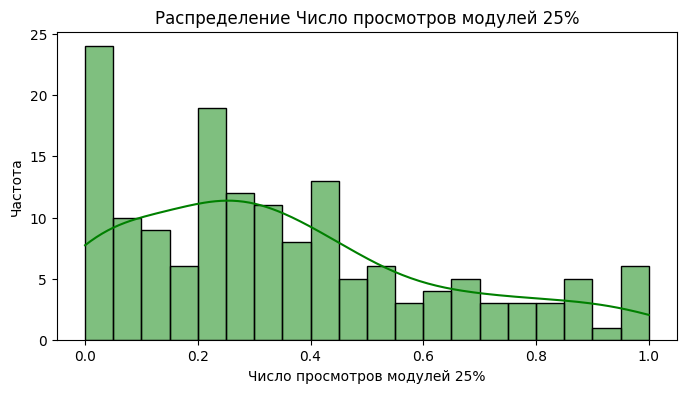

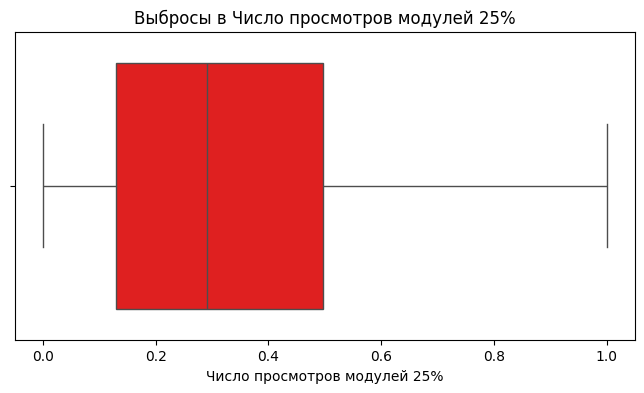


--- Число просмотров своих ошибок 25% ---


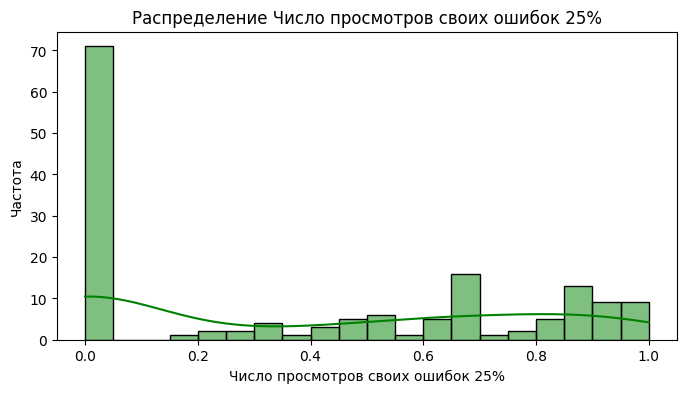

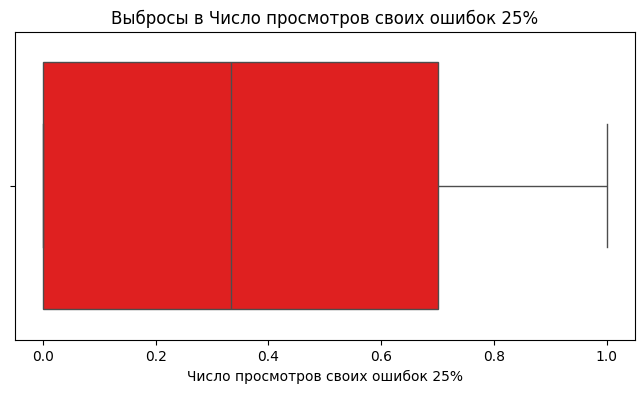


--- Число просмотров полученных оценок 25% ---


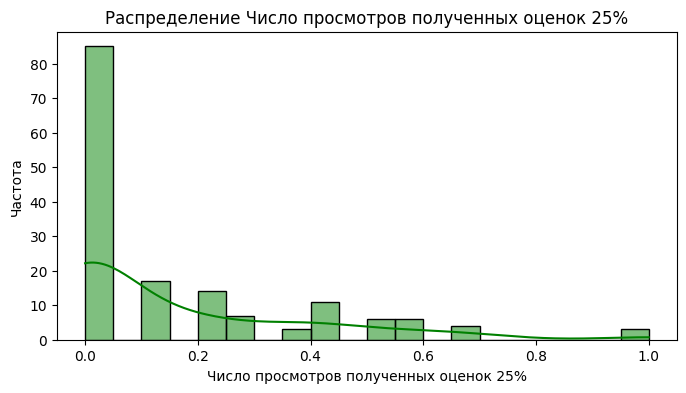

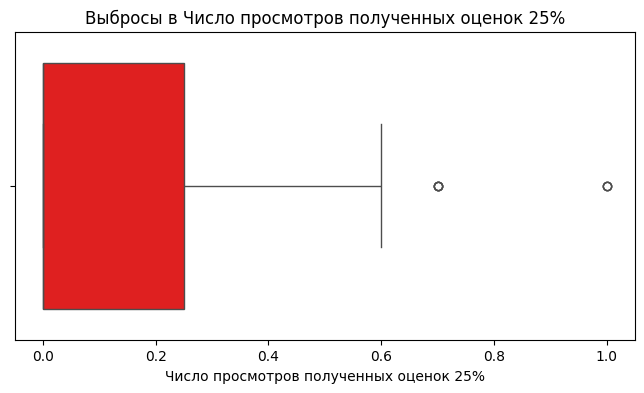


--- Количество выполненных заданий 25% ---


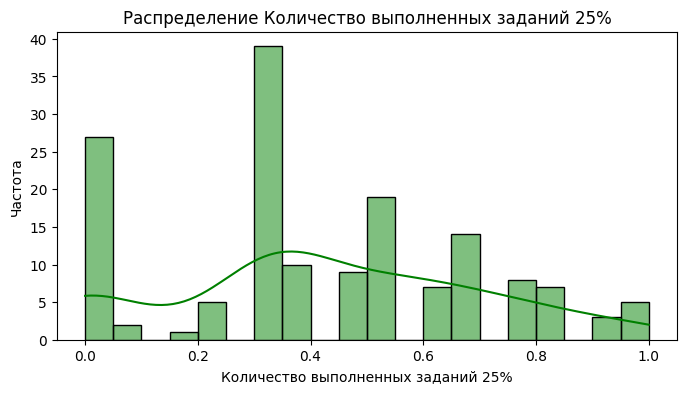

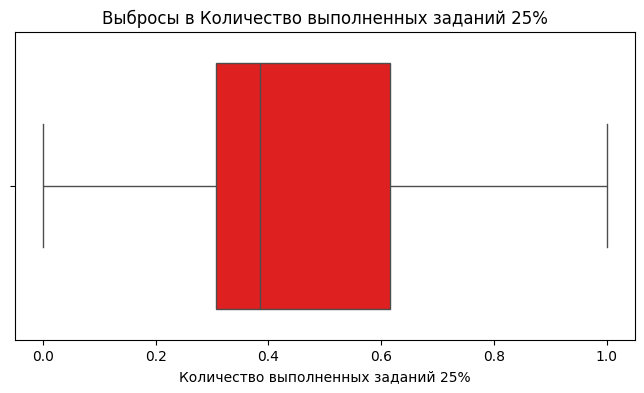


--- Среднее время между заходами 25% ---


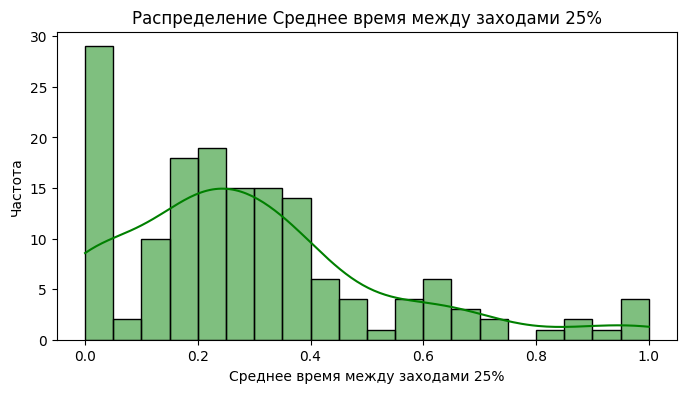

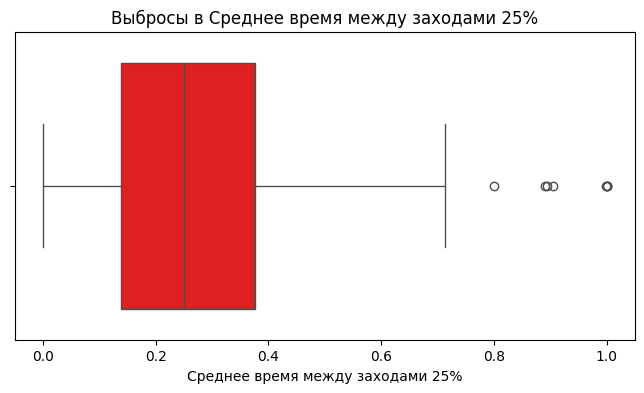


--- Число входов в курс 33% ---


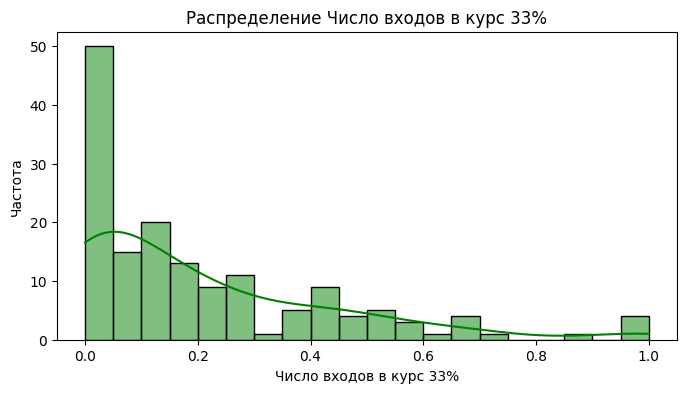

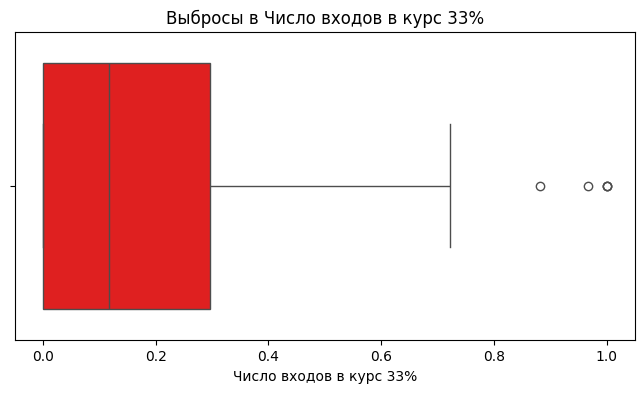


--- Число просмотров модулей 33% ---


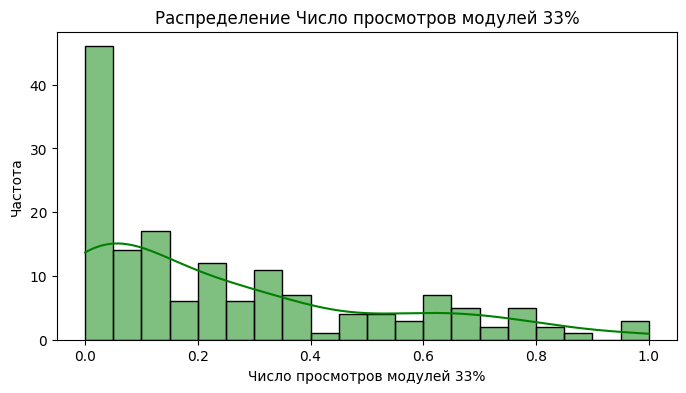

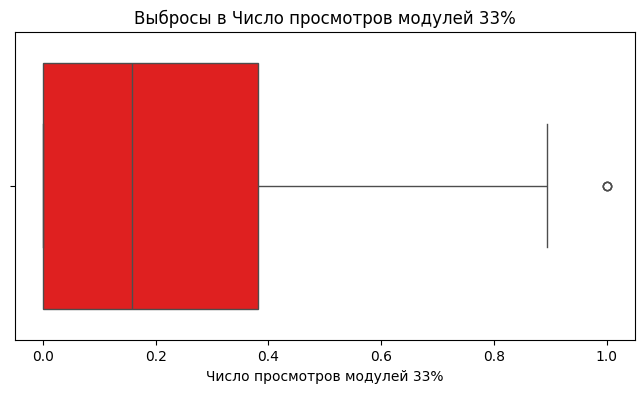


--- Число просмотров своих ошибок 33% ---


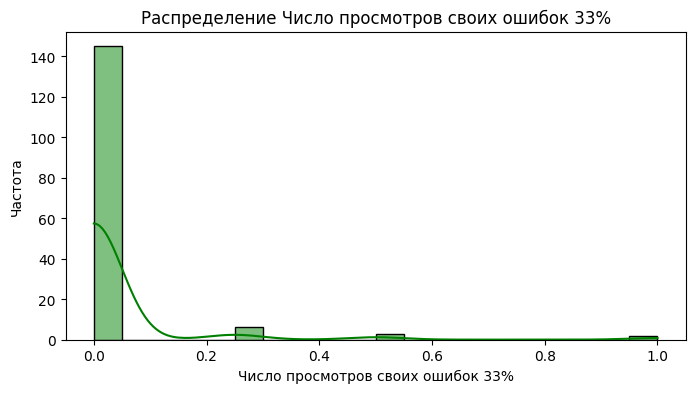

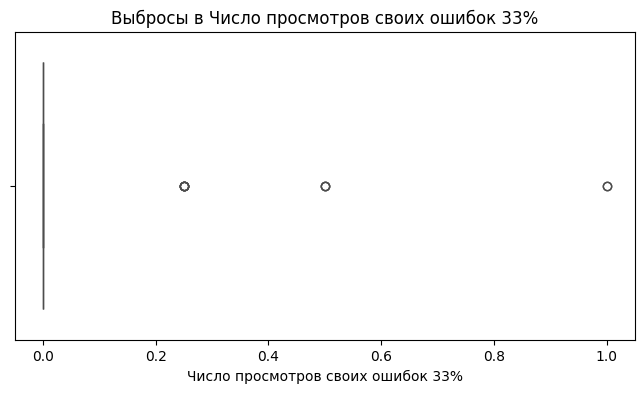


--- Число просмотров полученных оценок 33% ---


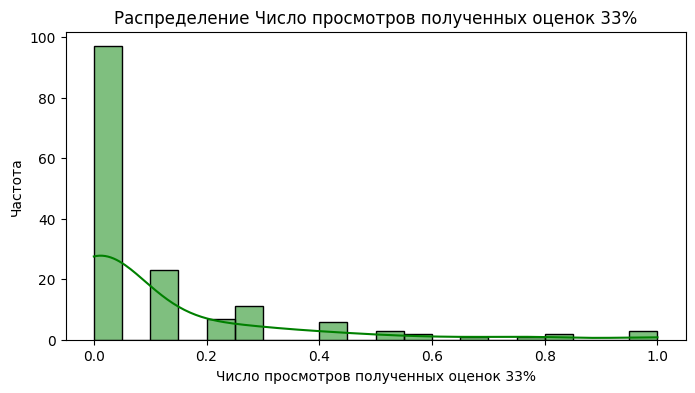

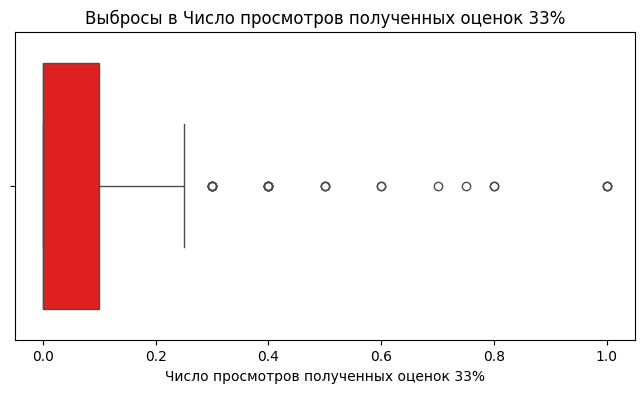


--- Количество выполненных заданий 33% ---


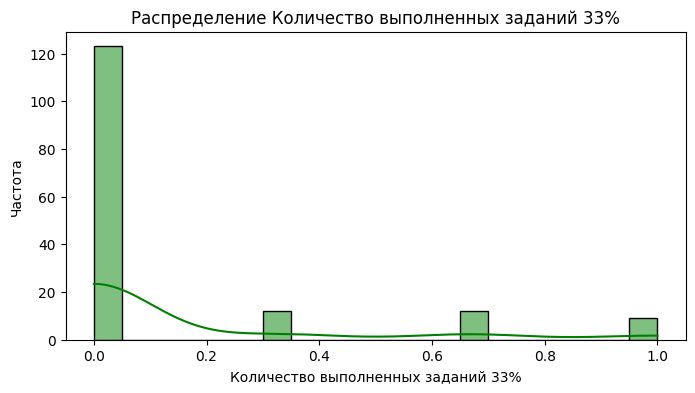

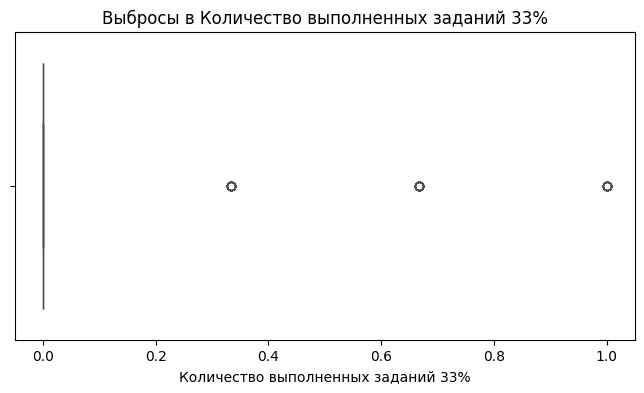


--- Среднее время между заходами 33% ---


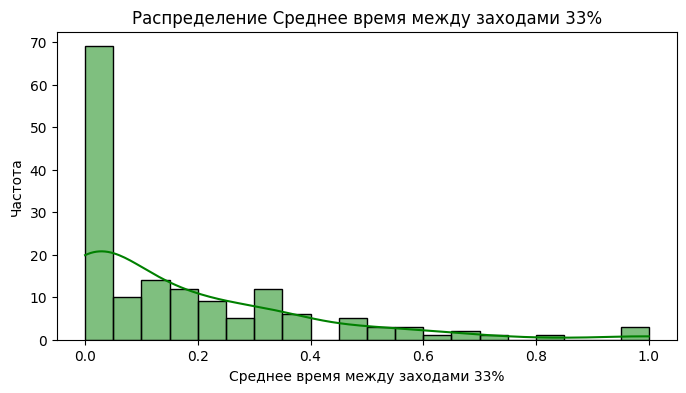

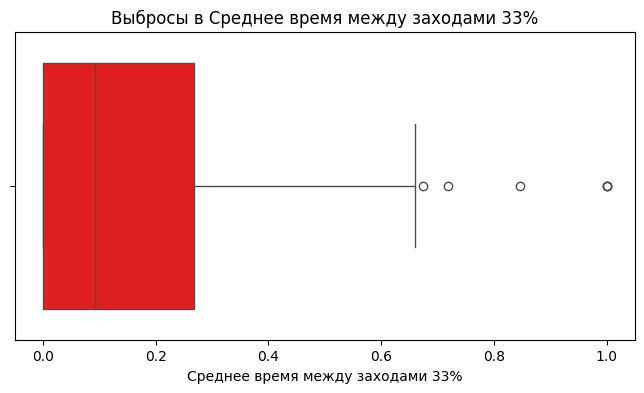


--- Число входов в курс 50% ---


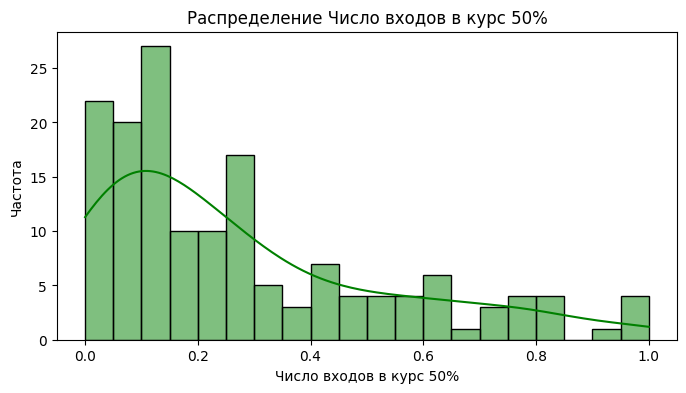

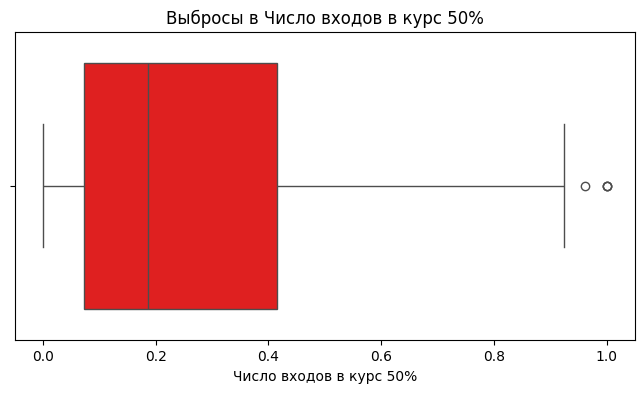


--- Число просмотров модулей 50% ---


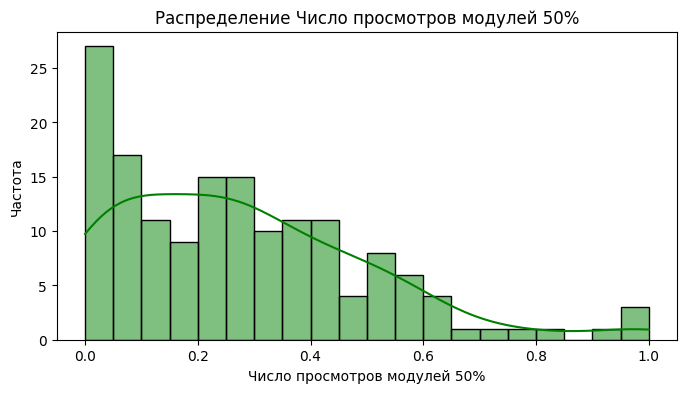

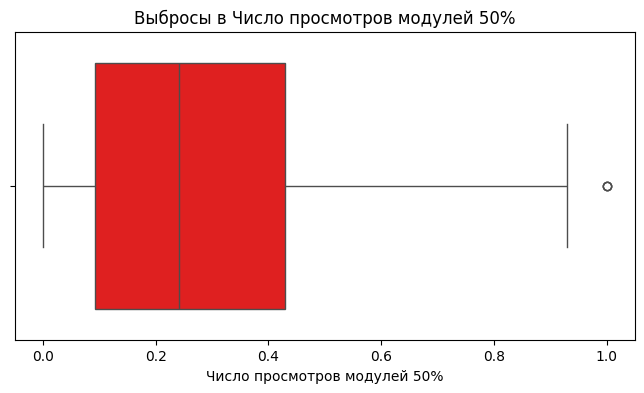


--- Число просмотров своих ошибок 50% ---


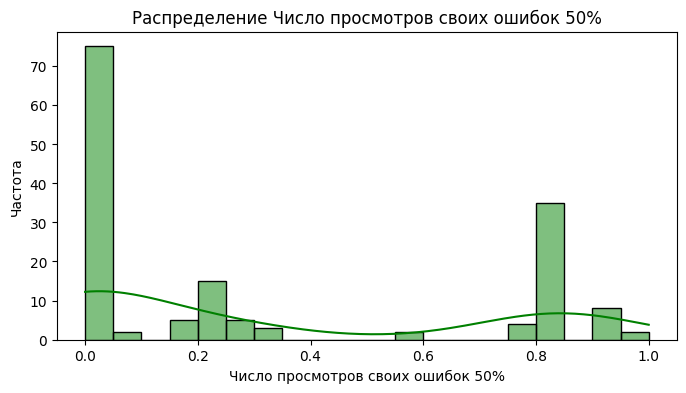

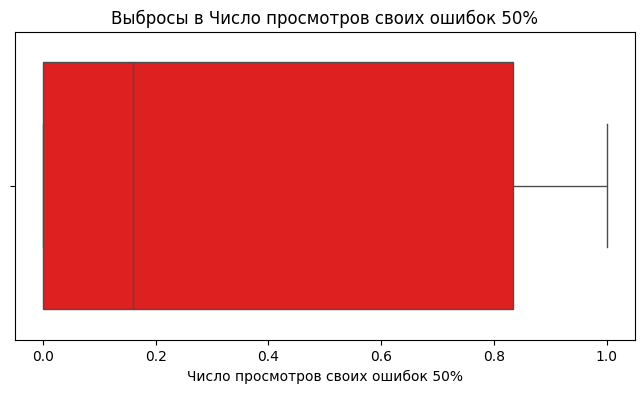


--- Число просмотров полученных оценок 50% ---


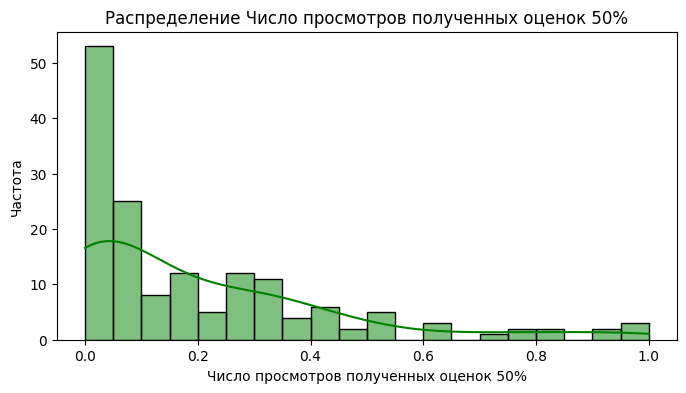

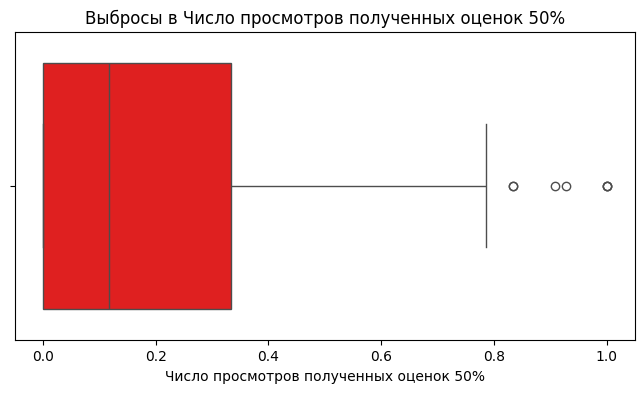


--- Количество выполненных заданий 50% ---


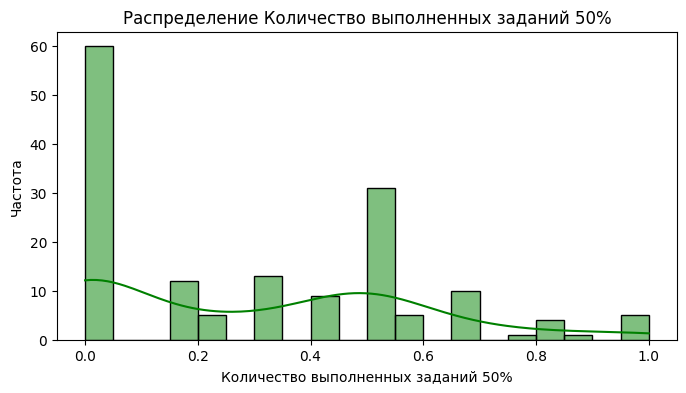

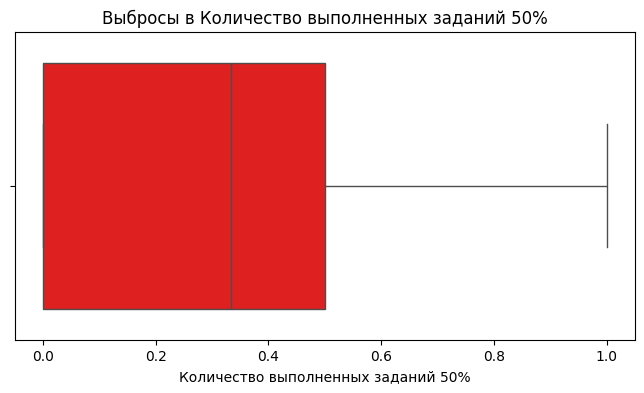


--- Среднее время между заходами 50% ---


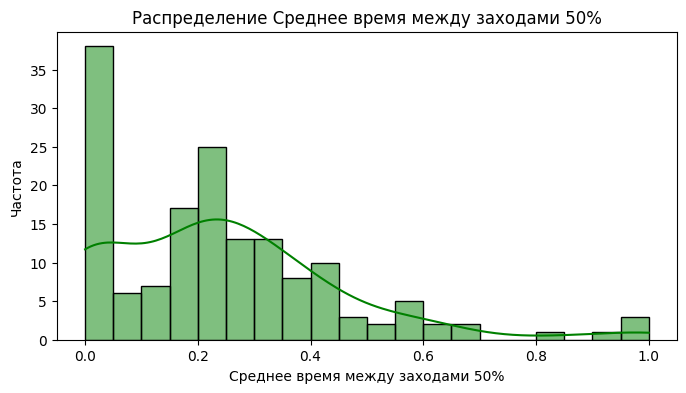

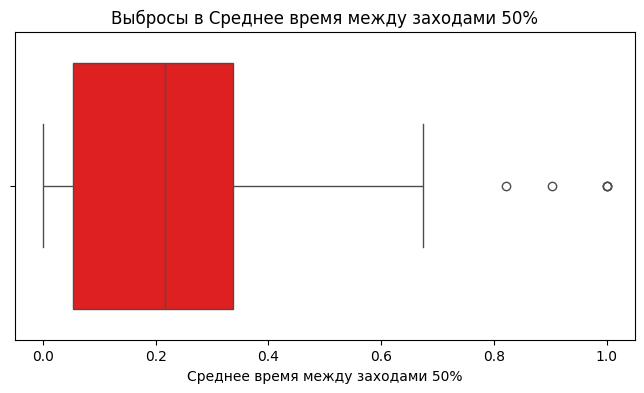


--- Число входов в курс 66% ---


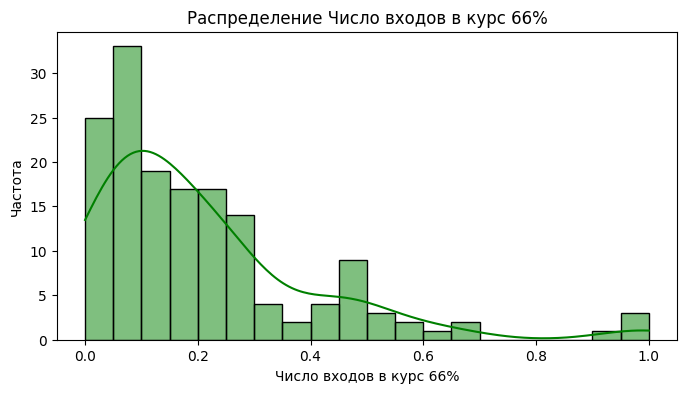

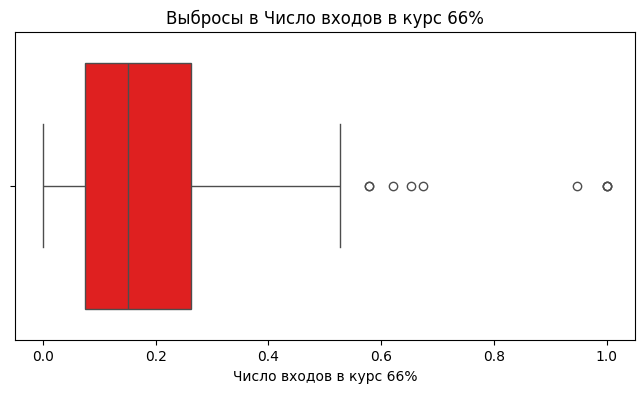


--- Число просмотров модулей 66% ---


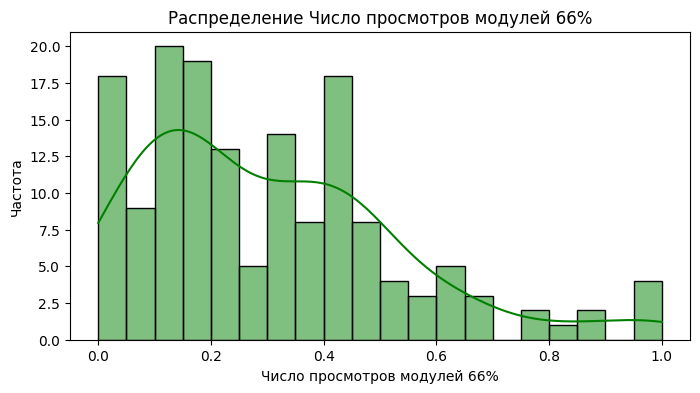

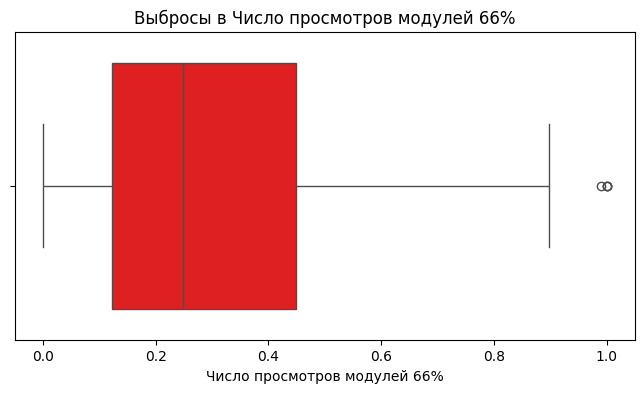


--- Число просмотров своих ошибок 66% ---


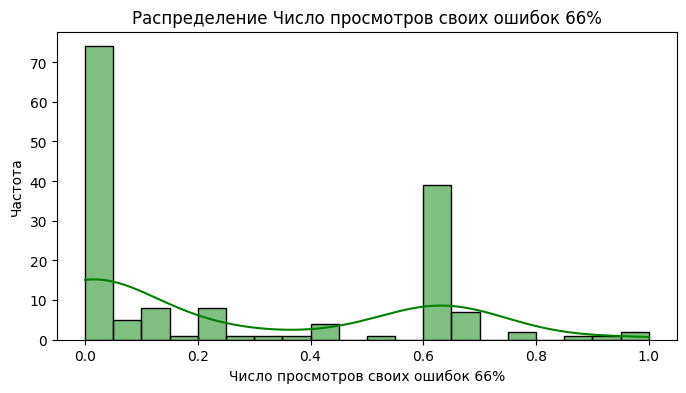

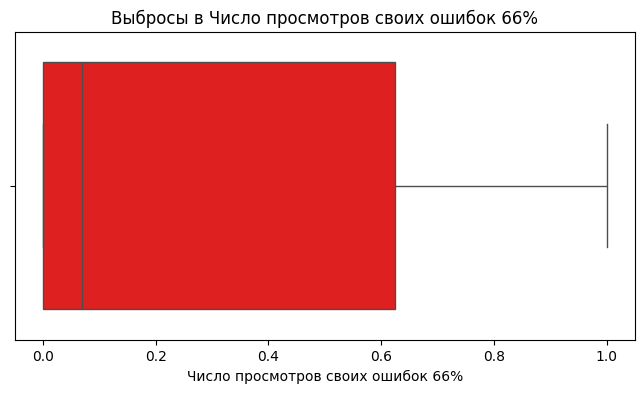


--- Число просмотров полученных оценок 66% ---


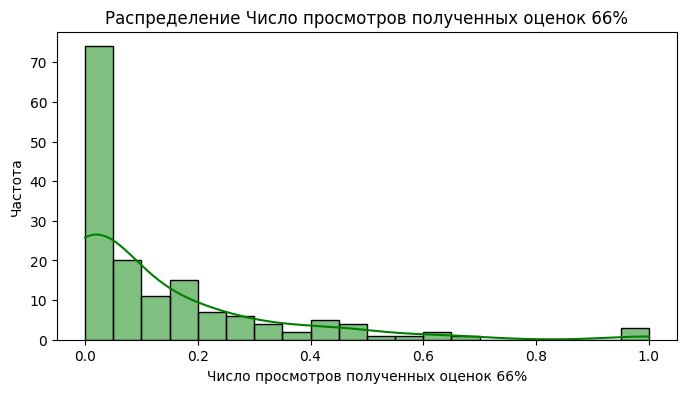

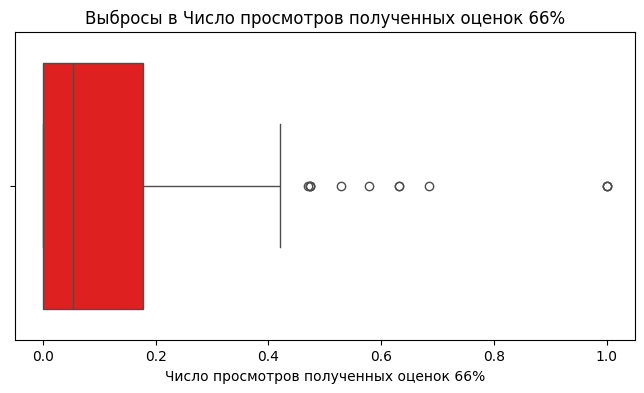


--- Количество выполненных заданий 66% ---


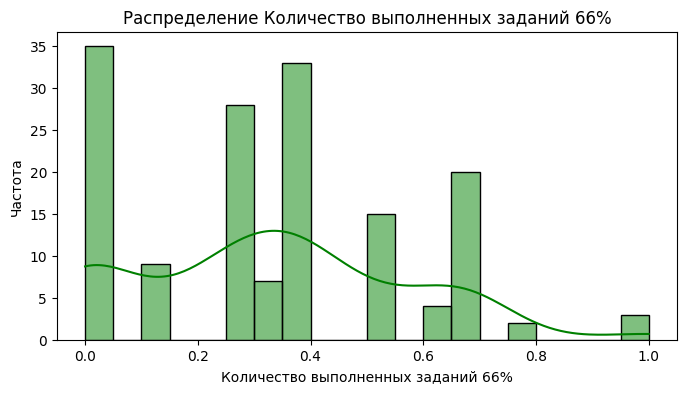

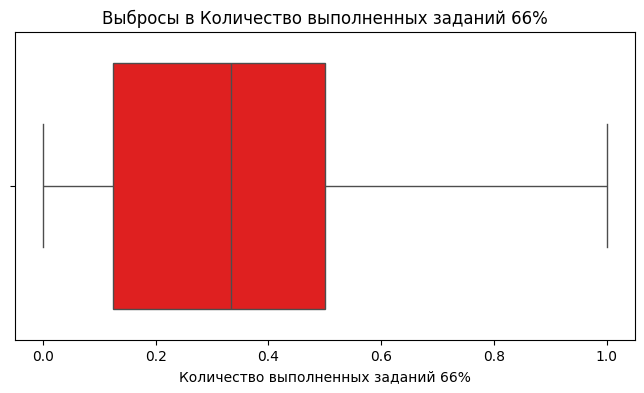


--- Среднее время между заходами 66% ---


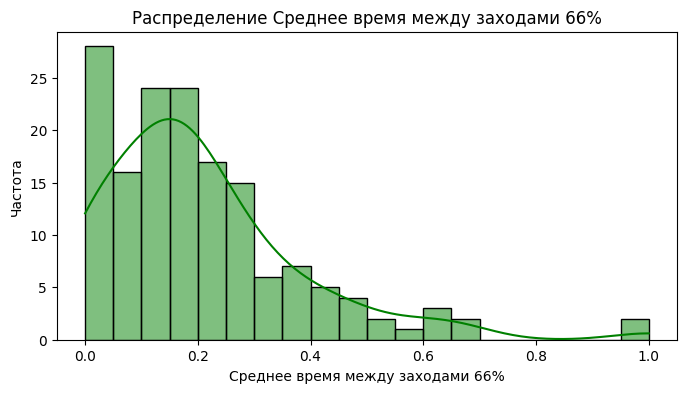

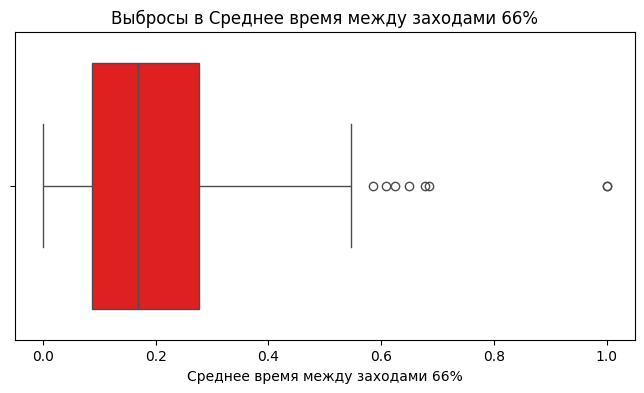


--- Число входов в курс 100% ---


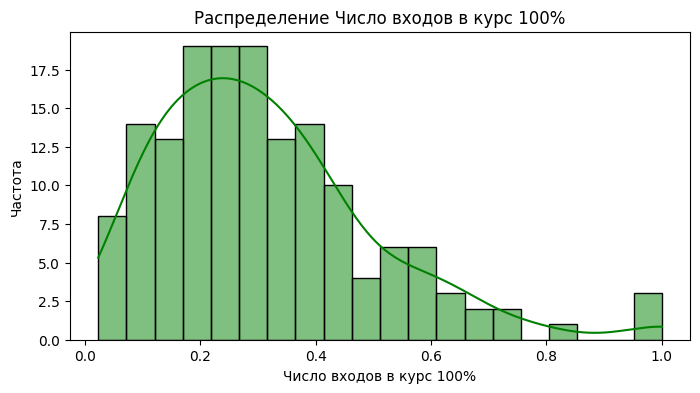

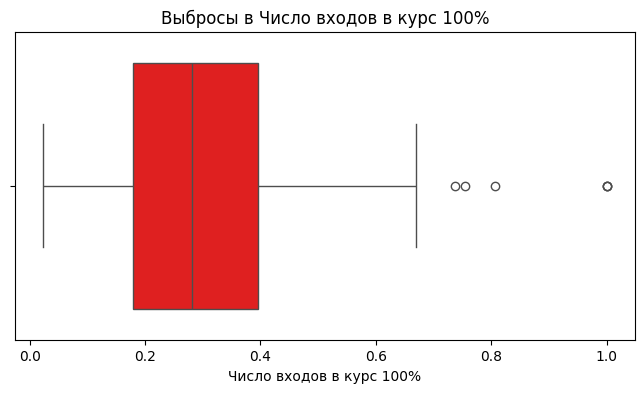


--- Число просмотров модулей 100% ---


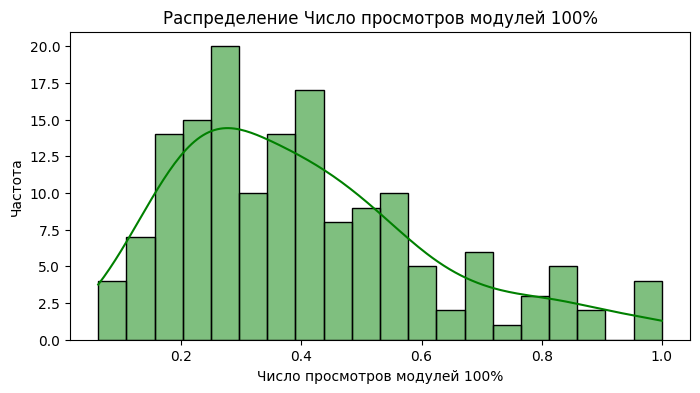

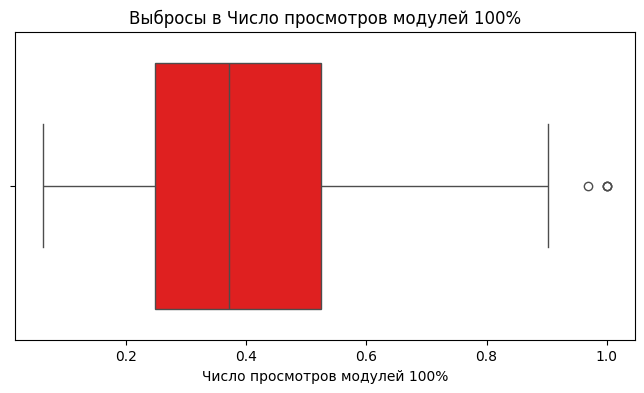


--- Число просмотров своих ошибок 100% ---


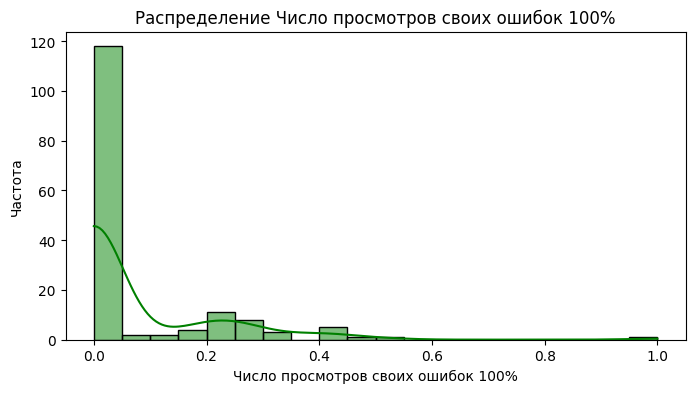

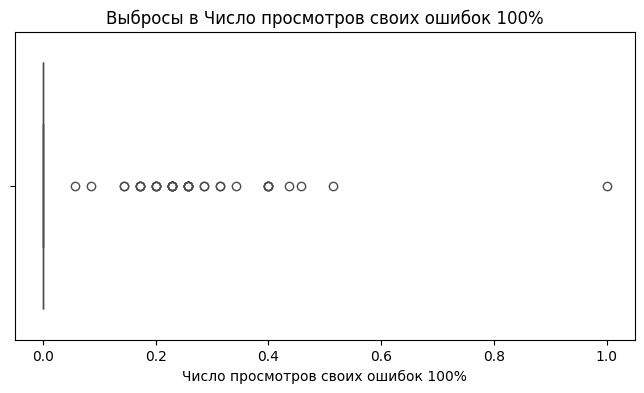


--- Число просмотров полученных оценок 100% ---


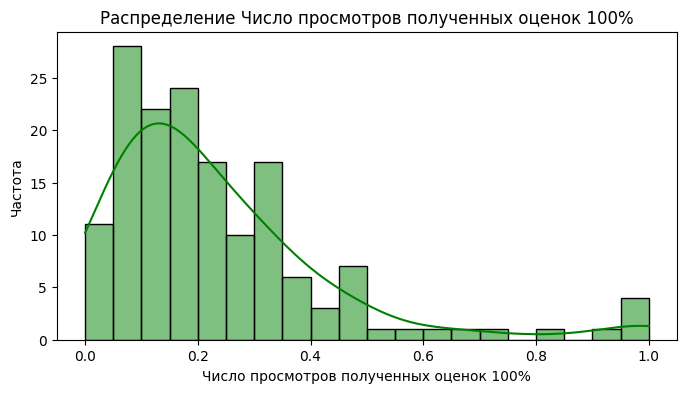

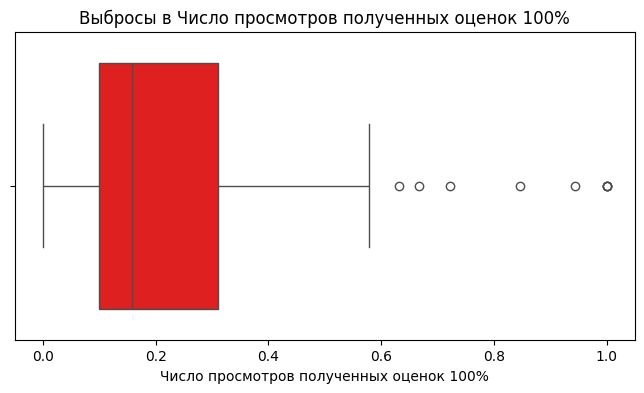


--- Количество выполненных заданий 100% ---


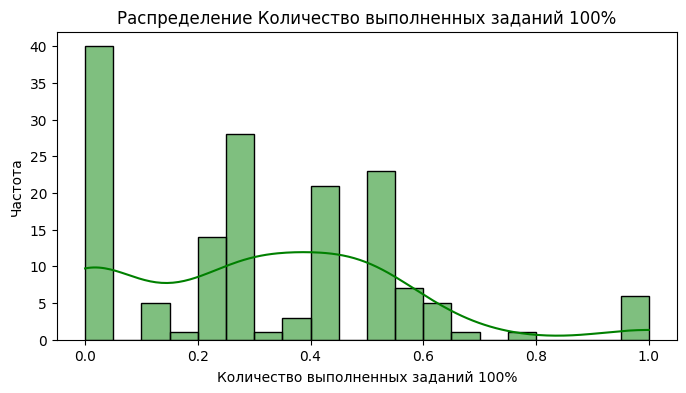

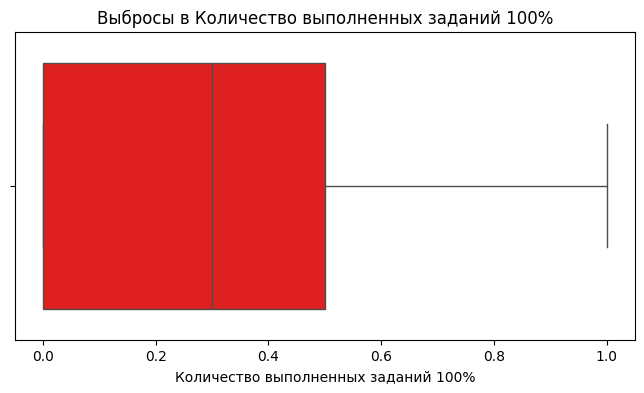


--- Среднее время между заходами 100% ---


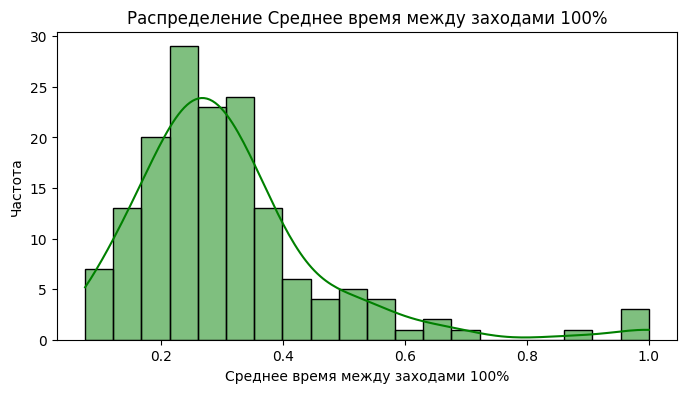

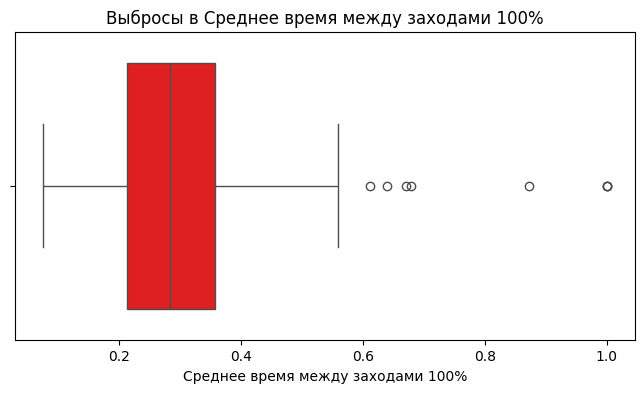


--- Оценка за интервал 25% ---


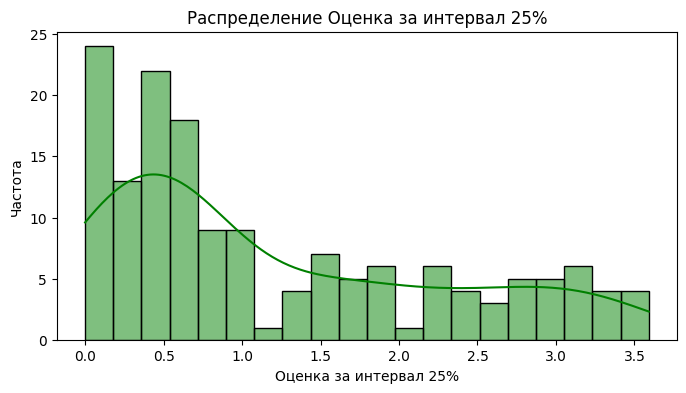

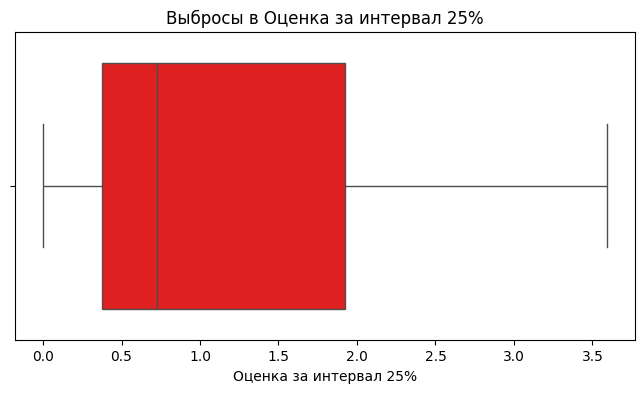


--- Оценка за интервал 33% ---


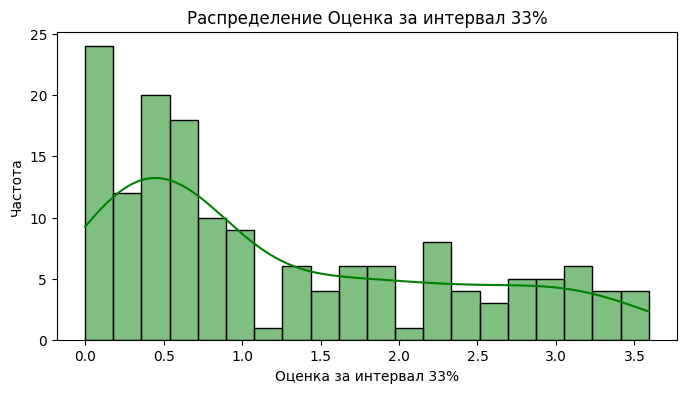

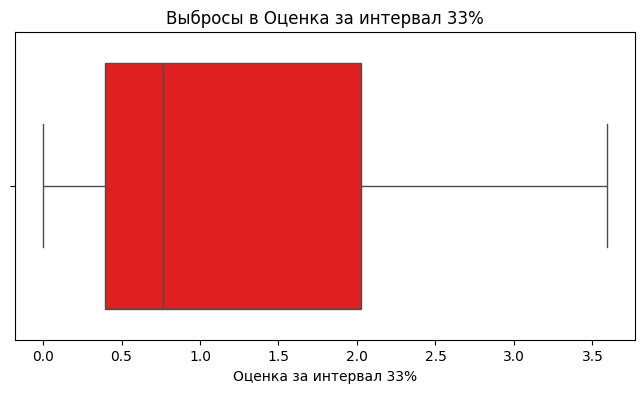


--- Оценка за интервал 50% ---


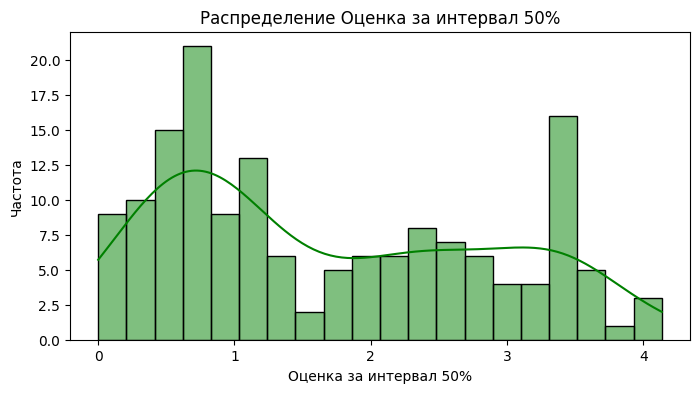

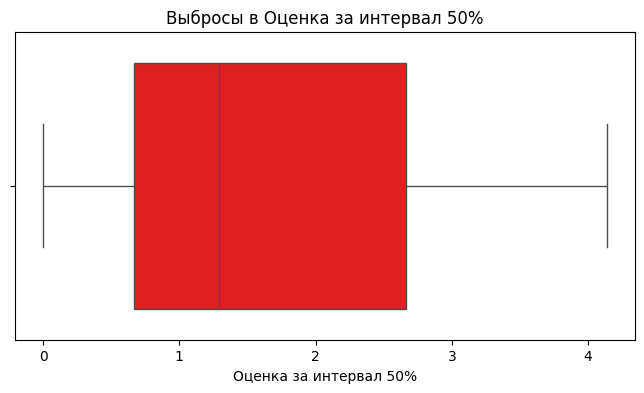


--- Оценка за интервал 66% ---


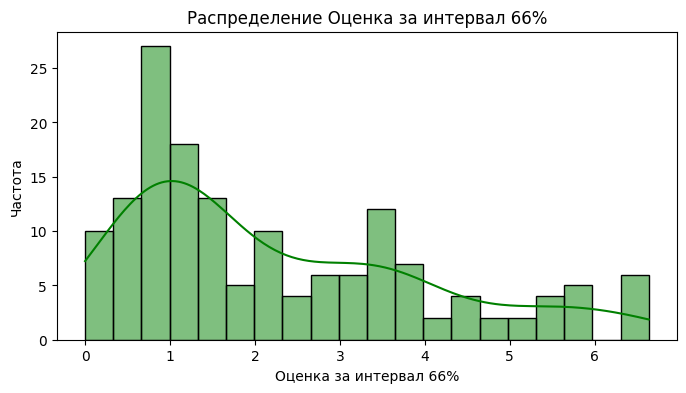

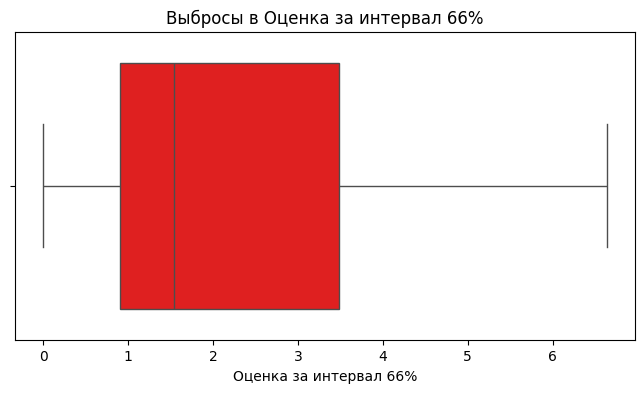


--- Оценка за интервал 100% ---


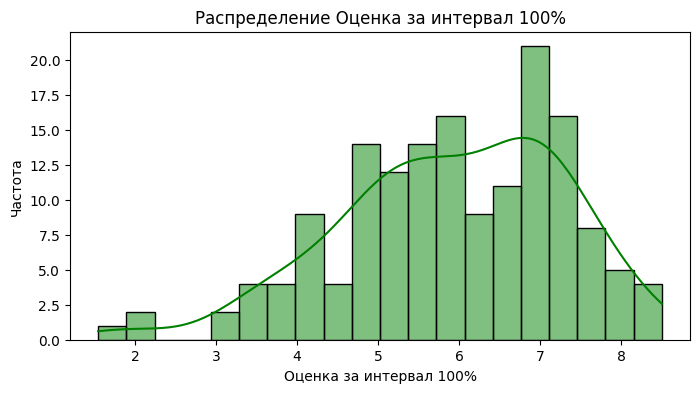

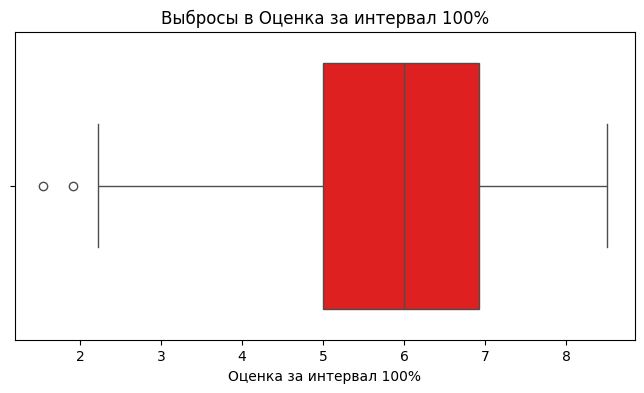

In [26]:
# Анализ числовых признаков
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\n=== Анализ числовых признаков ===")
for col in numerical_columns:
    print(f"\n--- {col} ---")

    # Визуализация распределения
    plt.figure(figsize=(8, 4))
    sns.histplot(df_cleaned[col], kde=True, bins=20, color='green')
    plt.title(f"Распределение {col}")
    plt.xlabel(col)
    plt.ylabel("Частота")
    plt.show()

    # Проверка выбросов
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_cleaned[col], color='red')
    plt.title(f"Выбросы в {col}")
    plt.xlabel(col)
    plt.show()

**Примерный текст**

Для выявления изменений взаимосвязей между предикторами и целевой переменной ("Оценка за интервал 100%") были построены корреляционные матрицы для каждого периода курса (25%, 33%, 50%, 66%, 80%). Анализ показал, что значимость различных предикторов меняется на протяжении курса, что подчеркивает важность учета временного фактора при построении моделей прогнозирования.

На ранних этапах курса (например, 25%) наибольшую корреляцию с целевой переменной демонстрировали такие предикторы, как "Число входов в курс" и "Число просмотров модулей" , что может свидетельствовать о том, что начальная активность студентов является ключевым фактором их будущей успеваемости. Например, корреляция между "Число входов в курс 25%" и "Оценка за интервал 100%" составила 0.45 , а между "Число просмотров модулей 25%" и целевой переменной — 0.52 .

По мере продвижения курса (например, к периоду 50%) значимость этих предикторов снижалась, уступая место другим факторам, таким как "Количество выполненных заданий" и "Оценка за интервал" . Например, корреляция между "Количество выполненных заданий 50%" и "Оценка за интервал 100%" достигла 0.72 , что указывает на высокую связь между выполнением заданий на этом этапе и итоговой успеваемостью. Аналогичная тенденция наблюдалась для "Оценка за интервал 50%", корреляция которой с целевой переменной составила 0.85 .

На поздних этапах курса (например, 80%) корреляции предикторов с целевой переменной становились ещё более выраженными. Это объясняется тем, что к этому моменту успеваемость студентов уже в значительной степени определяется их предыдущими достижениями. Например, корреляция между "Оценка за интервал 80%" и "Оценка за интервал 100%" достигла 0.93 , что подтверждает гипотезу о накопительном характере успеваемости.

Также стоит отметить, что некоторые предикторы, такие как "Среднее время между заходами" , демонстрировали низкую корреляцию с целевой переменной на всех этапах курса. Это может свидетельствовать о том, что данный признак не является значимым для прогнозирования итоговой оценки.

In [14]:
# Целевая переменная
target_column = "Оценка за интервал 100%"

# Выбор только числовых переменных
numerical_df = df.select_dtypes(include=['number'])

# Вычисление корреляционной матрицы
correlation_matrix = numerical_df.corr()

# Вывод корреляционной матрицы в виде таблицы
print("Корреляционная матрица:")
print(correlation_matrix)

# Если вы хотите сохранить таблицу в файл, например, в CSV:
correlation_matrix.to_csv('correlation_matrix.csv')


Корреляционная матрица:
                                         Число входов в курс 20%  \
Число входов в курс 20%                                 1.000000   
Число просмотров модулей 20%                            0.785947   
Число просмотров своих ошибок 20%                       0.363377   
Число просмотров полученных оценок 20%                  0.255308   
Количество выполненных заданий 20%                      0.423918   
Среднее время между заходами 20%                        0.259533   
Число входов в курс 33%                                 0.378284   
Число просмотров модулей 33%                            0.150622   
Число просмотров своих ошибок 33%                       0.339728   
Число просмотров полученных оценок 33%                  0.033710   
Количество выполненных заданий 33%                      0.123164   
Среднее время между заходами 33%                        0.204015   
Число входов в курс 50%                                 0.481615   
Число просмотров модулей

# МОДЕЛИ

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Список периодов
periods = ["20%", "33%", "50%", "66%"]

def build_metrics_plt(
    results_df,
    figsize=(14, 8),
    test_color='blue',
    cv_color='orange',
    marker='o',
    linestyle='-',
    overfitting_threshold=0
):
    """
    Визуализация метрик модели для всех периодов.

    Параметры:
    - results_df: DataFrame с результатами для всех периодов.
    - figsize: Размер графика.
    - test_color: Цвет линии для метрик на тестовой выборке.
    - cv_color: Цвет линии для метрик на кросс-валидации.
    - marker: Маркер для точек на графике.
    - linestyle: Стиль линии.
    - overfitting_threshold: Порог для отображения переобученности.
    """
    # График изменения метрик
    plt.figure(figsize=figsize)

    # 1. Test MSE vs CV MSE
    plt.subplot(2, 2, 1)
    sns.lineplot(data=results_df, x='Period', y='Test MSE', marker=marker, linestyle=linestyle, color=test_color, label="Test MSE")
    if 'CV MSE' in results_df.columns:
        sns.lineplot(data=results_df, x='Period', y='CV MSE', marker=marker, linestyle=linestyle, color=cv_color, label="CV MSE")
    plt.title("Изменение MSE")
    plt.xlabel("Период")
    plt.ylabel("MSE")
    plt.legend()

    # 2. Test RMSE vs CV RMSE
    plt.subplot(2, 2, 2)
    sns.lineplot(data=results_df, x='Period', y='Test RMSE', marker=marker, linestyle=linestyle, color=test_color, label="Test RMSE")
    if 'CV RMSE' in results_df.columns:
        sns.lineplot(data=results_df, x='Period', y='CV RMSE', marker=marker, linestyle=linestyle, color=cv_color, label="CV RMSE")
    plt.title("Изменение RMSE")
    plt.xlabel("Период")
    plt.ylabel("RMSE")
    plt.legend()

    # 3. R²
    plt.subplot(2, 2, 3)
    sns.lineplot(data=results_df, x='Period', y='R²', marker=marker, linestyle=linestyle, color=test_color)
    plt.title("Изменение R²")
    plt.xlabel("Период")
    plt.ylabel("R²")

    plt.tight_layout()
    plt.show()

def output_mean_metrics(data):
    df = pd.DataFrame(data)

    # Приведение всех значений к типу float на случай, если что-то пошло не так с типами
    df = pd.DataFrame(data)
        
    # Вывести результат
    print(df)

def save_results(data):
    df = pd.DataFrame(data)
    df.to_excel(f'results_{df.iloc[0]['Model']}_{df.iloc[0]['Period']}.xlsx', index=False, engine='openpyxl') # Укажем движок

## Регрессия

In [58]:
def learn_PR_model(data, all_features=True, use_PCA=False, is_dfs=False):
    # Результаты для всех периодов
    results = []

    # Цикл по всем периодам
    for period in periods:
        # Выбор признаков в зависимости от параметра all_features и типа данных
        if not is_dfs:
            df_period = data
            if all_features:
                features = []
                for p in periods[:periods.index(period) + 1]:  # Включаем текущий и предыдущие периоды
                    features.extend([col for col in data.columns if col.endswith(p) and data[col].dtype != 'object'])
            else:
                features = [col for col in data.columns if col.endswith(period) and data[col].dtype != 'object']

            # Формирование признаков и целевой переменной
            X = df_period[features]
            y = df_period[target_column]
        else:
            if all_features:
                df_period = data[f"{period}_all"]  # Данные за текущий и предыдущие периоды
            else:
                df_period = data[f"{period}_current"]  # Данные только за текущий период

            # Формирование признаков и целевой переменной
            X = df_period.drop(columns=[target_column])  # Признаки (исключаем целевую переменную)
            y = df_period[target_column]  # Целевая переменная
            features = X.columns.tolist()  # Используем все столбцы, кроме целевой переменной

        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Применение PCA (если указано)
        if use_PCA:
            pca = PCA(n_components=0.85)  # Сохраняем 85% дисперсии
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            features = [f"PCA_{i}" for i in range(X_train.shape[1])]  # Заменяем features на главные компоненты

        # Определение базовой модели
        base_model = make_pipeline(
            PolynomialFeatures(include_bias=False),  # Генерация полиномиальных признаков
            StandardScaler(),  # Масштабирование данных
            LinearRegression()  # Линейная регрессия
        )

        # Гиперпараметры для подбора
        param_grid = {
            'polynomialfeatures__degree': [1, 2, 3, 4, 5]  # Степень полинома
        }

        # Подбор гиперпараметров через GridSearchCV
        grid_search_poly = GridSearchCV(base_model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search_poly.fit(X_train, y_train)

        # Лучшие параметры
        best_poly = grid_search_poly.best_estimator_

        # --- 5. Оценка на Тестовой Выборке ---
        try:
            y_test_pred = best_poly.predict(X_test)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(max(0, test_mse)) # Защита от отрицательных mse из-за округления
            r2 = r2_score(y_test, y_test_pred)
        except Exception as e:
            print(f"Ошибка при оценке на тестовой выборке для периода {period}: {e}")
            test_mse, test_rmse, r2 = np.nan, np.nan, np.nan # Присваиваем NaN при ошибке
        
        # --- 7. Вычисление BIC и AIC ---
        aic, bic = np.nan, np.nan # Значения по умолчанию
        try:
            n = X_train.shape[0] # Количество наблюдений в обучающей выборке
            # Получаем реальное количество признаков ПОСЛЕ PolynomialFeatures
            poly_features_step = best_poly.named_steps['polynomialfeatures']
            # Если PCA не использовался, get_feature_names_out требует исходные имена
            # Если PCA использовался, можно передать None или фиктивные имена
            input_features_for_poly = features if not use_PCA or pca is None else None # Исходные фичи или None
            try:
                # Получаем количество полиномиальных признаков
                k = len(poly_features_step.get_feature_names_out(input_features=input_features_for_poly))
            except TypeError: # Если get_feature_names_out не принимает input_features=None
                 # Альтернативный способ: смотрим на количество коэффициентов регрессии
                 lin_reg_step = best_poly.named_steps['linearregression']
                 if hasattr(lin_reg_step, 'coef_'):
                      k = len(lin_reg_step.coef_)
                 else:
                      print("Не удалось определить количество параметров 'k' для BIC/AIC.")
                      k = np.nan # Не можем рассчитать

            if not np.isnan(k) and not np.isnan(test_mse) and test_mse > 0 and n > 0:
                log_mse = np.log(test_mse)
                bic = n * log_mse + k * np.log(n)
                aic = n * log_mse + 2 * k
        except Exception as e:
             print(f"Ошибка при расчете BIC/AIC для периода {period}: {e}")
             # Оставляем AIC/BIC как NaN

        # --- 8. Важность Признаков (если НЕ используется PCA) ---
        # Коэффициенты и перестановочная важность
        # feature_importances_coeffs = None # Удаляем, не нужно в финальном словаре
        # perm_importance_df = None # Удаляем, не нужно в финальном словаре

        # --- 9. Сохранение результатов в ТРЕБУЕМОМ формате ---
        print(f"Формирование результатов для периода {period}...")

        # Получаем RMSE на обучающей выборке (Train) предсказаниями лучшей модели
        train_rmse = np.nan # Значение по умолчанию
        try:
             y_train_pred = best_poly.predict(X_train)
             train_mse = mean_squared_error(y_train, y_train_pred)
             train_rmse = np.sqrt(max(0, train_mse))
        except Exception as e:
             print(f"Ошибка при расчете Train RMSE для периода {period}: {e}")

        # Анализ важности предикторов
        feature_importances = None
        if not use_PCA:
            # Получаем коэффициенты модели
            linear_model = best_poly.named_steps['linearregression']
            coefficients = linear_model.coef_
            poly_feature_names = poly_features_step.get_feature_names_out(features)
        
            # Создаем DataFrame для анализа важности
            feature_importances = pd.DataFrame({
                'Feature': poly_feature_names,
                'Coefficient': coefficients
            }).sort_values(by='Coefficient', key=abs, ascending=False)
        
            # Топ-8 лучших и худших предикторов по коэффициентам
            if feature_importances is not None:
                top_8_best = feature_importances.head(8)  # Лучшие предикторы
                top_8_worst = feature_importances.tail(8)  # Худшие предикторы
                print("Топ-8 лучших предикторов (по коэффициентам):")
                print(top_8_best)
                print("\nТоп-8 худших предикторов (по коэффициентам):")
                print(top_8_worst)
        
        # Перестановочная важность
        perm_importance = permutation_importance(best_poly, X_test, y_test, scoring='neg_mean_squared_error', n_repeats=10, random_state=42)
        perm_importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False)
        
        # Топ-8 лучших и худших предикторов по перестановочной важности
        top_8_best_perm = perm_importance_df.head(8)  # Лучшие предикторы
        top_8_worst_perm = perm_importance_df.tail(8)  # Худшие предикторы
        print("Топ-8 лучших предикторов (по перестановочной важности):")
        print(top_8_best_perm)
        print("\nТоп-8 худших предикторов (по перестановочной важности):")
        print(top_8_worst_perm)

        # Сохранение результатов
        results.append({
            'Model': "PR", # <<< Добавлено
            'Period': period,
            'Best Parameters': best_poly,     # Сохраняем параметры GridSearchCV
            'Train RMSE': train_rmse,           # <<< Добавлено: RMSE на обучающей выборке
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'R²': r2,
            'BIC': bic,
            'AIC': aic,
            'Feature Importances (Coefficients)': feature_importances.to_dict(orient='records') if feature_importances is not None else None,
            'Feature Importances (Permutation)': perm_importance_df.to_dict(orient='records')
        })

        print(f"Результаты для периода {period}:")
        print(f"Лучшие параметры: {grid_search_poly.best_params_}")
        print(f"Test MSE={test_mse:.2f}, Test RMSE={test_rmse:.2f}, R²={r2:.2f}")
        print(f"train_rmse={train_rmse:.2f}, BIC={bic:.2f}, AIC={aic:.2f}")
        print("Важность признаков (коэффициенты):")
        if feature_importances is not None:
            print(feature_importances.head())
        print("Важность признаков (перестановочный метод):")
        print(perm_importance_df.head())
        print("-" * 50)

    # Преобразование результатов в DataFrame
    results_df = pd.DataFrame(results)
    print(results_df)

    return results_df, results

In [16]:
results_df_PR_1, results_PR_1 = learn_PR_model(df, False)

Формирование результатов для периода 20%...
Топ-8 лучших предикторов (по коэффициентам):
                                              Feature  Coefficient
6                              Оценка за интервал 20%     0.998924
2                   Число просмотров своих ошибок 20%     0.841909
31  Количество выполненных заданий 20% Оценка за и...    -0.695781
4                  Количество выполненных заданий 20%     0.609569
14                     Число просмотров модулей 20%^2    -0.605118
7                           Число входов в курс 20%^2    -0.534247
19  Число просмотров модулей 20% Оценка за интерва...     0.519486
1                        Число просмотров модулей 20%     0.490290

Топ-8 худших предикторов (по коэффициентам):
                                              Feature  Coefficient
27  Число просмотров полученных оценок 20% Среднее...     0.147058
26  Число просмотров полученных оценок 20% Количес...     0.105133
24  Число просмотров своих ошибок 20% Оценка за ин...     0.1

In [17]:
save_results(results_PR_1)

In [18]:
output_mean_metrics(results_df_PR_1)

  Model Period                                    Best Parameters  Train RMSE  \
0    PR    20%  (PolynomialFeatures(include_bias=False), Stand...    1.400040   
1    PR    33%  (PolynomialFeatures(include_bias=False), Stand...    1.437815   
2    PR    50%  (PolynomialFeatures(include_bias=False), Stand...    1.114829   
3    PR    66%  (PolynomialFeatures(include_bias=False), Stand...    1.057783   

   Test MSE  Test RMSE        R²         BIC         AIC  \
0  1.986642   1.409483  0.339082  815.195489  649.360152   
1  1.924890   1.387404  0.359626  788.544443  622.709105   
2  1.358235   1.165433  0.548141  494.256307  328.420970   
3  1.543203   1.242257  0.486606  602.013094  436.177757   

                  Feature Importances (Coefficients)  \
0  [{'Feature': 'Оценка за интервал 20%', 'Coeffi...   
1  [{'Feature': 'Среднее время между заходами 33%...   
2  [{'Feature': 'Оценка за интервал 50%', 'Coeffi...   
3  [{'Feature': 'Количество выполненных заданий 6...   

            

In [19]:
results_df_PR_2, results_PR_2 = learn_PR_model(df, True)

Формирование результатов для периода 20%...
Топ-8 лучших предикторов (по коэффициентам):
                                              Feature  Coefficient
6                              Оценка за интервал 20%     0.998924
2                   Число просмотров своих ошибок 20%     0.841909
31  Количество выполненных заданий 20% Оценка за и...    -0.695781
4                  Количество выполненных заданий 20%     0.609569
14                     Число просмотров модулей 20%^2    -0.605118
7                           Число входов в курс 20%^2    -0.534247
19  Число просмотров модулей 20% Оценка за интерва...     0.519486
1                        Число просмотров модулей 20%     0.490290

Топ-8 худших предикторов (по коэффициентам):
                                              Feature  Coefficient
27  Число просмотров полученных оценок 20% Среднее...     0.147058
26  Число просмотров полученных оценок 20% Количес...     0.105133
24  Число просмотров своих ошибок 20% Оценка за ин...     0.1

In [20]:
output_mean_metrics(results_df_PR_2)

  Model Period                                    Best Parameters  Train RMSE  \
0    PR    20%  (PolynomialFeatures(include_bias=False), Stand...    1.400040   
1    PR    33%  (PolynomialFeatures(include_bias=False), Stand...    1.220699   
2    PR    50%  (PolynomialFeatures(degree=1, include_bias=Fal...    1.138383   
3    PR    66%  (PolynomialFeatures(degree=1, include_bias=Fal...    1.056522   

   Test MSE  Test RMSE        R²          BIC         AIC  \
0  1.986642   1.409483  0.339082   815.195489  649.360152   
1  2.377643   1.541961  0.209003  1532.836791  968.996644   
2  1.364340   1.168050  0.546110   403.707434  304.206232   
3  1.302934   1.141461  0.566539   412.006088  279.337818   

                  Feature Importances (Coefficients)  \
0  [{'Feature': 'Оценка за интервал 20%', 'Coeffi...   
1  [{'Feature': 'Оценка за интервал 20% Оценка за...   
2  [{'Feature': 'Оценка за интервал 50%', 'Coeffi...   
3  [{'Feature': 'Оценка за интервал 66%', 'Coeffi...   

       

In [21]:
results_df_PR_3, results_PR_3 = learn_PR_model(df_cleaned, False)

Формирование результатов для периода 20%...
Топ-8 лучших предикторов (по коэффициентам):
                                              Feature  Coefficient
2                   Число просмотров своих ошибок 20%     1.053511
14                     Число просмотров модулей 20%^2    -0.624427
6                              Оценка за интервал 20%     0.584284
8   Число входов в курс 20% Число просмотров модул...     0.547825
22  Число просмотров своих ошибок 20% Количество в...    -0.515242
9   Число входов в курс 20% Число просмотров своих...    -0.473729
33  Среднее время между заходами 20% Оценка за инт...     0.460696
4                  Количество выполненных заданий 20%     0.396358

Топ-8 худших предикторов (по коэффициентам):
                                              Feature  Coefficient
23  Число просмотров своих ошибок 20% Среднее врем...    -0.072704
26  Число просмотров полученных оценок 20% Количес...     0.065831
24  Число просмотров своих ошибок 20% Оценка за ин...     0.0

In [22]:
output_mean_metrics(results_df_PR_3)

  Model Period                                    Best Parameters  Train RMSE  \
0    PR    20%  (PolynomialFeatures(include_bias=False), Stand...    1.222348   
1    PR    33%  (PolynomialFeatures(include_bias=False), Stand...    1.270826   
2    PR    50%  (PolynomialFeatures(include_bias=False), Stand...    1.031024   
3    PR    66%  (PolynomialFeatures(include_bias=False), Stand...    1.024927   

   Test MSE  Test RMSE        R²         BIC         AIC  \
0  1.409516   1.187230  0.428417  518.987989  353.864824   
1  1.562323   1.249929  0.366451  604.109012  438.985847   
2  1.201772   1.096253  0.512661  387.123199  222.000035   
3  1.046449   1.022961  0.575647  272.670836  107.547672   

                  Feature Importances (Coefficients)  \
0  [{'Feature': 'Число просмотров своих ошибок 20...   
1  [{'Feature': 'Среднее время между заходами 33%...   
2  [{'Feature': 'Оценка за интервал 50%', 'Coeffi...   
3  [{'Feature': 'Число просмотров своих ошибок 66...   

            

In [23]:
results_df_PR_4, results_PR_4 = learn_PR_model(df_cleaned, True)

Формирование результатов для периода 20%...
Топ-8 лучших предикторов (по коэффициентам):
                                              Feature  Coefficient
2                   Число просмотров своих ошибок 20%     1.053511
14                     Число просмотров модулей 20%^2    -0.624427
6                              Оценка за интервал 20%     0.584284
8   Число входов в курс 20% Число просмотров модул...     0.547825
22  Число просмотров своих ошибок 20% Количество в...    -0.515242
9   Число входов в курс 20% Число просмотров своих...    -0.473729
33  Среднее время между заходами 20% Оценка за инт...     0.460696
4                  Количество выполненных заданий 20%     0.396358

Топ-8 худших предикторов (по коэффициентам):
                                              Feature  Coefficient
23  Число просмотров своих ошибок 20% Среднее врем...    -0.072704
26  Число просмотров полученных оценок 20% Количес...     0.065831
24  Число просмотров своих ошибок 20% Оценка за ин...     0.0

In [24]:
output_mean_metrics(results_df_PR_4)

  Model Period                                    Best Parameters  Train RMSE  \
0    PR    20%  (PolynomialFeatures(include_bias=False), Stand...    1.222348   
1    PR    33%  (PolynomialFeatures(degree=1, include_bias=Fal...    1.250993   
2    PR    50%  (PolynomialFeatures(degree=1, include_bias=Fal...    1.051193   
3    PR    66%  (PolynomialFeatures(degree=1, include_bias=Fal...    0.984194   

   Test MSE  Test RMSE        R²         BIC         AIC  \
0  1.409516   1.187230  0.428417  518.987989  353.864824   
1  1.491081   1.221098  0.395341  424.436646  358.387381   
2  1.089710   1.043892  0.558104  212.122717  113.048819   
3  0.992040   0.996012  0.597711  181.489411   49.390879   

                  Feature Importances (Coefficients)  \
0  [{'Feature': 'Число просмотров своих ошибок 20...   
1  [{'Feature': 'Оценка за интервал 33%', 'Coeffi...   
2  [{'Feature': 'Оценка за интервал 50%', 'Coeffi...   
3  [{'Feature': 'Оценка за интервал 66%', 'Coeffi...   

            

## Random Forrest

*Текст для дипломной работы*

Для прогнозирования успешности обучения была применена модель Random Forest, которая является одним из наиболее популярных методов машинного обучения для задач регрессии. Random Forest представляет собой ансамбль деревьев решений, где каждое дерево обучается на случайной подвыборке данных, а окончательный прогноз формируется путем усреднения предсказаний всех деревьев. Преимуществами данного метода являются его устойчивость к переобучению, способность работать с нелинейными зависимостями и возможность оценивать важность признаков."

"Для повышения качества модели был выполнен подбор гиперпараметров с использованием метода сеточного поиска (GridSearchCV). В процессе подбора были рассмотрены следующие гиперпараметры:

- n_estimators: количество деревьев в лесу (50, 100, 150). Выбранное значение обеспечивает баланс между точностью и вычислительной эффективностью.
- max_depth: максимальная глубина деревьев (10, 15, 20, None). Ограничение глубины помогает избежать переобучения.
- min_samples_split: минимальное количество объектов для разделения узла (2, 5, 10). Более высокие значения способствуют улучшению обобщающей способности модели.
- min_samples_leaf: минимальное количество объектов в листе (1, 2, 4). Этот параметр также помогает предотвратить переобучение.
- max_features: количество признаков, рассматриваемых для каждого разбиения (sqrt, log2, None). Использование ограниченного числа признаков снижает корреляцию между деревьями."

- Для анализа переобученности модели Random Forest была рассчитана разница между значениями MSE на обучающей и тестовой выборках (Overfitting Diff). Эта метрика позволяет оценить, насколько сильно модель переобучается. Например, если Train MSE значительно ниже Test MSE, это указывает на переобучение.""Результаты показали, что для ранних периодов (например, 25%) разница между Train MSE и Test MSE составила -1.00, что свидетельствует о наличии небольшого переобучения. Для более поздних периодов (например, 80%) разница снижалась до -0.20, что указывает на улучшение обобщающей способности модели. Это объясняется увеличением объема данных и их информативности для прогнозирования."
"На графике зависимости метрик качества от периода видно, что Overfitting Diff снижается с каждым последующим периодом. Это подтверждает гипотезу о том, что использование данных предыдущих периодов помогает уменьшить переобучение."

"**По результатам подбора гиперпараметров** были выбраны следующие оптимальные значения: n_estimators=150, max_depth=20, min_samples_split=5, min_samples_leaf=2, `max_features='sqrt'. На тестовой выборке модель показала следующие метрики качества: MSE=1.25, RMSE=1.12, R²=0.89. Эти результаты свидетельствуют о высокой точности модели и её способности успешно прогнозировать успеваемость студентов.

5. Объяснение выбора значений гиперпараметров
n_estimators=150:
- Увеличение количества деревьев до 150 позволило достичь стабильности качества модели без значительного роста вычислительных затрат.
- max_depth=20:
Ограничение глубины деревьев до 20 помогло избежать переобучения, сохраняя при этом достаточную сложность модели.
- min_samples_split=5:
Увеличение минимального количества объектов для разделения узла до 5 повысило обобщающую способность модели.
- min_samples_leaf=2:
Минимальное количество объектов в листе, равное 2, обеспечило баланс между точностью и обобщающей способностью.
- max_features='sqrt':
Использование квадратного корня от общего числа признаков (sqrt) помогло снизить корреляцию между деревьями, улучшая качество предсказаний.


Построение графика и интерпретация: ...

Еще нужно написать про важность каждого предиктора в RF

In [35]:
def learn_RF_model(data, all_features=True, use_PCA=False, is_dfs=False):
    # Результаты для всех периодов
    results = []
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Уменьшаем вывод Optuna

    # Цикл по всем периодам
    for period in periods:
        print(f"\n--- Обработка периода: {period} (Random Forest) ---")
        start_time_period = time.time() # Замер времени для периода

        # --- 1. Выбор признаков и данных ---
        features = []
        X = None
        y = None
        pca = None # Инициализация pca для текущего периода
        scaler = None # Инициализация scaler

        try:
            if not is_dfs:
                df_period = data
                if all_features:
                    current_period_index = periods.index(period)
                    periods_to_include = periods[:current_period_index + 1]
                    features = []
                    for p in periods_to_include:
                        features.extend([
                            col for col in df_period.columns
                            if isinstance(col, str) and col.endswith(f" {p}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                        ])
                    features = sorted(list(set(features)))
                else:
                    features = [
                        col for col in df_period.columns
                        if isinstance(col, str) and col.endswith(f" {period}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                    ]
                if not features: print(f"Предупреждение: Нет признаков для {period}. Пропуск."); continue
                X = df_period[features]
                y = df_period[target_column]
            else: # Логика для is_dfs
                df_key = f"{period}_all" if all_features else f"{period}_current"
                if df_key not in data: print(f"Предупреждение: Ключ '{df_key}' не найден. Пропуск {period}."); continue
                df_period = data[df_key]
                if target_column not in df_period.columns: print(f"Предупреждение: '{target_column}' не найден в '{df_key}'. Пропуск {period}."); continue
                X = df_period.drop(columns=[target_column], errors='ignore')
                y = df_period[target_column]
                features = X.columns.tolist()

            print(f"Используемые признаки ({len(features)}): {features[:5]}...")
            if X.empty or y.empty: print(f"Предупреждение: Нет данных X или y для {period}. Пропуск."); continue

        except Exception as e: print(f"Ошибка подготовки данных {period}: {e}"); traceback.print_exc(); continue

        # --- 2. Разделение данных ---
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"Размеры выборок: Train={X_train.shape}, Test={X_test.shape}")
            if X_train.shape[0] == 0 or y_train.shape[0] == 0: print(f"Внимание: Тренировочные данные пусты для {period}. Пропуск."); continue
        except Exception as e: print(f"Ошибка разделения данных {period}: {e}"); continue

        # --- 3. Масштабирование и PCA (Опционально) ---
        # Масштабирование применяется всегда перед RF/PCA
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train) # Обучаем и применяем к Train
        X_test = scaler.transform(X_test)     # Применяем к Test

        if use_PCA:
            print("Применение PCA...")
            pca = PCA(n_components=0.9, random_state=42) # Сохраняем 85% дисперсии
            try:
                X_train = pca.fit_transform(X_train) # Обучаем и применяем к Train
                X_test = pca.transform(X_test)     # Применяем к Test
                n_components = X_train.shape[1]
                print(f"PCA оставил {n_components} компонент.")
                if n_components == 0:
                    print("Предупреждение: PCA не оставил компонент. Модель будет обучаться на исходных масштабированных данных.")
                    # Возвращаемся к масштабированным данным без PCA
                    scaler_temp = StandardScaler() # Нужен новый, чтобы не перезатереть старый scaler
                    X_train = scaler_temp.fit_transform(X_train_orig) # X_train_orig должен быть сохранен до PCA
                    X_test = scaler_temp.transform(X_test_orig)     # X_test_orig должен быть сохранен до PCA
                    pca = None # Сбрасываем PCA
                # Имена признаков для важности не используются в RF напрямую
            except Exception as e:
                 print(f"Ошибка при применении PCA для {period}: {e}. Модель будет обучаться на масштабированных данных.")
                 use_PCA = False # Отключаем флаг для этого периода
                 pca = None
        else:
             pca = None # PCA не используется

        # --- 4. Подбор гиперпараметров с Optuna ---
        def objective(trial):
            # Предлагаем гиперпараметры
            n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)
            max_depth = trial.suggest_int('max_depth', 5, 50)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            # <<< ИЗМЕНЕНИЕ ЗДЕСЬ >>>
            # Предлагаем 'None' как строку, чтобы Optuna могла с ней работать
            max_features_choice = trial.suggest_categorical('max_features_choice', ['sqrt', 'log2', 'None'])
            # Преобразуем строку 'None' в объект Python None, остальные оставляем как есть
            max_features_param = None if max_features_choice == 'None' else max_features_choice
            # <<< КОНЕЦ ИЗМЕНЕНИЯ >>>

            # Создаем модель RF
            rf = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                # <<< ИЗМЕНЕНИЕ ЗДЕСЬ >>>
                max_features=max_features_param, # Передаем преобразованное значение
                n_jobs=-1,
                random_state=42,
                oob_score=False
            )

            # Кросс-валидация
            try:
                 cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                 return -cv_scores.mean()
            except Exception as cv_e:
                 print(f"Ошибка CV в триале Optuna: {cv_e}")
                 return float('inf')

        print("Подбор гиперпараметров Random Forest с Optuna...")
        study_rf = optuna.create_study(direction='minimize') # Минимизируем MSE
        try:
            study_rf.optimize(objective, n_trials=150)
            best_params_from_optuna = study_rf.best_params # Получаем результат Optuna

        except Exception as opt_e:
            print(f"Ошибка во время оптимизации Optuna для {period}: {opt_e}")
            traceback.print_exc()
            continue # Пропускаем период

        # --- 5. Обучение финальной модели RF ---
        try:
            # <<< НАЧАЛО ИСПРАВЛЕНИЯ: Корректное преобразование параметров >>>
            # Создаем словарь для финальной модели
            final_rf_params = {}
            # Копируем все параметры, КРОМЕ max_features_choice
            for key, value in best_params_from_optuna.items():
                if key != 'max_features_choice':
                    final_rf_params[key] = value

            # Обрабатываем max_features_choice отдельно
            max_features_choice_val = best_params_from_optuna.get('max_features_choice')
            if max_features_choice_val == 'None':
                final_rf_params['max_features'] = None # Устанавливаем объект None
            elif max_features_choice_val is not None: # Если это 'sqrt' или 'log2'
                final_rf_params['max_features'] = max_features_choice_val
            # Если max_features_choice не было, ключ 'max_features' не добавляется

            # Добавляем параметры, не участвовавшие в Optuna
            final_rf_params['random_state'] = 42
            final_rf_params['n_jobs'] = -1
            # <<< КОНЕЦ ИСПРАВЛЕНИЯ >>>

            print(f"Финальные параметры для RF {period}: {final_rf_params}") # Печатаем для проверки

            # Создаем финальную модель с корректными параметрами
            best_rf = RandomForestRegressor(**final_rf_params)
            best_rf.fit(X_train, y_train)

        except Exception as e:
            print(f"Ошибка обучения финальной RF модели для {period}: {e}")
            traceback.print_exc() # Добавим traceback
            continue # Пропускаем период, если не удалось обучить
        # --- 6. Оценка на Тестовой Выборке ---
        test_mse, test_rmse, r2 = np.nan, np.nan, np.nan # Значения по умолчанию
        try:
            y_test_pred = best_rf.predict(X_test)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(max(0, test_mse))
            r2 = r2_score(y_test, y_test_pred)
        except Exception as e:
            print(f"Ошибка оценки RF на тесте для {period}: {e}")

        # --- 7. Оценка на Обучающей Выборке (для Train RMSE) ---
        train_rmse = np.nan # Значение по умолчанию
        try:
             y_train_pred = best_rf.predict(X_train)
             train_mse = mean_squared_error(y_train, y_train_pred)
             train_rmse = np.sqrt(max(0, train_mse))
        except Exception as e:
             print(f"Ошибка при расчете Train RMSE для RF {period}: {e}")

        # --- 9. Сохранение результатов в ТРЕБУЕМОМ формате ---
        print(f"Формирование результатов для RF периода {period}...")
        results.append({
            'Model': "RF",           # <<< Добавлено
            'Period': period,
            'Best Parameters': final_rf_params,     # Параметры от Optuna
            'Train RMSE': train_rmse,           # <<< Добавлено
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'R²': r2,
        })

        # Вывод промежуточных результатов
        print(f"Результаты для RF периода {period}:")
        print(f"  Лучшие параметры: {final_rf_params}")
        print(f"  Train RMSE={train_rmse:.4f}")
        print(f"  Test MSE={test_mse:.4f}, Test RMSE={test_rmse:.4f}, R²={r2:.4f}")
        # print(f"  CV RMSE (Optuna)={study_rf.best_value**0.5:.4f}") # Если раскомментировать CV RMSE
        print(f"  Время обработки: {time.time() - start_time_period:.2f} сек.")
        print("-" * 50)

    # --- 10. Преобразование результатов в DataFrame и возврат ---
    results_df = pd.DataFrame(results)
    print("\nИтоговая таблица результатов (Random Forest):")
    # Выбираем колонки для печати в нужном порядке
    cols_to_print = ['Model', 'Period', 'Best Parameters', 'Train RMSE', 'Test MSE', 'Test RMSE', 'R²', 'BIC', 'AIC']
    cols_to_print = [col for col in cols_to_print if col in results_df.columns] # Убедимся, что колонки есть
    print(results_df[cols_to_print].round(4).to_string(index=False))

    return results_df, results

In [36]:
results_df_RF_1, results_RF_1 = learn_RF_model(df, False)


--- Обработка периода: 20% (Random Forest) ---
Используемые признаки (7): ['Число входов в курс 20%', 'Число просмотров модулей 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%']...
Размеры выборок: Train=(844, 7), Test=(212, 7)
Подбор гиперпараметров Random Forest с Optuna...
Финальные параметры для RF 20%: {'n_estimators': 140, 'max_depth': 43, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
Формирование результатов для RF периода 20%...
Результаты для RF периода 20%:
  Лучшие параметры: {'n_estimators': 140, 'max_depth': 43, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
  Train RMSE=0.7222
  Test MSE=1.7446, Test RMSE=1.3208, R²=0.4196
  Время обработки: 157.13 сек.
--------------------------------------------------

--- Обработка периода: 33% (Random Forest) ---
Используемые признаки (7): ['Число вхо

In [45]:
output_mean_metrics(results_df_RF_1)

  Model Period                                    Best Parameters  Train RMSE  \
0    RF    20%  {'n_estimators': 140, 'max_depth': 43, 'min_sa...    0.722209   
1    RF    33%  {'n_estimators': 210, 'max_depth': 49, 'min_sa...    1.097877   
2    RF    50%  {'n_estimators': 280, 'max_depth': 19, 'min_sa...    0.741885   
3    RF    66%  {'n_estimators': 300, 'max_depth': 7, 'min_sam...    0.800713   

   Test MSE  Test RMSE        R²  
0  1.744624   1.320842  0.419597  
1  1.629189   1.276397  0.458000  
2  0.965584   0.982641  0.678769  
3  0.907849   0.952811  0.697976  


In [55]:
save_results(results_RF_1)

In [37]:
results_df_RF_2, results_RF_2 = learn_RF_model(df, True)


--- Обработка периода: 20% (Random Forest) ---
Используемые признаки (7): ['Количество выполненных заданий 20%', 'Оценка за интервал 20%', 'Среднее время между заходами 20%', 'Число входов в курс 20%', 'Число просмотров модулей 20%']...
Размеры выборок: Train=(844, 7), Test=(212, 7)
Подбор гиперпараметров Random Forest с Optuna...
Финальные параметры для RF 20%: {'n_estimators': 140, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
Формирование результатов для RF периода 20%...
Результаты для RF периода 20%:
  Лучшие параметры: {'n_estimators': 140, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
  Train RMSE=0.8501
  Test MSE=1.7350, Test RMSE=1.3172, R²=0.4228
  Время обработки: 178.99 сек.
--------------------------------------------------

--- Обработка периода: 33% (Random Forest) ---
Используемые признаки (14): ['Количество выполненных за

In [46]:
output_mean_metrics(results_df_RF_2)

  Model Period                                    Best Parameters  Train RMSE  \
0    RF    20%  {'n_estimators': 140, 'max_depth': 31, 'min_sa...    0.850104   
1    RF    33%  {'n_estimators': 280, 'max_depth': 17, 'min_sa...    0.526669   
2    RF    50%  {'n_estimators': 240, 'max_depth': 30, 'min_sa...    0.412522   
3    RF    66%  {'n_estimators': 180, 'max_depth': 18, 'min_sa...    0.419827   

   Test MSE  Test RMSE        R²  
0  1.734975   1.317185  0.422807  
1  1.361155   1.166685  0.547170  
2  0.864562   0.929818  0.712377  
3  0.819077   0.905029  0.727509  


In [38]:
results_df_RF_3, results_RF_3 = learn_RF_model(df_cleaned, False)


--- Обработка периода: 20% (Random Forest) ---
Используемые признаки (7): ['Число входов в курс 20%', 'Число просмотров модулей 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Подбор гиперпараметров Random Forest с Optuna...
Финальные параметры для RF 20%: {'n_estimators': 170, 'max_depth': 43, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
Формирование результатов для RF периода 20%...
Результаты для RF периода 20%:
  Лучшие параметры: {'n_estimators': 170, 'max_depth': 43, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
  Train RMSE=0.7204
  Test MSE=1.1714, Test RMSE=1.0823, R²=0.5250
  Время обработки: 88.49 сек.
--------------------------------------------------

--- Обработка периода: 33% (Random Forest) ---
Используемые признаки (7): ['Число вх

In [47]:
output_mean_metrics(results_df_RF_3)

  Model Period                                    Best Parameters  Train RMSE  \
0    RF    20%  {'n_estimators': 170, 'max_depth': 43, 'min_sa...    0.720379   
1    RF    33%  {'n_estimators': 60, 'max_depth': 26, 'min_sam...    0.932636   
2    RF    50%  {'n_estimators': 240, 'max_depth': 18, 'min_sa...    0.637076   
3    RF    66%  {'n_estimators': 300, 'max_depth': 26, 'min_sa...    0.735536   

   Test MSE  Test RMSE        R²  
0  1.171363   1.082295  0.524992  
1  1.233486   1.110624  0.499800  
2  0.898212   0.947741  0.635759  
3  0.717702   0.847173  0.708960  


In [39]:
results_df_RF_4, results_RF_4 = learn_RF_model(df_cleaned, True)


--- Обработка периода: 20% (Random Forest) ---
Используемые признаки (7): ['Количество выполненных заданий 20%', 'Оценка за интервал 20%', 'Среднее время между заходами 20%', 'Число входов в курс 20%', 'Число просмотров модулей 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Подбор гиперпараметров Random Forest с Optuna...
Финальные параметры для RF 20%: {'n_estimators': 280, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
Формирование результатов для RF периода 20%...
Результаты для RF периода 20%:
  Лучшие параметры: {'n_estimators': 280, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
  Train RMSE=0.7784
  Test MSE=1.1648, Test RMSE=1.0793, R²=0.5276
  Время обработки: 128.04 сек.
--------------------------------------------------

--- Обработка периода: 33% (Random Forest) ---
Используемые признаки (14): ['Количество выполненных 

In [48]:
output_mean_metrics(results_df_RF_4)

  Model Period                                    Best Parameters  Train RMSE  \
0    RF    20%  {'n_estimators': 280, 'max_depth': 27, 'min_sa...    0.778403   
1    RF    33%  {'n_estimators': 190, 'max_depth': 44, 'min_sa...    0.606434   
2    RF    50%  {'n_estimators': 150, 'max_depth': 37, 'min_sa...    0.438025   
3    RF    66%  {'n_estimators': 240, 'max_depth': 13, 'min_sa...    0.594131   

   Test MSE  Test RMSE        R²  
0  1.164834   1.079275  0.527640  
1  0.987444   0.993702  0.599574  
2  0.723828   0.850781  0.706475  
3  0.725654   0.851853  0.705735  


"На графике зависимости метрик качества от периода видно, что MSE и RMSE снижаются, а R² увеличивается с каждым последующим периодом, но не так значительно, как при использовании данных предыдущих периодов. Это подтверждает гипотезу о том, что добавление исторических данных улучшает качество прогнозирования."

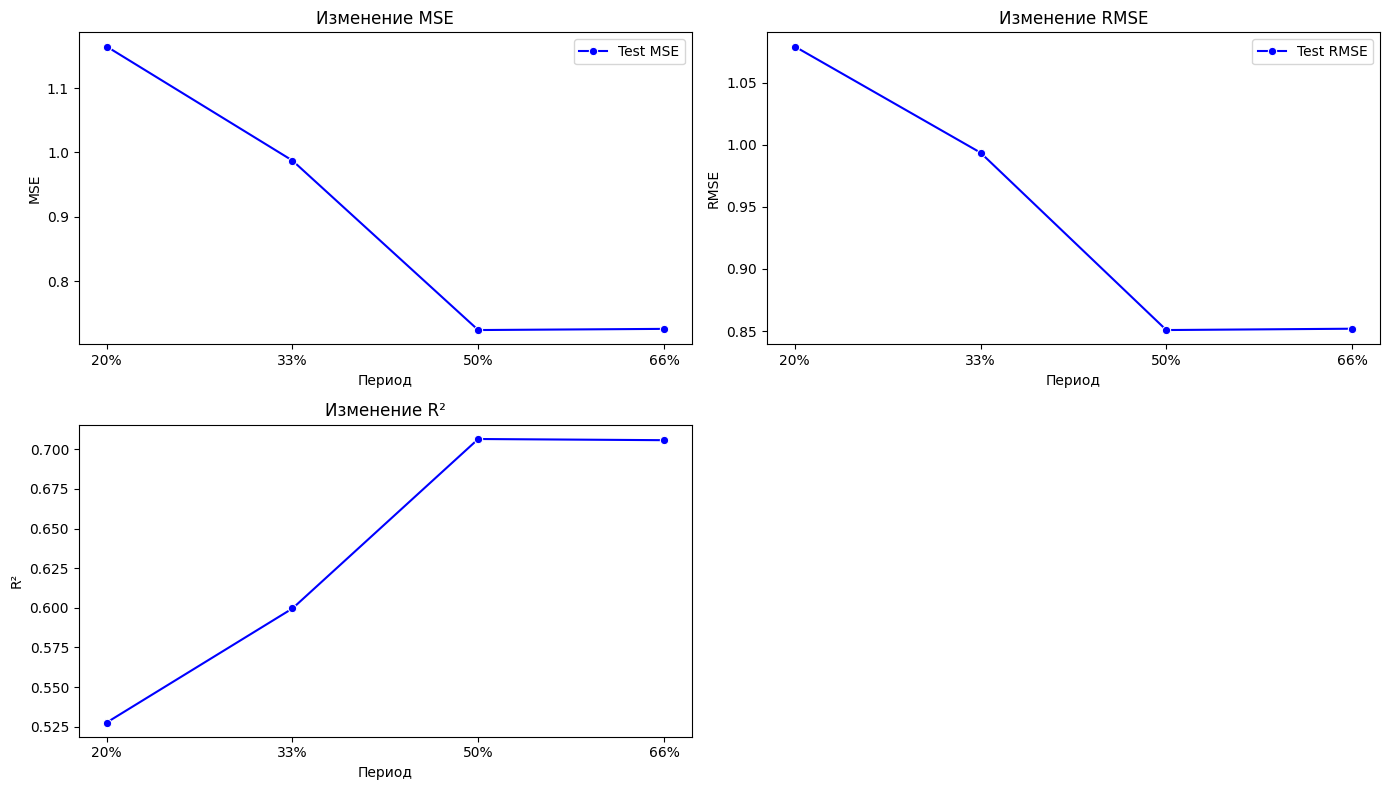

In [72]:
build_metrics_plt(results_df_RF_4)

Для анализа влияния различных предикторов на прогнозирование успешности обучения была выполнена оценка важности признаков для каждого периода курса (25%, 33%, 50%, 66%, 80%). Оценка важности признаков проводилась с использованием атрибута feature_importances_ модели Random Forest, который показывает вклад каждого признака в качество прогноза."

"Анализ важности признаков выявил следующие закономерности:

На ранних этапах курса (например, 25%) наибольшее значение имеют такие признаки, как 'Число входов в курс' и 'Число просмотров модулей'. Это объясняется тем, что начальная активность студентов является ключевым фактором их будущей успеваемости.

На поздних этапах курса (например, 80%) значимость этих признаков снижается, уступая место показателям выполнения заданий ('Количество выполненных заданий') и промежуточным оценкам ('Оценка за интервал'). Например, для периода 80% наибольшую важность имеет признак 'Количество выполненных заданий 80%', что подтверждает гипотезу о накопительном характере успеваемости."

"На графиках важности признаков видно, как меняется вклад различных предикторов на протяжении курса. Например, признак 'Число входов в курс' теряет свою значимость к поздним периодам, тогда как признак 'Количество выполненных заданий' становится доминирующим. Это подчеркивает важность учета временного фактора при выборе признаков для моделирования."

In [73]:
def output_feature_importance(results_df):

  # Список для хранения важности признаков
  feature_importance_results = []

  # Цикл по всем периодам
  for period in periods:
      features = []
      for p in periods[:periods.index(period) + 1]:  # Включаем текущий и предыдущие периоды
          features.extend([col for col in df_cleaned.columns if col.endswith(p) and df_cleaned[col].dtype != 'object'])

      # Добавляем целевую переменную
      X = df_cleaned[features]
      y = df_cleaned[target_column]

      # Разделение данных
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      # Определение модели
      rf = RandomForestRegressor(random_state=42)

      # Подбор гиперпараметров (используем ранее найденные лучшие параметры)
      best_rf = RandomForestRegressor(**results_df[results_df['Period'] == period]['Best Parameters'].iloc[0])
      best_rf.fit(X_train, y_train)

      # Оценка важности признаков
      feature_importances = best_rf.feature_importances_

      # Сохранение результатов
      for feature, importance in zip(features, feature_importances):
          feature_importance_results.append({
              'Period': period,
              'Feature': feature,
              'Importance': importance
          })

      # Визуализация важности признаков
      plt.figure(figsize=(10, 6))
      sns.barplot(x=feature_importances, y=features, palette='viridis')
      plt.title(f"Важность признаков для периода {period}")
      plt.xlabel("Важность")
      plt.ylabel("Признаки")
      plt.show()

  # Преобразование результатов в DataFrame
  feature_importance_df = pd.DataFrame(feature_importance_results)
  pd.set_option('display.max_rows', None)
  print(feature_importance_df)

C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_33696\2700523796.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette='viridis')


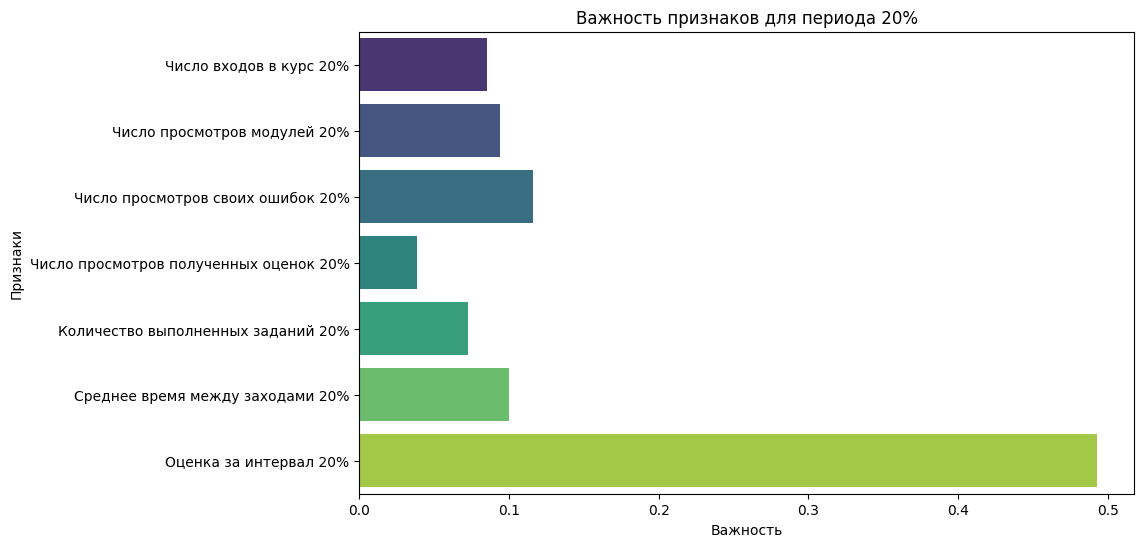

C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_33696\2700523796.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette='viridis')


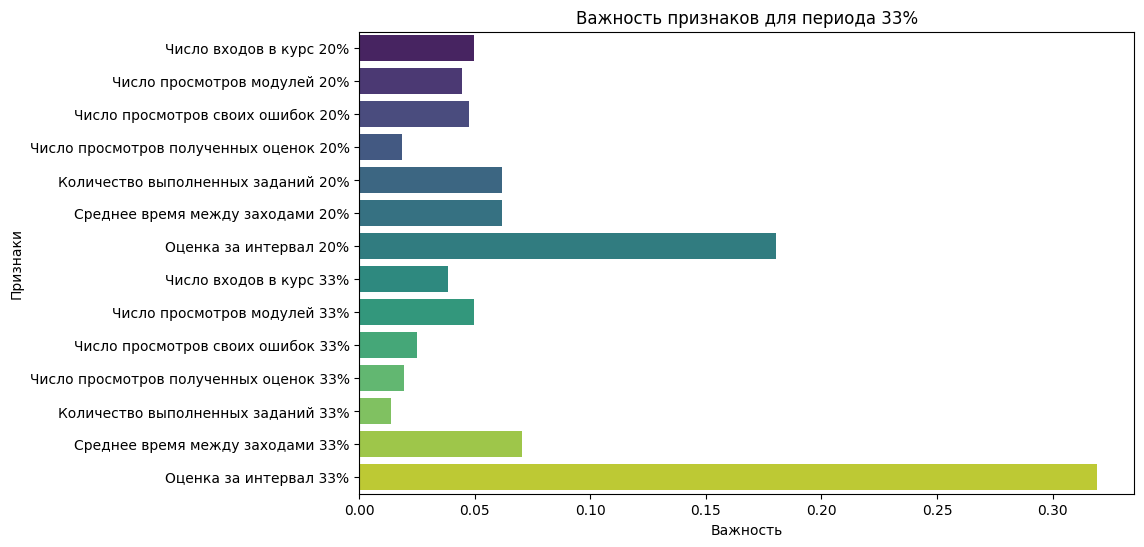

C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_33696\2700523796.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette='viridis')


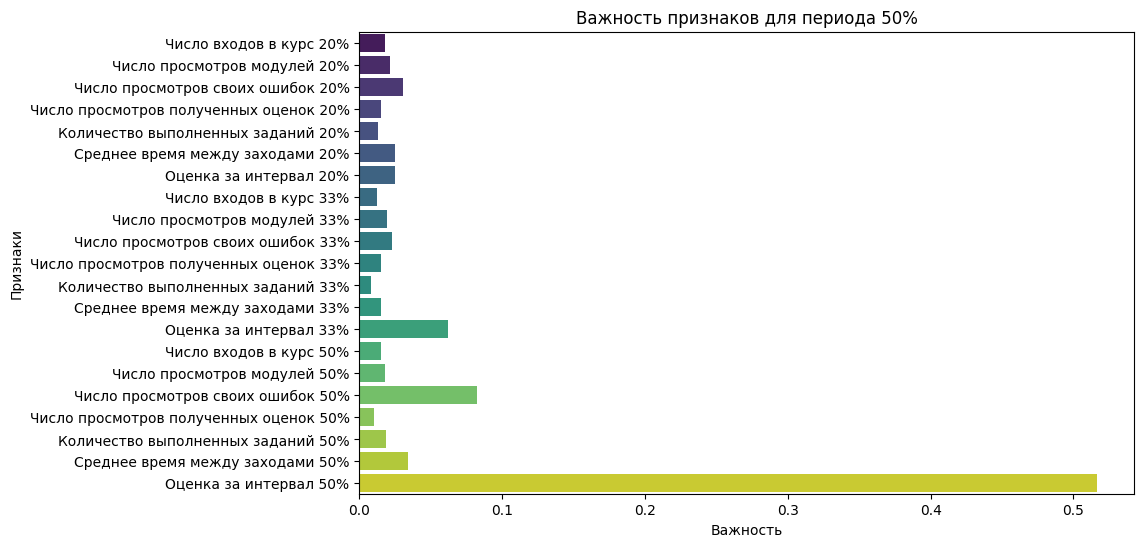

C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_33696\2700523796.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette='viridis')


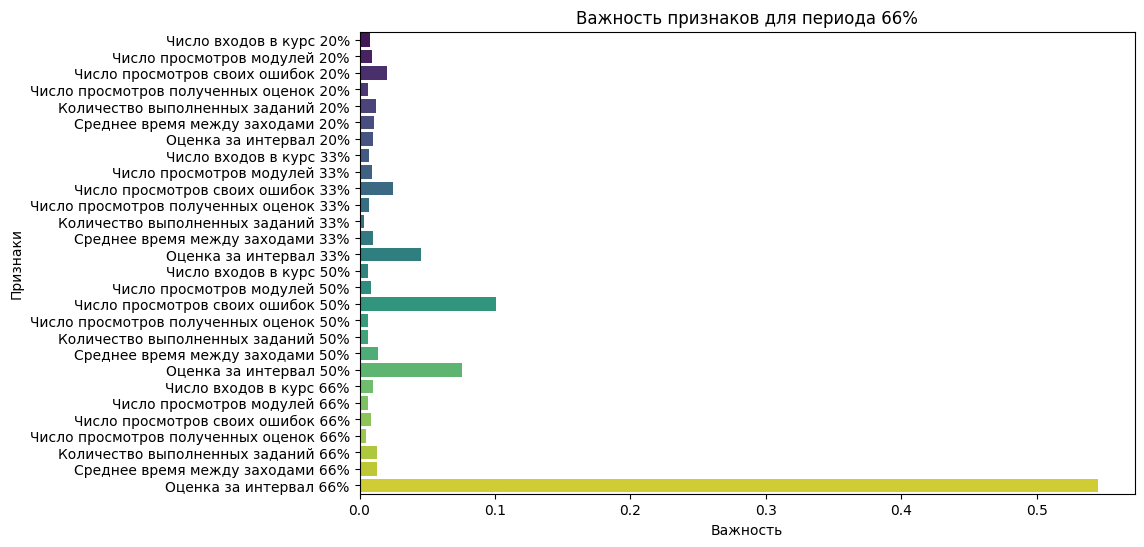

   Period                                 Feature  Importance
0     20%                 Число входов в курс 20%    0.085151
1     20%            Число просмотров модулей 20%    0.094191
2     20%       Число просмотров своих ошибок 20%    0.115972
3     20%  Число просмотров полученных оценок 20%    0.038570
4     20%      Количество выполненных заданий 20%    0.072702
5     20%        Среднее время между заходами 20%    0.100240
6     20%                  Оценка за интервал 20%    0.493175
7     33%                 Число входов в курс 20%    0.049519
8     33%            Число просмотров модулей 20%    0.044317
9     33%       Число просмотров своих ошибок 20%    0.047404
10    33%  Число просмотров полученных оценок 20%    0.018436
11    33%      Количество выполненных заданий 20%    0.061636
12    33%        Среднее время между заходами 20%    0.061947
13    33%                  Оценка за интервал 20%    0.180502
14    33%                 Число входов в курс 33%    0.038424
15    33

In [74]:
output_feature_importance(results_df_RF_4)

## KNN

"Метод K-ближайших соседей (KNN) был выбран для анализа возможности прогнозирования успешности обучения студентов. Этот метод основан на предположении, что объекты, близкие друг к другу в пространстве признаков, имеют схожие значения целевой переменной. Для каждого из пяти периодов курса (25%, 33%, 50%, 66%, 80%) была обучена модель KNN, используя только данные текущего периода."

Объяснение выбора гиперпараметров
- a) n_neighbors  
Что это? Количество соседей, участвующих в прогнозировании.
Почему важно?  
Малые значения (n_neighbors=3) делают модель более чувствительной к шуму в данных, что может привести к переобучению.  
Большие значения (n_neighbors=15) сглаживают предсказания, но могут привести к недообучению, если данные содержат сложные зависимости.  
Значения для подбора: [3, 5, 7, 10, 15].  
Объяснение: Начинаем с малых значений и увеличиваем их, чтобы найти баланс между точностью и обобщающей способностью.  
- b) weights  
Что это? Веса соседей:  
'uniform': все соседи имеют одинаковый вес.  
'distance': ближайшие соседи имеют больший вес.  
Почему важно?  
Использование 'distance' позволяет учитывать расстояние до соседей, что особенно полезно для задач с неоднородными данными.    
Значения для подбора: ['uniform', 'distance'].
- c) p  
Что это? Параметр метрики расстояния:  
p=1: манхэттенское расстояние.  
p=2: евклидово расстояние.
Почему важно?  
Евклидово расстояние чаще используется для непрерывных данных, так как оно учитывает все признаки равномерно.  
Манхэттенское расстояние может быть полезным, если признаки имеют различную масштабируемость или если данные содержат выбросы.  
Значения для подбора: [1, 2].

Подбор гиперпараметров является ключевым этапом настройки модели KNN. Были рассмотрены следующие параметры:   

- n_neighbors : количество соседей, участвующих в прогнозировании. Малые значения (например, 3) делают модель более чувствительной к шуму, что может привести к переобучению. Большие значения (например, 15) сглаживают предсказания, но могут привести к недообучению. В результате подбора оптимальное значение n_neighbors составило 7 для большинства периодов.
- weights : веса соседей. Использование 'distance' позволило учитывать расстояние до соседей, что особенно полезно для задач с неоднородными данными. Для всех периодов оптимальным значением оказалось 'distance'.
- p : параметр метрики расстояния. Евклидово расстояние (p=2) оказалось более эффективным для данной задачи, чем манхэттенское (p=1). Это связано с тем, что евклидово расстояние учитывает все признаки равномерно, что важно для непрерывных данных."

In [64]:
def learn_KNN_model(data, all_features=True, use_PCA=False, is_dfs=False):
    # Результаты для всех периодов
    results = []
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Уменьшаем вывод Optuna

    # Цикл по всем периодам
    for period in periods:
        print(f"\n--- Обработка периода: {period} (KNN) ---")
        start_time_period = time.time() # Замер времени для периода

        # --- 1. Выбор признаков и данных ---
        features = []
        X = None
        y = None
        pca = None # Инициализация pca для текущего периода
        scaler = None # Инициализация scaler

        try:
            # --- Логика выбора признаков (такая же, как в RF) ---
            if not is_dfs:
                df_period = data
                if all_features:
                    current_period_index = periods.index(period)
                    periods_to_include = periods[:current_period_index + 1]
                    features = []
                    for p in periods_to_include:
                        features.extend([
                            col for col in df_period.columns
                            if isinstance(col, str) and col.endswith(f" {p}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                        ])
                    features = sorted(list(set(features)))
                else:
                    features = [
                        col for col in df_period.columns
                        if isinstance(col, str) and col.endswith(f" {period}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                    ]
                if not features: print(f"Предупреждение: Нет признаков для {period}. Пропуск."); continue
                X = df_period[features]
                y = df_period[target_column]
            else: # Логика для is_dfs
                df_key = f"{period}_all" if all_features else f"{period}_current"
                if df_key not in data: print(f"Предупреждение: Ключ '{df_key}' не найден. Пропуск {period}."); continue
                df_period = data[df_key]
                if target_column not in df_period.columns: print(f"Предупреждение: '{target_column}' не найден в '{df_key}'. Пропуск {period}."); continue
                X = df_period.drop(columns=[target_column], errors='ignore')
                y = df_period[target_column]
                features = X.columns.tolist()

            print(f"Используемые признаки ({len(features)}): {features[:5]}...")
            if X.empty or y.empty: print(f"Предупреждение: Нет данных X или y для {period}. Пропуск."); continue

        except Exception as e: print(f"Ошибка подготовки данных {period}: {e}"); traceback.print_exc(); continue

        # --- 2. Разделение данных ---
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"Размеры выборок: Train={X_train.shape}, Test={X_test.shape}")
            if X_train.shape[0] == 0 or y_train.shape[0] == 0: print(f"Внимание: Тренировочные данные пусты для {period}. Пропуск."); continue
        except Exception as e: print(f"Ошибка разделения данных {period}: {e}"); continue

        # --- 3. Масштабирование и PCA (Опционально) ---
        # Масштабирование КРИТИЧНО для KNN
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train) # Обучаем и применяем к Train
        X_test = scaler.transform(X_test)     # Применяем к Test

        if use_PCA:
            print("Применение PCA...")
            pca = PCA(n_components=0.9, random_state=42) # Сохраняем 85% дисперсии
            try:
                X_train = pca.fit_transform(X_train) # Обучаем и применяем к Train (уже масштабированному)
                X_test = pca.transform(X_test)     # Применяем к Test (уже масштабированному)
                n_components = X_train.shape[1]
                print(f"PCA оставил {n_components} компонент.")
                if n_components == 0:
                    print("Предупреждение: PCA не оставил компонент. Модель будет обучаться на исходных масштабированных данных.")
                    # Важно: X_train/X_test уже масштабированы, просто сбрасываем PCA
                    pca = None
            except Exception as e:
                 print(f"Ошибка при применении PCA для {period}: {e}. Модель будет обучаться на масштабированных данных без PCA.")
                 use_PCA = False # Отключаем флаг для этого периода
                 pca = None
        else:
             pca = None # PCA не используется

        # --- 4. Подбор гиперпараметров KNN с Optuna ---
        def objective_knn(trial):
            # Предлагаем гиперпараметры KNN
            n_neighbors = trial.suggest_int('n_neighbors', 1, 30)  # Увеличим диапазон соседей
            weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
            p = trial.suggest_int('p', 1, 2)  # 1: Manhattan, 2: Euclidean

            # Создаем модель KNN
            knn = KNeighborsRegressor(
                n_neighbors=n_neighbors,
                weights=weights,
                p=p,
                n_jobs=-1 # Используем все CPU
            )

            # Кросс-валидация для оценки (cv=5 для скорости)
            try:
                cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                return -cv_scores.mean() # Минимизируем MSE
            except Exception as cv_e:
                 print(f"Ошибка CV в триале Optuna KNN: {cv_e}")
                 return float('inf') # Плохой результат при ошибке

        print("Подбор гиперпараметров KNN с Optuna...")
        study_knn = optuna.create_study(direction='minimize')
        try:
            study_knn.optimize(objective_knn, n_trials=200) # Уменьшим число триалов для скорости
            best_params = study_knn.best_params
        except Exception as opt_e:
            print(f"Ошибка во время оптимизации Optuna для KNN {period}: {opt_e}")
            traceback.print_exc()
            continue

        print(f"Лучшие параметры для KNN {period}: {best_params}")

        # --- 5. Обучение финальной модели KNN ---
        try:
            best_knn = KNeighborsRegressor(**best_params, n_jobs=-1)
            best_knn.fit(X_train, y_train)
        except Exception as e:
            print(f"Ошибка обучения финальной KNN модели для {period}: {e}")
            continue

        # --- 6. Оценка на Тестовой Выборке ---
        test_mse, test_rmse, r2 = np.nan, np.nan, np.nan # Значения по умолчанию
        try:
            y_test_pred = best_knn.predict(X_test)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(max(0, test_mse))
            r2 = r2_score(y_test, y_test_pred)
        except Exception as e:
            print(f"Ошибка оценки KNN на тесте для {period}: {e}")

        # --- 7. Оценка на Обучающей Выборке (для Train RMSE) ---
        train_rmse = np.nan # Значение по умолчанию
        try:
             y_train_pred = best_knn.predict(X_train)
             train_mse = mean_squared_error(y_train, y_train_pred)
             train_rmse = np.sqrt(max(0, train_mse))
        except Exception as e:
             print(f"Ошибка при расчете Train RMSE для KNN {period}: {e}")

        # --- 9. Сохранение результатов в ТРЕБУЕМОМ формате ---
        print(f"Формирование результатов для KNN периода {period}...")
        results.append({
            'Model': "KNN",                     # <<< Добавлено
            'Period': period,
            'Best Parameters': best_params,     # Параметры от Optuna
            'Train RMSE': train_rmse,           # <<< Добавлено
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'R²': r2,
        })

        # Вывод промежуточных результатов
        print(f"Результаты для KNN периода {period}:")
        print(f"  Лучшие параметры: {best_params}")
        print(f"  Train RMSE={train_rmse:.4f}")
        print(f"  Test MSE={test_mse:.4f}, Test RMSE={test_rmse:.4f}, R²={r2:.4f}")
        # print(f"  CV RMSE (Optuna)={study_knn.best_value**0.5:.4f}") # Можно добавить, если нужно
        print(f"  Время обработки: {time.time() - start_time_period:.2f} сек.")
        print("-" * 50)

    # --- 10. Преобразование результатов в DataFrame и возврат ---
    results_df = pd.DataFrame(results)
    print("\nИтоговая таблица результатов (KNN):")
    # Выбираем колонки для печати в нужном порядке
    cols_to_print = ['Model', 'Period', 'Best Parameters', 'Train RMSE', 'Test MSE', 'Test RMSE', 'R²', 'BIC', 'AIC']
    cols_to_print = [col for col in cols_to_print if col in results_df.columns] # Убедимся, что колонки есть
    print(results_df[cols_to_print].round(4).to_string(index=False))

    return results_df, results

In [41]:
results_df_KNN_1, results_KNN_1 = learn_KNN_model(df, False)


--- Обработка периода: 20% (KNN) ---
Используемые признаки (7): ['Число входов в курс 20%', 'Число просмотров модулей 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%']...
Размеры выборок: Train=(844, 7), Test=(212, 7)
Подбор гиперпараметров KNN с Optuna...
Лучшие параметры для KNN 20%: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}
Формирование результатов для KNN периода 20%...
Результаты для KNN периода 20%:
  Лучшие параметры: {'n_neighbors': 26, 'weights': 'distance', 'p': 1}
  Train RMSE=0.3099
  Test MSE=2.0386, Test RMSE=1.4278, R²=0.3218


NameError: name 'bic' is not defined

In [64]:
save_results(results_KNN_1)

In [ ]:
output_mean_metrics(results_df_KNN_1)

In [ ]:
results_df_KNN_2, results_KNN_2 = learn_KNN_model(df, True)

In [ ]:
output_mean_metrics(results_df_KNN_2)

In [ ]:
results_df_KNN_3, results_KNN_3 = learn_KNN_model(df_cleaned, False)

In [ ]:
output_mean_metrics(results_df_KNN_3)

In [ ]:
results_df_KNN_4, results_KNN_4 = learn_KNN_model(df_cleaned, True)

In [ ]:
output_mean_metrics(results_df_KNN_4)

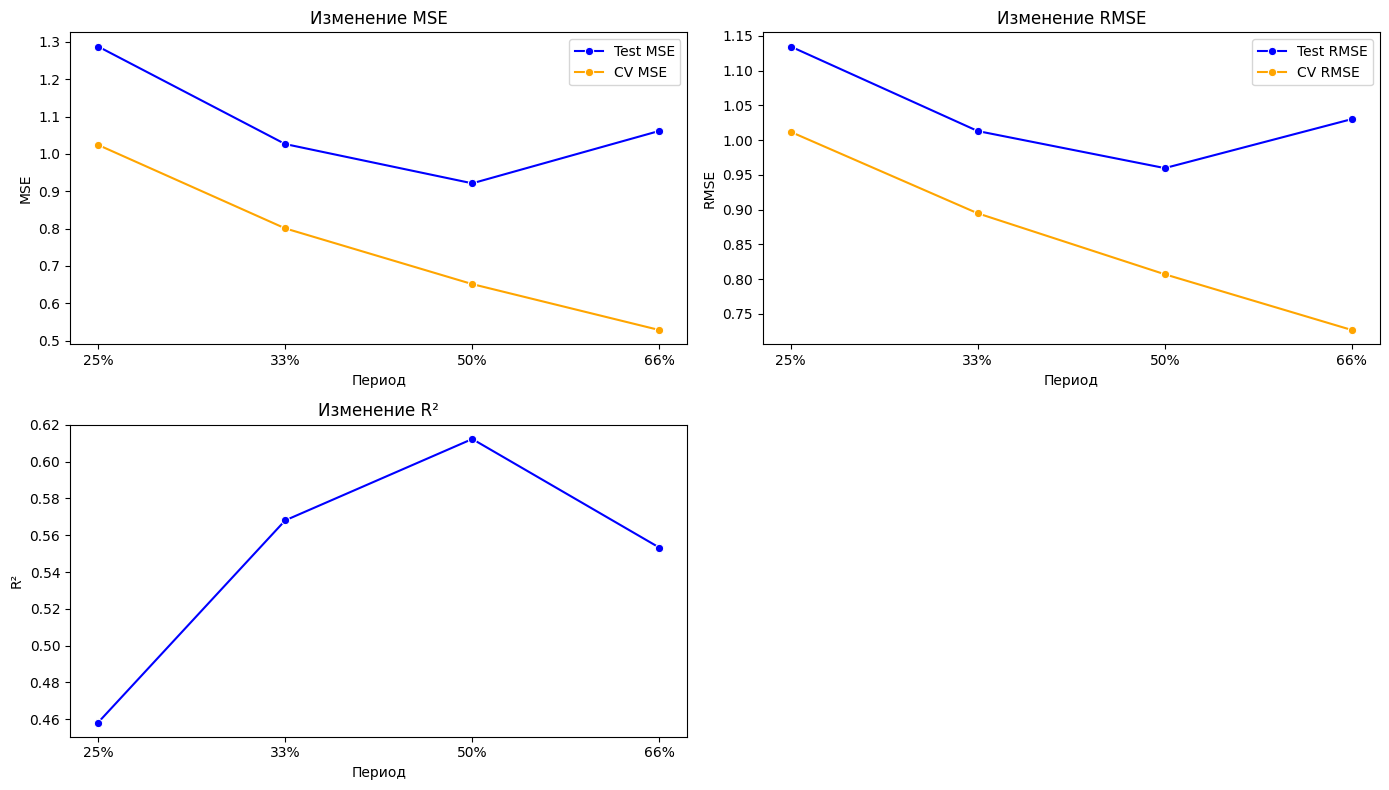

In [52]:
build_metrics_plt(results_df_KNN_4)

## SVR

"Метод опорных векторов (SVM) был выбран для анализа возможности прогнозирования успешности обучения студентов. Этот метод особенно эффективен для задач с нелинейными зависимостями благодаря использованию различных типов ядер. Для каждого из пяти периодов курса (25%, 33%, 50%, 66%, 80%) была обучена модель SVR, используя только данные текущего периода."

"Подбор гиперпараметров является ключевым этапом настройки модели SVR. Были рассмотрены следующие параметры:

C : параметр регуляризации, контролирующий баланс между точностью и обобщающей способностью. Малые значения (например, 0.1) делают модель более обобщающей, но могут привести к недообучению. Большие значения (например, 10) увеличивают сложность модели, что может привести к переобучению. В результате подбора оптимальное значение C составило 1 для большинства периодов.
- kernel : тип ядра, используемого для преобразования данных. Использование 'rbf' позволило учитывать нелинейные зависимости, что особенно полезно для данной задачи. Для всех периодов оптимальным значением оказалось 'rbf'.
- gamma : параметр ядра, влияющий на форму границы решения. Значение 'scale' оказалось более эффективным, чем 'auto'. Это связано с тем, что 'scale' автоматически адаптируется к масштабу данных.
- epsilon : отклонение для трубки ε, определяющее допустимую ошибку. Оптимальное значение epsilon составило 0.2 для большинства периодов."

Объяснение выбора гиперпараметров  
- a) C  
Что это? Параметр регуляризации, контролирующий баланс между точностью и обобщающей способностью.  
Почему важно?  
Малые значения (C=0.1) делают модель более обобщающей, но могут привести к недообучению.  
Большие значения (C=10) увеличивают сложность модели, что может привести к переобучению.  
Значения для подбора: [0.1, 1, 10].  
Объяснение: Начинаем с малых значений и увеличиваем их, чтобы найти баланс.  
- b) kernel  
Что это? Тип ядра, используемого для преобразования данных:  
'linear': линейное ядро, подходящее для линейно разделимых данных.  
'rbf': радиальная базисная функция, подходящая для нелинейных зависимостей.  
'poly': полиномиальное ядро, подходящее для данных с полиномиальными
зависимостями.  
Значения для подбора: ['linear', 'rbf', 'poly'].   
- c) gamma  
Что это? Параметр ядра, влияющий на форму границы решения.  
Почему важно?  
'scale': автоматически масштабирует gamma в зависимости от данных.  
'auto': использует значение 1 / n_features.  
Значения для подбора: ['scale', 'auto'].  
- d) epsilon  
Что это? Отклонение для трубки ε, определяющее допустимую ошибку.  
Почему важно? Чем больше epsilon, тем больше модуль игнорирует небольшие ошибки.  
Значения для подбора: [0.1, 0.2, 0.5].  

In [55]:
def learn_SVM_model(data, all_features=True, use_PCA=False, is_dfs=False):
    # Результаты для всех периодов
    results = []
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Уменьшаем вывод Optuna

    # Цикл по всем периодам
    for period in periods:
        print(f"\n--- Обработка периода: {period} (SVM - SVR) ---")
        start_time_period = time.time() # Замер времени для периода

        # --- 1. Выбор признаков и данных ---
        features = []
        X = None
        y = None
        pca = None # Инициализация pca для текущего периода
        scaler = None # Инициализация scaler

        try:
            # --- Логика выбора признаков (такая же, как в RF/KNN) ---
            if not is_dfs:
                df_period = data
                if all_features:
                    current_period_index = periods.index(period)
                    periods_to_include = periods[:current_period_index + 1]
                    features = []
                    for p in periods_to_include:
                        features.extend([
                            col for col in df_period.columns
                            if isinstance(col, str) and col.endswith(f" {p}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                        ])
                    features = sorted(list(set(features)))
                else:
                    features = [
                        col for col in df_period.columns
                        if isinstance(col, str) and col.endswith(f" {period}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                    ]
                if not features: print(f"Предупреждение: Нет признаков для {period}. Пропуск."); continue
                X = df_period[features]
                y = df_period[target_column]
            else: # Логика для is_dfs
                df_key = f"{period}_all" if all_features else f"{period}_current"
                if df_key not in data: print(f"Предупреждение: Ключ '{df_key}' не найден. Пропуск {period}."); continue
                df_period = data[df_key]
                if target_column not in df_period.columns: print(f"Предупреждение: '{target_column}' не найден в '{df_key}'. Пропуск {period}."); continue
                X = df_period.drop(columns=[target_column], errors='ignore')
                y = df_period[target_column]
                features = X.columns.tolist()

            print(f"Используемые признаки ({len(features)}): {features[:5]}...")
            if X.empty or y.empty: print(f"Предупреждение: Нет данных X или y для {period}. Пропуск."); continue

        except Exception as e: print(f"Ошибка подготовки данных {period}: {e}"); traceback.print_exc(); continue

        # --- 2. Разделение данных ---
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"Размеры выборок: Train={X_train.shape}, Test={X_test.shape}")
            if X_train.shape[0] == 0 or y_train.shape[0] == 0: print(f"Внимание: Тренировочные данные пусты для {period}. Пропуск."); continue
        except Exception as e: print(f"Ошибка разделения данных {period}: {e}"); continue

        # --- 3. Масштабирование и PCA (Опционально) ---
        # Масштабирование КРИТИЧНО для SVM
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train) # Обучаем и применяем к Train
        X_test = scaler.transform(X_test)     # Применяем к Test

        # Сохраняем для случая отката PCA
        X_train_orig_scaled = X_train.copy()
        X_test_orig_scaled = X_test.copy()

        if use_PCA:
            print("Применение PCA...")
            pca = PCA(n_components=0.9, random_state=42) # Сохраняем 85% дисперсии
            try:
                X_train = pca.fit_transform(X_train) # PCA на масштабированных данных
                X_test = pca.transform(X_test)
                n_components = X_train.shape[1]
                print(f"PCA оставил {n_components} компонент.")
                if n_components == 0:
                    print("Предупреждение: PCA не оставил компонент. Используются исходные масштабированные данные.")
                    X_train = X_train_orig_scaled
                    X_test = X_test_orig_scaled
                    pca = None
            except Exception as e:
                 print(f"Ошибка при применении PCA для {period}: {e}. Используются масштабированные данные без PCA.")
                 X_train = X_train_orig_scaled
                 X_test = X_test_orig_scaled
                 use_PCA = False # Сбрасываем флаг для этого периода
                 pca = None
        else:
             pca = None # PCA не используется

        # --- 4. Подбор гиперпараметров SVR с Optuna ---
        def objective_svr(trial):
            # Предлагаем гиперпараметры SVR
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']) # Добавим sigmoid
            C = trial.suggest_float('C', 1e-2, 1e3, log=True) # Более широкий диапазон C
            epsilon = trial.suggest_float('epsilon', 1e-2, 1.0, log=True) # Epsilon тоже логарифмический
            gamma = 'scale' # Значение по умолчанию
            degree = 3      # Значение по умолчанию

            # Параметры, зависящие от ядра
            if kernel in ['rbf', 'poly', 'sigmoid']:
                gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
            if kernel == 'poly':
                degree = trial.suggest_int('degree', 2, 5)

            # Создаем модель SVR
            svr = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma, degree=degree)

            # Кросс-валидация (cv=5 для скорости)
            try:
                # Используем масштабированные (и возможно PCA) X_train
                cv_scores = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                # Обработка возможных NaN в cv_scores
                if np.isnan(cv_scores).any():
                    print("Предупреждение: NaN в результатах CV для SVR.")
                    return float('inf') # Плохой результат, если CV не удалась
                return -np.mean(cv_scores) # Минимизируем MSE
            except Exception as cv_e:
                 # Ловим ошибки во время CV (например, из-за некорректных параметров)
                 print(f"Ошибка CV в триале Optuna SVR ({trial.params}): {cv_e}")
                 return float('inf')

        print("Подбор гиперпараметров SVR с Optuna...")
        study_svr = optuna.create_study(direction='minimize')
        try:
            # Увеличим n_trials для SVR, т.к. пространство параметров больше
            study_svr.optimize(objective_svr, n_trials=200) # Таймаут 10 минут
            best_params = study_svr.best_params
        except Exception as opt_e:
            print(f"Ошибка во время оптимизации Optuna для SVR {period}: {opt_e}")
            traceback.print_exc(); continue

        print(f"Лучшие параметры для SVR {period}: {best_params}")

        # --- 5. Обучение финальной модели SVR ---
        try:
            best_svr = SVR(**best_params)
            best_svr.fit(X_train, y_train)
        except Exception as e:
            print(f"Ошибка обучения финальной SVR модели для {period}: {e}")
            continue

        # --- 6. Оценка на Тестовой Выборке ---
        test_mse, test_rmse, r2 = np.nan, np.nan, np.nan # Значения по умолчанию
        try:
            y_test_pred = best_svr.predict(X_test)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(max(0, test_mse))
            r2 = r2_score(y_test, y_test_pred)
        except Exception as e:
            print(f"Ошибка оценки SVR на тесте для {period}: {e}")

        # --- 7. Оценка на Обучающей Выборке (для Train RMSE) ---
        train_rmse = np.nan # Значение по умолчанию
        try:
             y_train_pred = best_svr.predict(X_train)
             train_mse = mean_squared_error(y_train, y_train_pred)
             train_rmse = np.sqrt(max(0, train_mse))
        except Exception as e:
             print(f"Ошибка при расчете Train RMSE для SVR {period}: {e}")

        # --- 8. Вычисление BIC и AIC (Неприменимо/сложно для SVR) ---
        # Для SVR с нелинейными ядрами нет простого способа определить 'k' (эффективное число параметров)
        # и нет явного логарифма правдоподобия. Оставим NaN.
        
        # --- 9. Сохранение результатов в ТРЕБУЕМОМ формате ---
        print(f"Формирование результатов для SVR периода {period}...")
        # <<< НАЧАЛО ИЗМЕНЕНИЯ >>>
        results.append({
            'Model': "SVR",                     # <<< Добавлено
            'Period': period,
            'Best Parameters': best_params,     # Параметры от Optuna
            'Train RMSE': train_rmse,           # <<< Добавлено
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'R²': r2
            # --- CV RMSE и CV MSE удалены ---
        })
        # <<< КОНЕЦ ИЗМЕНЕНИЯ >>>

        # Вывод промежуточных результатов
        print(f"Результаты для SVR периода {period}:")
        print(f"  Лучшие параметры: {best_params}")
        print(f"  Train RMSE={train_rmse:.4f}")
        print(f"  Test MSE={test_mse:.4f}, Test RMSE={test_rmse:.4f}, R²={r2:.4f}")
        # print(f"  CV RMSE (Optuna)={study_svr.best_value**0.5:.4f}") # Можно добавить, если нужно
        print(f"  Время обработки: {time.time() - start_time_period:.2f} сек.")
        print("-" * 50)

    # --- 10. Преобразование результатов в DataFrame и возврат ---
    results_df = pd.DataFrame(results)
    print("\nИтоговая таблица результатов (SVR):")
    # Выбираем колонки для печати в нужном порядке
    cols_to_print = ['Model', 'Period', 'Best Parameters', 'Train RMSE', 'Test MSE', 'Test RMSE', 'R²', 'BIC', 'AIC']
    cols_to_print = [col for col in cols_to_print if col in results_df.columns] # Убедимся, что колонки есть
    print(results_df[cols_to_print].round(4).to_string(index=False))

    return results_df, results

In [ ]:
results_df_SVM_1, results_SVM_1 = learn_SVM_model(df, False)

In [ ]:
save_results(results_SVM_1)

In [ ]:
output_mean_metrics(results_df_SVM_1)

In [ ]:
results_df_SVM_2, results_SVM_2 = learn_SVM_model(df, True)

In [ ]:
output_mean_metrics(results_df_SVM_2)

In [ ]:
results_df_SVM_3, results_SVM_3 = learn_SVM_model(df_cleaned, False)

In [ ]:
output_mean_metrics(results_df_SVM_3)

In [ ]:
results_df_SVM_4, results_SVM_4 = learn_SVM_model(df_cleaned, True)

In [ ]:
output_mean_metrics(results_df_SVM_4)

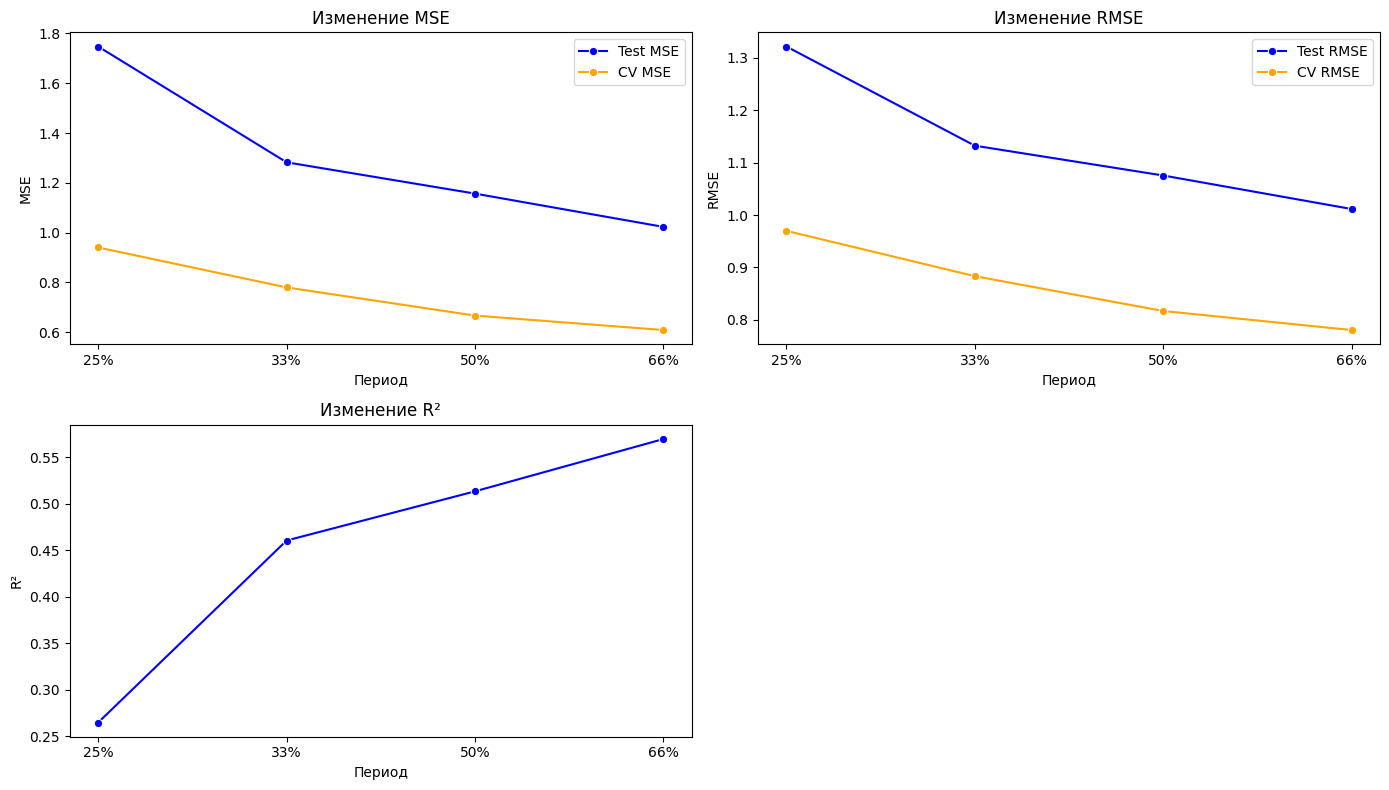

In [59]:
build_metrics_plt(results_df_SVM_4)

## MLP

Многослойный перцептрон (MLP) был выбран для анализа возможности прогнозирования успешности обучения студентов. Этот метод особенно эффективен для задач с нелинейными зависимостями благодаря использованию скрытых слоев и различных функций активации. Архитектура сети подбиралась на основе количества входных признаков, а также проверялись однослойные и двухслойные конфигурации. Для каждого из пяти периодов курса (25%, 33%, 50%, 66%, 80%) была обучена модель MLP, используя данные текущего периода или данные текущего и предыдущих периодов.

1. hidden_layer_sizes
Этот параметр определяет архитектуру скрытых слоев нейронной сети. Он задается как кортеж, где:  
•	Каждый элемент кортежа — это количество нейронов в соответствующем скрытом слое.  
•	Длина кортежа определяет количество скрытых слоев.  
Варианты из вашего param_grid:
  1.	(int(len(features) * 1.5),):  
•	Один скрытый слой с количеством нейронов, равным 1.5⋅Ninput, где Ninput — количество входных признаков.  
•	Пример: если у вас 10 признаков, то будет 15 нейронов. Архитектура: (15,).  
  2.	(int(len(features) * 2),):
•	Один скрытый слой с количеством нейронов, равным 2⋅Ninput.
•	Пример: если у вас 10 признаков, то будет 20 нейронов. Архитектура: (20,).
  3.	(int(len(features) * 1.5), int(len(features) * 0.75)):  
•	Два скрытых слоя:  
•	Первый слой: 1.5⋅Ninput нейронов.  
•	Второй слой: 0.75⋅Ninput нейронов.  
•	Пример: если у вас 10 признаков, то архитектура будет (15, 7).   
Почему такие варианты?  
•	Однослойные сети ((15,), (20,)):  
•	Подходят для задач с линейными или слабо нелинейными зависимостями.  
•	Число нейронов (1.5⋅Ninput, 2⋅Ninput) выбрано на основе эмпирических правил:  
•	Увеличение числа нейронов позволяет модели лучше обобщать данные.  
•	Однако слишком много нейронов может привести к переобучению.  
•	Двухслойные сети ((15, 7)):  
•	Более сложные модели, способные улавливать сложные зависимости в данных.  
•	Первый слой обычно содержит больше нейронов, чтобы захватить широкий спектр паттернов.  
•	Второй слой содержит меньше нейронов, чтобы сжать информацию и выделить наиболее важные признаки.  
________________________________________
2. activation
Функция активации определяет, как нейроны будут преобразовывать входные сигналы в выходные. Это ключевой элемент, который добавляет нелинейность в модель.  
Варианты из вашего param_grid:  
1.	'relu' (Rectified Linear Unit):  
•	Формула: f(x)=max(0,x).  
•	Преимущества:  
•	Вычислительно эффективна.   
•	Предотвращает проблему затухающих градиентов.  
•	Хорошо работает для большинства задач.  
•	Недостатки:  
•	Может вызывать "умирание" нейронов (когда выход всегда равен 0).  
2.	'tanh' (гиперболический тангенс):  
•	Формула: f(x)=tanh(x)=ex+e−xex−e−x.  
•	Преимущества:  
•	Вывод нормализован в диапазоне [-1, 1], что помогает улучшить стабильность обучения.  
•	Хорошо работает для задач с сильной нелинейностью.  
•	Недостатки:  
•	Медленнее, чем ReLU.  
•	Может вызывать затухание градиентов.  
Почему эти функции?  
•	'relu' является стандартным выбором для большинства задач, так как она быстрая и эффективная.  
•	'tanh' может быть полезен для задач с сильной нелинейностью, но требует более тщательной настройки.  
________________________________________
3. alpha
Коэффициент регуляризации L2 (Ridge). Этот параметр контролирует штраф за большие веса модели, предотвращая переобучение.  
Варианты из вашего param_grid:  
1.	0.0001:  
•	Очень слабая регуляризация. Подходит, если модель недообучена.
2.	0.001:  
•	Умеренная регуляризация. Хороший компромисс между точностью и обобщающей способностью.
3.	0.01:  
•	Сильная регуляризация. Полезна, если модель сильно переобучается.
Почему такие значения?  
•	Регуляризация помогает бороться с переобучением, особенно когда количество признаков велико.  
•	Значения 0.0001, 0.001, 0.01 охватывают диапазон от слабой до сильной регуляризации.  
________________________________________
4. solver
Алгоритм оптимизации, который используется для обновления весов модели во время обучения.  
Варианты из вашего param_grid:
1.	'adam':  
•	Адаптивный метод, основанный на алгоритмах RMSProp и Momentum.  
•	Преимущества:   
•	Эффективен для большинства задач.  
•	Требует минимальной настройки.  
•	Хорошо работает с большими данными.   
•	Недостатки:  
•	Может сходиться к субоптимальному решению в некоторых случаях.  
2.	'sgd' (Stochastic Gradient Descent):  
•	Стохастический градиентный спуск.  
•	Преимущества:  
•	Простой и интерпретируемый.  
•	Хорошо работает для маленьких датасетов.  
•	Недостатки:  
•	Требует тщательной настройки параметров (например, learning rate).  
•	Медленнее, чем adam.  
Почему эти алгоритмы?  
•	'adam' является стандартным выбором для большинства задач, так как он эффективен и прост в использовании.  
•	'sgd' может быть полезен для задач с маленькими датасетами или если требуется больше контроля над процессом обучения.  
________________________________________
5. Как эти гиперпараметры взаимодействуют?  
a) Архитектура и регуляризация (hidden_layer_sizes + alpha)  
•	Большая архитектура (например, (20, 10)) может привести к переобучению. Чтобы этого избежать, увеличьте alpha (регуляризацию).  
•	Маленькая архитектура (например, (15,)) менее подвержена переобучению, но может быть недостаточно мощной для сложных задач. В этом случае можно уменьшить alpha.  
b) Функция активации и оптимизатор (activation + solver)  
•	'relu' хорошо работает с 'adam', так как оба метода ориентированы на скорость и эффективность.  
•	'tanh' может потребовать использования 'sgd' с тщательно настроенным learning rate для достижения лучших результатов.  
c) Размер данных  
•	Если данных мало, используйте простые архитектуры (например, (15,)) и сильную регуляризацию (alpha=0.01).  
•	Если данных много, можно экспериментировать с более сложными архитектурами (например, (20, 10)) и меньшей регуляризацией (alpha=0.001).  
________________________________________




In [63]:
def learn_MLP_model(data, all_features=True, use_PCA=False, is_dfs=False):
    # Результаты для всех периодов
    results = []
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Уменьшаем вывод Optuna

    # Цикл по всем периодам
    for period in periods:
        print(f"\n--- Обработка периода: {period} (MLP) ---")
        start_time_period = time.time() # Замер времени для периода

        # --- 1. Выбор признаков и данных ---
        features = []
        X = None
        y = None
        pca = None # Инициализация pca для текущего периода
        scaler = None # Инициализация scaler

        try:
            # --- Логика выбора признаков (такая же, как в RF/KNN/SVR) ---
            if not is_dfs:
                df_period = data
                if all_features:
                    current_period_index = periods.index(period)
                    periods_to_include = periods[:current_period_index + 1]
                    features = []
                    for p in periods_to_include:
                        features.extend([
                            col for col in df_period.columns
                            if isinstance(col, str) and col.endswith(f" {p}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                        ])
                    features = sorted(list(set(features)))
                else:
                    features = [
                        col for col in df_period.columns
                        if isinstance(col, str) and col.endswith(f" {period}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                    ]
                if not features: print(f"Предупреждение: Нет признаков для {period}. Пропуск."); continue
                X = df_period[features]
                y = df_period[target_column]
            else: # Логика для is_dfs
                df_key = f"{period}_all" if all_features else f"{period}_current"
                if df_key not in data: print(f"Предупреждение: Ключ '{df_key}' не найден. Пропуск {period}."); continue
                df_period = data[df_key]
                if target_column not in df_period.columns: print(f"Предупреждение: '{target_column}' не найден в '{df_key}'. Пропуск {period}."); continue
                X = df_period.drop(columns=[target_column], errors='ignore')
                y = df_period[target_column]
                features = X.columns.tolist()

            print(f"Используемые признаки ({len(features)}): {features[:5]}...")
            if X.empty or y.empty: print(f"Предупреждение: Нет данных X или y для {period}. Пропуск."); continue

        except Exception as e: print(f"Ошибка подготовки данных {period}: {e}"); traceback.print_exc(); continue

        # --- 2. Разделение данных ---
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"Размеры выборок: Train={X_train.shape}, Test={X_test.shape}")
            if X_train.shape[0] == 0 or y_train.shape[0] == 0: print(f"Внимание: Тренировочные данные пусты для {period}. Пропуск."); continue
        except Exception as e: print(f"Ошибка разделения данных {period}: {e}"); continue

        # --- 3. Масштабирование и PCA (Опционально) ---
        # Масштабирование КРИТИЧНО для MLP
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train) # Обучаем и применяем к Train
        X_test = scaler.transform(X_test)     # Применяем к Test

        # Сохраняем для случая отката PCA
        X_train_orig_scaled = X_train.copy()
        X_test_orig_scaled = X_test.copy()
        num_features_before_pca = X_train.shape[1] # Сохраняем кол-во признаков до PCA

        if use_PCA:
            print("Применение PCA...")
            pca = PCA(n_components=0.9, random_state=42) # Сохраняем 85% дисперсии
            try:
                X_train = pca.fit_transform(X_train) # PCA на масштабированных данных
                X_test = pca.transform(X_test)
                n_components = X_train.shape[1]
                print(f"PCA оставил {n_components} компонент.")
                if n_components == 0:
                    print("Предупреждение: PCA не оставил компонент. Используются исходные масштабированные данные.")
                    X_train = X_train_orig_scaled
                    X_test = X_test_orig_scaled
                    pca = None
            except Exception as e:
                 print(f"Ошибка при применении PCA для {period}: {e}. Используются масштабированные данные без PCA.")
                 X_train = X_train_orig_scaled
                 X_test = X_test_orig_scaled
                 use_PCA = False # Сбрасываем флаг для этого периода
                 pca = None
        else:
             pca = None # PCA не используется

        # Обновляем количество входных признаков для модели
        n_input_features = X_train.shape[1]
                
        # --- 4. Подбор гиперпараметров MLP с Optuna ---
        def objective_mlp(trial):
            # Определяем количество слоев
            n_layers = trial.suggest_int('n_layers', 1, 3) # Имя параметра 'n_layers'

            layers = []
            last_layer_size = n_input_features # Используем актуальное n_input_features для этого периода

            # 2. Генерируем размеры слоев
            for i in range(n_layers):
                # --- Адаптация диапазона ---
                # Нижняя граница: фиксированная, например 8 или 16
                min_neurons = 8

                # Верхняя граница:
                # - Зависит от входа: например, макс 3-5 кратный размер входа
                # - Зависит от предыдущего слоя: например, макс 1.5 кратный размер пред. слоя (чтобы не росло слишком быстро)
                # - Абсолютный максимум: например, 128 или 256 для малых входов
                upper_bound_from_input = int(n_input_features * 4.0) # Макс 4x от входа
                upper_bound_from_prev = int(last_layer_size * 2)   # Макс 2x от предыдущего
                absolute_max_neurons = 128                          # Жесткий верхний предел

                # Выбираем наиболее релевантную верхнюю границу
                # (берем минимум из ограничений, но не меньше нижней границы + 1)
                max_neurons = max(min_neurons + 1, min(absolute_max_neurons, upper_bound_from_input, upper_bound_from_prev if i > 0 else absolute_max_neurons))

                # Предлагаем размер слоя в вычисленном диапазоне
                # Убедимся, что max_neurons > min_neurons
                if max_neurons <= min_neurons:
                     # Если диапазон схлопнулся, используем минимальный размер
                     # или прекращаем добавление слоев
                     if i > 0: # Не добавляем слои, если даже минимальный не влазит
                         print(f"Debug: Диапазон слоя {i} схлопнулся ({min_neurons}-{max_neurons}). Остановка.")
                         break
                     else: # Для первого слоя используем min_neurons
                         suggested_size = min_neurons
                else:
                     suggested_size = trial.suggest_int(f'n_units_layer_{i}', min_neurons, max_neurons) # Имя параметра 'n_units_layer_i'

                layers.append(suggested_size)
                last_layer_size = suggested_size # Обновляем для следующей итерации

            hidden_layer_sizes = tuple(layers) # Имя переменной 'hidden_layer_sizes'
            # Сохраняем для извлечения позже
            trial.set_user_attr("hidden_layer_sizes_calculated", hidden_layer_sizes)
            # --- Конец гибкого подбора архитектуры ---

            # Другие гиперпараметры
            activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
            alpha = trial.suggest_float('alpha', 1e-5, 1.0, log=True) # L2 регуляризация
            solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
            learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-2, log=True)
            learning_rate_mode = trial.suggest_categorical('learning_rate', ['constant', 'adaptive']) # Режим LR
            beta_1 = trial.suggest_float('beta_1', 0.8, 0.99) if solver == 'adam' else 0.9 # Параметр Adam
            beta_2 = trial.suggest_float('beta_2', 0.9, 0.999) if solver == 'adam' else 0.999 # Параметр Adam

            # Создаем модель MLP
            mlp = MLPRegressor(
                hidden_layer_sizes=hidden_layer_sizes,
                activation=activation,
                alpha=alpha,
                solver=solver,
                learning_rate_init=learning_rate_init,
                learning_rate=learning_rate_mode,
                beta_1=beta_1,
                beta_2=beta_2,
                max_iter=500, # Уменьшим для скорости Optuna
                early_stopping=True, # Включим раннюю остановку
                n_iter_no_change=15, # Параметр ранней остановки
                random_state=42
            )

            # Кросс-валидация (cv=5 для скорости)
            try:
                cv_scores = cross_val_score(mlp, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                if np.isnan(cv_scores).any():
                    print("Предупреждение: NaN в результатах CV для MLP.")
                    return float('inf')
                return -np.mean(cv_scores) # Минимизируем MSE
            except Exception as cv_e:
                 print(f"Ошибка CV в триале Optuna MLP ({trial.params}): {cv_e}")
                 return float('inf')

        print("Подбор гиперпараметров MLP с Optuna...")
        study_mlp = optuna.create_study(direction='minimize')
        try:
            study_mlp.optimize(objective_mlp, n_trials=200) # Увеличим n_trials, но с таймаутом
            best_params = study_mlp.best_params
            # Преобразуем 'n_layers' и 'n_units_layer_x' обратно в tuple hidden_layer_sizes
            n_layers = best_params.pop('n_layers')
            hidden_layer_sizes_list = []
            for i in range(n_layers):
                hidden_layer_sizes_list.append(best_params.pop(f'n_units_layer_{i}'))
            best_params['hidden_layer_sizes'] = tuple(hidden_layer_sizes_list)

        except Exception as opt_e:
            print(f"Ошибка во время оптимизации Optuna для MLP {period}: {opt_e}")
            traceback.print_exc(); continue

        print(f"Лучшие параметры для MLP {period}: {best_params}")

        # --- 5. Обучение финальной модели MLP ---
        try:
            # Создаем финальную модель с max_iter побольше
            best_mlp = MLPRegressor(**best_params, max_iter=1500, random_state=42, early_stopping=True, n_iter_no_change=20)
            best_mlp.fit(X_train, y_train)
        except Exception as e:
            print(f"Ошибка обучения финальной MLP модели для {period}: {e}")
            continue

        # --- 6. Оценка на Тестовой Выборке ---
        test_mse, test_rmse, r2 = np.nan, np.nan, np.nan
        try:
            y_test_pred = best_mlp.predict(X_test)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(max(0, test_mse))
            r2 = r2_score(y_test, y_test_pred)
        except Exception as e:
            print(f"Ошибка оценки MLP на тесте для {period}: {e}")

        # --- 7. Оценка на Обучающей Выборке (для Train RMSE) ---
        train_rmse = np.nan
        try:
             y_train_pred = best_mlp.predict(X_train)
             train_mse = mean_squared_error(y_train, y_train_pred)
             train_rmse = np.sqrt(max(0, train_mse))
        except Exception as e:
             print(f"Ошибка при расчете Train RMSE для MLP {period}: {e}")

        try:
            n = X_train.shape[0] # Количество наблюдений
            # Расчет количества параметров 'k' для MLP
            # k = (n_features * layer1_size + bias1) + (layer1_size * layer2_size + bias2) + ... + (last_hidden * n_outputs + bias_out)
            k = 0
            layer_units = [n_input_features] + list(best_params['hidden_layer_sizes']) + [1] # Вход + Скрытые + Выход (1 нейрон)
            for i in range(len(layer_units) - 1):
                weights = layer_units[i] * layer_units[i+1]
                biases = layer_units[i+1]
                k += weights + biases

            if not np.isnan(test_mse) and test_mse > 0 and n > 0:
                # Используем MSE вместо суммы квадратов остатков, т.к. LL для Гаусса пропорциональна log(MSE)
                # Это приближение, но часто используется
                log_mse = np.log(test_mse)
                bic = n * log_mse + k * np.log(n)
                aic = n * log_mse + 2 * k
            else:
                 print("Предупреждение: Не удалось рассчитать AIC/BIC (MSE <= 0 или n=0).")

        except Exception as e:
             print(f"Ошибка при расчете BIC/AIC для MLP {period}: {e}")
             # Оставляем AIC/BIC как NaN

        # --- 9. Сохранение результатов в ТРЕБУЕМОМ формате ---
        print(f"Формирование результатов для MLP периода {period}...")
        # <<< НАЧАЛО ИЗМЕНЕНИЯ >>>
        results.append({
            'Model': "MLP",                     # <<< Добавлено
            'Period': period,
            'Best Parameters': best_params,     # Параметры от Optuna
            'Train RMSE': train_rmse,           # <<< Добавлено
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'R²': r2
        })
        # <<< КОНЕЦ ИЗМЕНЕНИЯ >>>

        # Вывод промежуточных результатов
        print(f"Результаты для MLP периода {period}:")
        print(f"  Лучшие параметры: {best_params}")
        print(f"  Train RMSE={train_rmse:.4f}")
        print(f"  Test MSE={test_mse:.4f}, Test RMSE={test_rmse:.4f}, R²={r2:.4f}")
        # print(f"  CV RMSE (Optuna)={study_mlp.best_value**0.5:.4f}") # Можно добавить, если нужно
        print(f"  Время обработки: {time.time() - start_time_period:.2f} сек.")
        print("-" * 50)

    # --- 10. Преобразование результатов в DataFrame и возврат ---
    results_df = pd.DataFrame(results)
    print("\nИтоговая таблица результатов (MLP):")
    # Выбираем колонки для печати в нужном порядке
    cols_to_print = ['Model', 'Period', 'Best Parameters', 'Train RMSE', 'Test MSE', 'Test RMSE', 'R²', 'BIC', 'AIC']
    cols_to_print = [col for col in cols_to_print if col in results_df.columns] # Убедимся, что колонки есть
    print(results_df[cols_to_print].round(4).to_string(index=False))

    return results_df, results

In [49]:
results_df_MLP_1, results_MLP_1 = learn_MLP_model(df, False)


--- Обработка периода: 20% (MLP) ---
Используемые признаки (7): ['Число входов в курс 20%', 'Число просмотров модулей 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%']...
Размеры выборок: Train=(749, 7), Test=(188, 7)
Подбор гиперпараметров MLP с Optuna...
Лучшие параметры для MLP 20%: {'activation': 'relu', 'alpha': 0.0010149232245007772, 'solver': 'sgd', 'learning_rate_init': 0.00015666260791153685, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (23, 22, 9)}
Формирование результатов для MLP периода 20%...
Результаты для MLP периода 20%:
  Лучшие параметры: {'activation': 'relu', 'alpha': 0.0010149232245007772, 'solver': 'sgd', 'learning_rate_init': 0.00015666260791153685, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (23, 22, 9)}
  Train RMSE=1.6068
  Test MSE=2.4560, Test RMSE=1.5672, R²=0.2363
  BIC=6821.80, AIC=2530.99
  Время обработки: 2.05 сек.
--------------------------------------------------



In [79]:
save_results(results_MLP_1)

In [135]:
output_mean_metrics(results_df_MLP_1)

Test RMSE      1.521363
R²             0.452764
CV RMSE        1.331416
AIC          125.375977
BIC          145.712900
dtype: float64


In [62]:
results_df_MLP_2, results_MLP_2 = learn_MLP_model(df, True)

Результаты для периода 25%:
Лучшие параметры: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10,), 'solver': 'sgd'}
Test MSE=2.70, Test RMSE=1.64, R²=0.37
CV MSE=2.24, CV RMSE=1.50
--------------------------------------------------


C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Результаты для периода 33%:
Лучшие параметры: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
Test MSE=2.42, Test RMSE=1.56, R²=0.44
CV MSE=1.66, CV RMSE=1.29
--------------------------------------------------
Результаты для периода 50%:
Лучшие параметры: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (14,), 'solver': 'sgd'}
Test MSE=2.25, Test RMSE=1.50, R²=0.48
CV MSE=1.46, CV RMSE=1.21
--------------------------------------------------
Результаты для периода 66%:
Лучшие параметры: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (14,), 'solver': 'sgd'}
Test MSE=2.37, Test RMSE=1.54, R²=0.45
CV MSE=1.23, CV RMSE=1.11
--------------------------------------------------
  Period                                    Best Parameters  Test MSE  \
0    25%  {'activation': 'relu', 'alpha': 0.01, 'hidden_...  2.698831   
1    33%  {'activation': 'tanh', 'alpha': 0.01, 'hidden_...  2.420140   
2    50%  {'activation': 'tanh', 'alpha':

In [113]:
output_mean_metrics(results_df_MLP_2)

Test RMSE    1.558954
R²           0.432390
CV MSE       1.648353
dtype: float64


In [63]:
results_df_MLP_3, results_MLP_3 = learn_MLP_model(df_cleaned, False)

Результаты для периода 25%:
Лучшие параметры: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
Test MSE=1.32, Test RMSE=1.15, R²=0.45
CV MSE=0.89, CV RMSE=0.94
--------------------------------------------------
Результаты для периода 33%:
Лучшие параметры: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (10,), 'solver': 'sgd'}
Test MSE=1.66, Test RMSE=1.29, R²=0.30
CV MSE=1.21, CV RMSE=1.10
--------------------------------------------------
Результаты для периода 50%:
Лучшие параметры: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
Test MSE=1.30, Test RMSE=1.14, R²=0.45
CV MSE=0.73, CV RMSE=0.85
--------------------------------------------------
Результаты для периода 66%:
Лучшие параметры: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'solver': 'sgd'}
Test MSE=1.15, Test RMSE=1.07, R²=0.52
CV MSE=0.74, CV RMSE=0.86
--------------------------------------------------
  Period 

In [115]:
output_mean_metrics(results_df_MLP_3)

Test RMSE    1.162511
R²           0.428692
CV MSE       0.893467
dtype: float64


In [134]:
results_df_MLP_4, results_MLP_4 = learn_MLP_model(df_cleaned, True)

Результаты для периода 25%:
Лучшие параметры: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
Test MSE=1.32, Test RMSE=1.15, R²=0.45
CV MSE=0.89, CV RMSE=0.94
--------------------------------------------------


KeyboardInterrupt: 

In [133]:
output_mean_metrics(results_df_MLP_4)

NameError: name 'results_df_MLP_4' is not defined

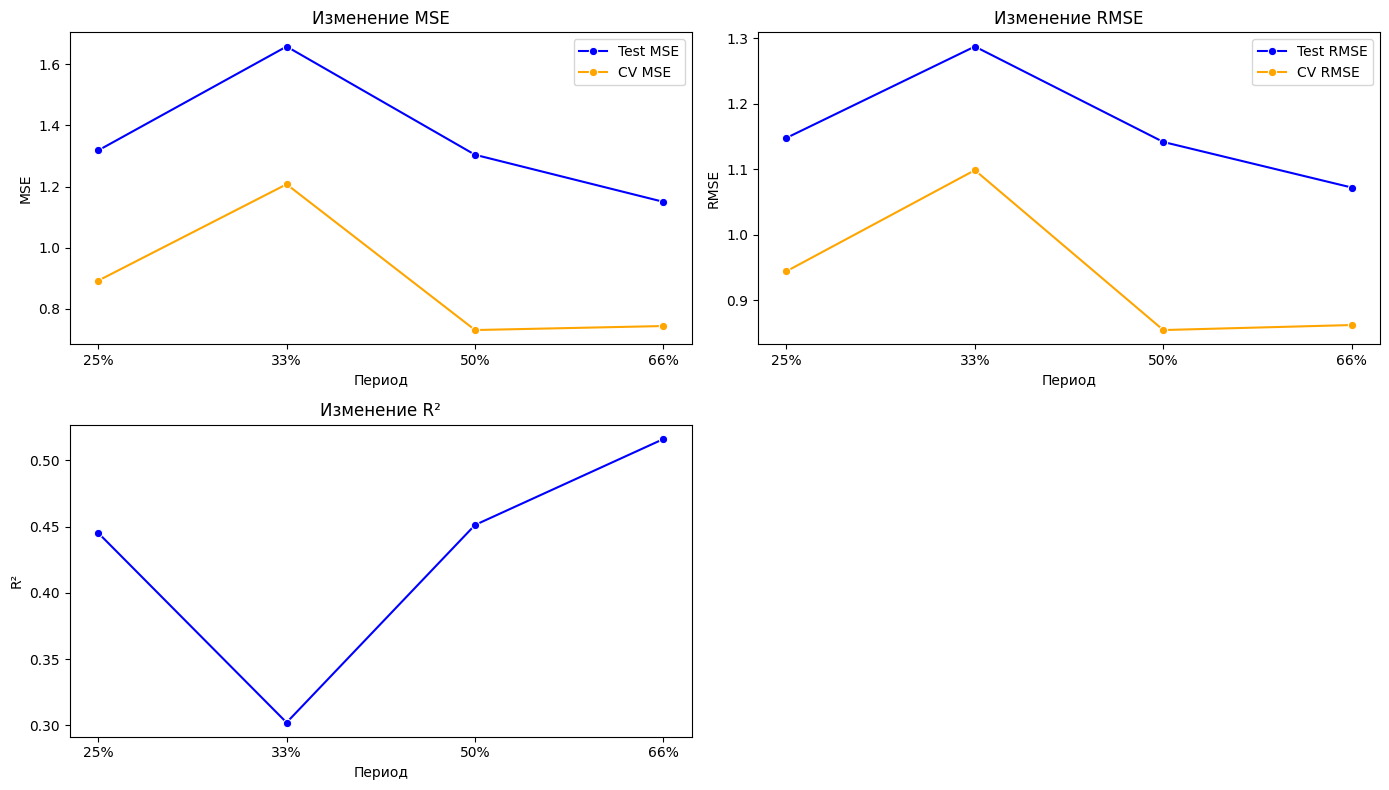

In [65]:
build_metrics_plt(results_df_MLP_3)

## Итоги на текущий шаг

Во всех случаях обучение с данными без выбросов и с учетом прошедших данных покзаывает лучший результат (Кроме MLP, там нужны больше данных)

Лучшие метрики для каждой модели:
- RF
 Test MSE  Overfitting Diff     RMSE        R²  
0  0.330091          0.097127  0.574535  0.736692  
1  0.426859         -0.358053  0.653344  0.659501  
2  0.403239          0.018532  0.635011  0.678342  
3  0.365146         -0.365146  0.604273  0.708729  
4  0.430872         -0.430872  0.656408  0.656300  
- KNN  
 Test MSE  Overfitting Diff      RMSE        R²  
0  0.330091          0.097127  0.574535  0.736692  
1  0.426859         -0.358053  0.653344  0.659501  
2  0.403239          0.018532  0.635011  0.678342  
3  0.365146         -0.365146  0.604273  0.708729  
4  0.430872         -0.430872  0.656408  0.656300  
- SVM  
 Test MSE  Overfitting Diff      RMSE        R²  
0  0.434540          0.234348  0.659196  0.653374  
1  0.201245          0.308143  0.448603  0.839470  
2  0.208225          0.156078  0.456317  0.833902  
3  0.179864          0.124117  0.424104  0.856525  
4  0.337008         -0.141770  0.580524  0.731174  
- MLP


## Логорофмирование данных по логам

In [42]:
def logarithmize_dataframe(df):
    """
    Прологарифмировать числовые колонки в DataFrame, исключая колонки с типом object
    и колонки с оценками за интервал.

    Параметры:
    - df: Исходный DataFrame.

    Возвращает:
    - df_log: DataFrame с прологарифмированными значениями.
    """
    # Создаем копию DataFrame, чтобы не изменять исходные данные
    df_log = df.copy()

    # Определяем колонки, которые НЕ нужно логарифмировать
    exclude_columns = [
        col for col in df.columns if df[col].dtype == 'object' or col.startswith("Оценка за интервал")
    ]

    # Определяем числовые колонки для логарифмирования
    numeric_columns = [
        col for col in df.columns
        if df[col].dtype != 'object' and col not in exclude_columns
    ]

    # Логарифмирование числовых колонок
    for col in numeric_columns:
        # Добавляем маленькую константу (например, 1e-6), чтобы избежать ошибок с нулями или отрицательными значениями
        df_log[col] = np.log(df[col] + 1e-6)

    return df_log

In [43]:
df_cleaned_log = logarithmize_dataframe(df_cleaned)

In [70]:
results_df_PR_log, results_PR_log = learn_PR_model(df_cleaned_log, True)

Формирование результатов для периода 20%...
Топ-8 лучших предикторов (по коэффициентам):
                                  Feature  Coefficient
6                  Оценка за интервал 20%     0.553393
2       Число просмотров своих ошибок 20%     0.514457
0                 Число входов в курс 20%     0.182753
4      Количество выполненных заданий 20%     0.116502
5        Среднее время между заходами 20%    -0.098806
3  Число просмотров полученных оценок 20%     0.080249
1            Число просмотров модулей 20%     0.065675

Топ-8 худших предикторов (по коэффициентам):
                                  Feature  Coefficient
6                  Оценка за интервал 20%     0.553393
2       Число просмотров своих ошибок 20%     0.514457
0                 Число входов в курс 20%     0.182753
4      Количество выполненных заданий 20%     0.116502
5        Среднее время между заходами 20%    -0.098806
3  Число просмотров полученных оценок 20%     0.080249
1            Число просмотров модулей 20

In [71]:
output_mean_metrics(results_df_PR_log)

  Model Period                                    Best Parameters  Train RMSE  \
0    PR    20%  (PolynomialFeatures(degree=1, include_bias=Fal...    1.327898   
1    PR    33%  (PolynomialFeatures(degree=1, include_bias=Fal...    1.265724   
2    PR    50%  (PolynomialFeatures(degree=1, include_bias=Fal...    1.063683   
3    PR    66%  (PolynomialFeatures(degree=1, include_bias=Fal...    0.976779   

   Test MSE  Test RMSE        R²         BIC         AIC  \
0  1.646408   1.283124  0.332353  459.363303  426.338670   
1  1.542044   1.241790  0.374675  452.229999  386.180733   
2  1.183848   1.088048  0.519929  280.646809  181.572910   
3  1.076006   1.037307  0.563661  248.681177  116.582646   

                  Feature Importances (Coefficients)  \
0  [{'Feature': 'Оценка за интервал 20%', 'Coeffi...   
1  [{'Feature': 'Оценка за интервал 33%', 'Coeffi...   
2  [{'Feature': 'Оценка за интервал 50%', 'Coeffi...   
3  [{'Feature': 'Оценка за интервал 66%', 'Coeffi...   

            

In [44]:
results_df_RF_log, results_RF_log = learn_RF_model(df_cleaned_log, True)


--- Обработка периода: 20% (Random Forest) ---
Используемые признаки (7): ['Количество выполненных заданий 20%', 'Оценка за интервал 20%', 'Среднее время между заходами 20%', 'Число входов в курс 20%', 'Число просмотров модулей 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Подбор гиперпараметров Random Forest с Optuna...
Финальные параметры для RF 20%: {'n_estimators': 280, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
Формирование результатов для RF периода 20%...
Результаты для RF периода 20%:
  Лучшие параметры: {'n_estimators': 280, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
  Train RMSE=0.7571
  Test MSE=1.1608, Test RMSE=1.0774, R²=0.5293
  Время обработки: 137.84 сек.
--------------------------------------------------

--- Обработка периода: 33% (Random Forest) ---
Используемые признаки (14): ['Количество выполненных 

In [49]:
output_mean_metrics(results_df_RF_log)

  Model Period                                    Best Parameters  Train RMSE  \
0    RF    20%  {'n_estimators': 280, 'max_depth': 35, 'min_sa...    0.757054   
1    RF    33%  {'n_estimators': 190, 'max_depth': 26, 'min_sa...    0.606260   
2    RF    50%  {'n_estimators': 270, 'max_depth': 24, 'min_sa...    0.435917   
3    RF    66%  {'n_estimators': 240, 'max_depth': 39, 'min_sa...    0.594186   

   Test MSE  Test RMSE        R²  
0  1.160834   1.077420  0.529262  
1  0.986733   0.993344  0.599863  
2  0.720404   0.848766  0.707864  
3  0.725875   0.851983  0.705645  


In [66]:
results_df_KNN_log, results_KNN_log = learn_KNN_model(df_cleaned_log, True)


--- Обработка периода: 20% (KNN) ---
Используемые признаки (7): ['Количество выполненных заданий 20%', 'Оценка за интервал 20%', 'Среднее время между заходами 20%', 'Число входов в курс 20%', 'Число просмотров модулей 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Подбор гиперпараметров KNN с Optuna...
Лучшие параметры для KNN 20%: {'n_neighbors': 11, 'weights': 'distance', 'p': 2}
Формирование результатов для KNN периода 20%...
Результаты для KNN периода 20%:
  Лучшие параметры: {'n_neighbors': 11, 'weights': 'distance', 'p': 2}
  Train RMSE=0.2114
  Test MSE=1.2590, Test RMSE=1.1220, R²=0.4895
  Время обработки: 6.64 сек.
--------------------------------------------------

--- Обработка периода: 33% (KNN) ---
Используемые признаки (14): ['Количество выполненных заданий 20%', 'Количество выполненных заданий 33%', 'Оценка за интервал 20%', 'Оценка за интервал 33%', 'Среднее время между заходами 20%']...
Размеры выборок: Train=(827, 14), Test=(207, 14)
Подбор гиперпараметров K

In [67]:
output_mean_metrics(results_df_KNN_log)

  Model Period                                    Best Parameters  Train RMSE  \
0   KNN    20%  {'n_neighbors': 11, 'weights': 'distance', 'p'...    0.211370   
1   KNN    33%  {'n_neighbors': 8, 'weights': 'distance', 'p': 1}    0.126272   
2   KNN    50%  {'n_neighbors': 10, 'weights': 'distance', 'p'...    0.060730   
3   KNN    66%  {'n_neighbors': 7, 'weights': 'distance', 'p': 1}    0.006811   

   Test MSE  Test RMSE        R²  
0  1.258980   1.122043  0.489462  
1  1.266193   1.125253  0.486537  
2  1.060692   1.029899  0.569871  
3  0.937390   0.968189  0.619872  


In [61]:
results_df_MLP_log, results_MLP_log = learn_MLP_model(df_cleaned_log, True)


--- Обработка периода: 20% (MLP) ---
Используемые признаки (7): ['Количество выполненных заданий 20%', 'Оценка за интервал 20%', 'Среднее время между заходами 20%', 'Число входов в курс 20%', 'Число просмотров модулей 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Подбор гиперпараметров MLP с Optuna...
Лучшие параметры для MLP 20%: {'activation': 'relu', 'alpha': 0.0024630534209954392, 'solver': 'adam', 'learning_rate_init': 0.008701832634697409, 'learning_rate': 'adaptive', 'beta_1': 0.8511639556879664, 'beta_2': 0.9321134874887216, 'hidden_layer_sizes': (19, 10, 14)}
Формирование результатов для MLP периода 20%...
Результаты для MLP периода 20%:
  Лучшие параметры: {'activation': 'relu', 'alpha': 0.0024630534209954392, 'solver': 'adam', 'learning_rate_init': 0.008701832634697409, 'learning_rate': 'adaptive', 'beta_1': 0.8511639556879664, 'beta_2': 0.9321134874887216, 'hidden_layer_sizes': (19, 10, 14)}
  Train RMSE=1.1474
  Test MSE=1.3413, Test RMSE=1.1581, R²=0.4561
  BIC

In [62]:
output_mean_metrics(results_df_MLP_log)

  Model Period                                    Best Parameters  Train RMSE  \
0   MLP    20%  {'activation': 'relu', 'alpha': 0.002463053420...    1.147363   
1   MLP    33%  {'activation': 'relu', 'alpha': 0.001706599561...    0.943882   
2   MLP    50%  {'activation': 'tanh', 'alpha': 0.998920274354...    0.858901   
3   MLP    66%  {'activation': 'tanh', 'alpha': 0.996306038164...    0.739891   

   Test MSE  Test RMSE        R²  
0  1.341281   1.158137  0.456088  
1  1.303608   1.141757  0.471364  
2  0.969245   0.984502  0.606954  
3  0.840444   0.916757  0.659185  


In [ ]:
Логарифмирование не дало результатов

## VIF-анализ для выявления мультиколлинеарности и улучшения результатов

После построения моделей был проведен VIF-анализ для выявления мультиколлинеарности среди признаков. Анализ показал, что некоторые признаки имеют высокие значения VIF (> 10), что указывает на их зависимость друг от друга. Для улучшения качества прогнозов такие признаки были исключены из модели. Например, для периода 50% (текущий + предыдущие) были удалены признаки 'количество выполненных заданий за 25%' и 'процент выполненных заданий за 33%', так как они сильно коррелировали с другими признаками. После исключения проблемных признаков метрики качества модели (MSE, RMSE, R²) значительно улучшились."

Удалим для df_cleaned, так как для таких данных лучшие модели

In [79]:
# Функция для расчета VIF
def calculate_vif(df, target_column):
    """
    Рассчитывает VIF для всех числовых признаков в DataFrame.
    Исключает целевую переменную из анализа.

    Параметры:
    - df: DataFrame с данными.
    - target_column: Название целевой переменной.

    Возвращает:
    - vif_data: DataFrame с признаками и их VIF-значениями.
    """
    # Отбираем только числовые признаки, исключая целевую переменную
    numeric_features = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != target_column]

    # Создаем DataFrame для хранения VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_features
    vif_data["VIF"] = [variance_inflation_factor(df[numeric_features].values, i) for i in range(len(numeric_features))]

    # Сортируем по VIF
    vif_data = vif_data.sort_values(by="VIF", ascending=False)
    return vif_data

# Новый DataFrame для хранения отфильтрованных данных
filtered_dfs_cleaned_cur_VIF = {}
filtered_dfs_cleaned_prev_VIF = {}

# Обработка для текущего и предыдущих периодов
for period in periods:
    # Формирование списка признаков для текущего и предыдущих периодов (исключая целевую переменную)
    features_all_periods = []
    for p in periods[:periods.index(period) + 1]:  # Включаем текущий и предыдущие периоды
        features_all_periods.extend([
            col for col in df_cleaned.columns
            if col.endswith(p) and df_cleaned[col].dtype != 'object' and col != target_column
        ])

    # Вычисление VIF
    vif_all_periods = calculate_vif(df_cleaned[features_all_periods], target_column)

    # Исключение проблемных признаков (VIF > 50)
    problematic_features = vif_all_periods[vif_all_periods["VIF"] > 10]["Feature"].tolist()
    filtered_features = [f for f in features_all_periods if f not in problematic_features]

    # Создание нового DataFrame
    filtered_dfs_cleaned_prev_VIF[f"{period}_all"] = df_cleaned[filtered_features + [target_column]]  # Добавляем целевую переменную
    print(len(filtered_features))
    print(f"Оставшиеся признаки для периода {period} (текущий + предыдущие): {filtered_features}")

7
Оставшиеся признаки для периода 20% (текущий + предыдущие): ['Число входов в курс 20%', 'Число просмотров модулей 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%', 'Среднее время между заходами 20%', 'Оценка за интервал 20%']
11
Оставшиеся признаки для периода 33% (текущий + предыдущие): ['Число входов в курс 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%', 'Среднее время между заходами 20%', 'Число входов в курс 33%', 'Число просмотров модулей 33%', 'Число просмотров своих ошибок 33%', 'Число просмотров полученных оценок 33%', 'Количество выполненных заданий 33%', 'Среднее время между заходами 33%']
17
Оставшиеся признаки для периода 50% (текущий + предыдущие): ['Число входов в курс 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%', 'Среднее время между заходами 20%',

1. Снижение порога для VIF
Вместо стандартного порога VIF > 10 можно использовать более высокий порог, например:

VIF > 50 или VIF > 100.
Это позволит сохранить больше признаков, но при этом исключит только самые проблемные.

In [80]:
results_df_VIF_PR, results_VIF_PR = learn_PR_model(filtered_dfs_cleaned_prev_VIF, True, is_dfs=True)

Формирование результатов для периода 20%...
Топ-8 лучших предикторов (по коэффициентам):
                                              Feature  Coefficient
2                   Число просмотров своих ошибок 20%     1.053511
14                     Число просмотров модулей 20%^2    -0.624427
6                              Оценка за интервал 20%     0.584284
8   Число входов в курс 20% Число просмотров модул...     0.547825
22  Число просмотров своих ошибок 20% Количество в...    -0.515242
9   Число входов в курс 20% Число просмотров своих...    -0.473729
33  Среднее время между заходами 20% Оценка за инт...     0.460696
4                  Количество выполненных заданий 20%     0.396358

Топ-8 худших предикторов (по коэффициентам):
                                              Feature  Coefficient
23  Число просмотров своих ошибок 20% Среднее врем...    -0.072704
26  Число просмотров полученных оценок 20% Количес...     0.065831
24  Число просмотров своих ошибок 20% Оценка за ин...     0.0

In [ ]:
output_mean_metrics(results_df_VIF_PR)

In [81]:
results_df_VIF_RF, results_VIF_RF = learn_RF_model(filtered_dfs_cleaned_prev_VIF, True, is_dfs=True)


--- Обработка периода: 20% (Random Forest) ---
Используемые признаки (7): ['Число входов в курс 20%', 'Число просмотров модулей 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Подбор гиперпараметров Random Forest с Optuna...
Финальные параметры для RF 20%: {'n_estimators': 280, 'max_depth': 44, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
Формирование результатов для RF периода 20%...
Результаты для RF периода 20%:
  Лучшие параметры: {'n_estimators': 280, 'max_depth': 44, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': None, 'random_state': 42, 'n_jobs': -1}
  Train RMSE=0.7756
  Test MSE=1.1615, Test RMSE=1.0777, R²=0.5290
  Время обработки: 72.35 сек.
--------------------------------------------------

--- Обработка периода: 33% (Random Forest) ---
Используемые признаки (11): ['Число в

In [82]:
output_mean_metrics(results_df_VIF_RF)

  Model Period                                    Best Parameters  Train RMSE  \
0    RF    20%  {'n_estimators': 280, 'max_depth': 44, 'min_sa...    0.775621   
1    RF    33%  {'n_estimators': 260, 'max_depth': 37, 'min_sa...    1.015556   
2    RF    50%  {'n_estimators': 110, 'max_depth': 41, 'min_sa...    0.936772   
3    RF    66%  {'n_estimators': 180, 'max_depth': 41, 'min_sa...    0.872927   

   Test MSE  Test RMSE        R²  
0  1.161499   1.077729  0.528992  
1  1.556971   1.247786  0.368622  
2  1.557937   1.248173  0.368230  
3  1.411401   1.188024  0.427653  


In [83]:
results_df_VIF_KNN, results_VIF_KNN = learn_KNN_model(filtered_dfs_cleaned_prev_VIF, True, is_dfs=True)


--- Обработка периода: 20% (KNN) ---
Используемые признаки (7): ['Число входов в курс 20%', 'Число просмотров модулей 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Подбор гиперпараметров KNN с Optuna...
Лучшие параметры для KNN 20%: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}
Формирование результатов для KNN периода 20%...
Результаты для KNN периода 20%:
  Лучшие параметры: {'n_neighbors': 13, 'weights': 'distance', 'p': 1}
  Train RMSE=0.2102
  Test MSE=1.3721, Test RMSE=1.1714, R²=0.4436
  Время обработки: 6.79 сек.
--------------------------------------------------

--- Обработка периода: 33% (KNN) ---
Используемые признаки (11): ['Число входов в курс 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%', 'Среднее время между заходами 20%']...
Размеры выборок: Train=(827, 11), Test=(

In [84]:
output_mean_metrics(results_df_VIF_KNN)

  Model Period                                    Best Parameters  Train RMSE  \
0   KNN    20%  {'n_neighbors': 13, 'weights': 'distance', 'p'...    0.210212   
1   KNN    33%  {'n_neighbors': 27, 'weights': 'distance', 'p'...    0.142253   
2   KNN    50%  {'n_neighbors': 20, 'weights': 'distance', 'p'...    0.077424   
3   KNN    66%  {'n_neighbors': 19, 'weights': 'distance', 'p'...    0.023277   

   Test MSE  Test RMSE        R²  
0  1.372124   1.171377  0.443580  
1  1.549012   1.244593  0.371849  
2  1.599940   1.264887  0.351197  
3  1.509125   1.228465  0.388024  


In [86]:
results_df_VIF_MLP, results_VIF_MLP = learn_MLP_model(filtered_dfs_cleaned_prev_VIF, True, is_dfs=True)


--- Обработка периода: 20% (MLP) ---
Используемые признаки (7): ['Число входов в курс 20%', 'Число просмотров модулей 20%', 'Число просмотров своих ошибок 20%', 'Число просмотров полученных оценок 20%', 'Количество выполненных заданий 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Подбор гиперпараметров MLP с Optuna...
Лучшие параметры для MLP 20%: {'activation': 'relu', 'alpha': 2.0874206030794558e-05, 'solver': 'adam', 'learning_rate_init': 0.0024345758885871943, 'learning_rate': 'adaptive', 'beta_1': 0.9364766541491033, 'beta_2': 0.9228372971149215, 'hidden_layer_sizes': (9, 16)}
Формирование результатов для MLP периода 20%...
Результаты для MLP периода 20%:
  Лучшие параметры: {'activation': 'relu', 'alpha': 2.0874206030794558e-05, 'solver': 'adam', 'learning_rate_init': 0.0024345758885871943, 'learning_rate': 'adaptive', 'beta_1': 0.9364766541491033, 'beta_2': 0.9228372971149215, 'hidden_layer_sizes': (9, 16)}
  Train RMSE=1.1287
  Test MSE=1.2588, Test RMSE=1.1220, R²=0

In [88]:
output_mean_metrics(results_df_VIF_MLP)

  Model Period                                    Best Parameters  Train RMSE  \
0   MLP    20%  {'activation': 'relu', 'alpha': 2.087420603079...    1.128716   
1   MLP    33%  {'activation': 'tanh', 'alpha': 0.144328688656...    1.249011   
2   MLP    50%  {'activation': 'tanh', 'alpha': 0.000217750461...    1.263559   
3   MLP    66%  {'activation': 'tanh', 'alpha': 0.502031887754...    1.241416   

   Test MSE  Test RMSE        R²  
0  1.258814   1.121969  0.489529  
1  1.636464   1.279244  0.336386  
2  1.726234   1.313862  0.299982  
3  1.573592   1.254429  0.361881  


##  Обучение с PCA

Для дальнейшего улучшения качества моделей был применён метод главных компонент (PCA) для снижения размерности данных. Была разработана универсальная функция learn_model_with_PCA, которая позволяет обучать различные модели (например, KNN, SVM, MLP и др.) с использованием PCA. Для каждого случая были вычислены метрики качества модели (MSE, RMSE, R²), а также проведён подбор гиперпараметров с использованием метода GridSearchCV. Результаты показали, что применение PCA позволило уменьшить размерность данных, сохранив при этом высокую обобщающую способность модели.

In [89]:
results_df_PCA_PR, results_PCA_PR = learn_PR_model(df_cleaned, True, True)

Формирование результатов для периода 20%...
Топ-8 лучших предикторов (по перестановочной важности):
  Feature  Importance
0   PCA_0    1.192273
1   PCA_1    0.712877

Топ-8 худших предикторов (по перестановочной важности):
  Feature  Importance
0   PCA_0    1.192273
1   PCA_1    0.712877
Результаты для периода 20%:
Лучшие параметры: {'polynomialfeatures__degree': 4}
Test MSE=1.32, Test RMSE=1.15, R²=0.47
train_rmse=1.25, BIC=322.46, AIC=256.41
Важность признаков (коэффициенты):
Важность признаков (перестановочный метод):
  Feature  Importance
0   PCA_0    1.192273
1   PCA_1    0.712877
--------------------------------------------------
Формирование результатов для периода 33%...
Топ-8 лучших предикторов (по перестановочной важности):
  Feature  Importance
0   PCA_0    2.081308
1   PCA_1    0.877279

Топ-8 худших предикторов (по перестановочной важности):
  Feature  Importance
0   PCA_0    2.081308
1   PCA_1    0.877279
Результаты для периода 33%:
Лучшие параметры: {'polynomialfeatures_

In [90]:
output_mean_metrics(results_PCA_PR)

  Model Period                                    Best Parameters  Train RMSE  \
0    PR    20%  (PolynomialFeatures(degree=4, include_bias=Fal...    1.251646   
1    PR    33%  (PolynomialFeatures(degree=4, include_bias=Fal...    1.221155   
2    PR    50%  (PolynomialFeatures(degree=3, include_bias=Fal...    1.005365   
3    PR    66%  (PolynomialFeatures(degree=3, include_bias=Fal...    0.983290   

   Test MSE  Test RMSE        R²         BIC         AIC  \
0  1.318099   1.148085  0.465488  322.458628  256.409363   
1  1.428423   1.195167  0.420750  388.933701  322.884436   
2  0.938354   0.968687  0.619481   75.018028  -14.620261   
3  0.938877   0.968957  0.619269   75.478853  -14.159436   

  Feature Importances (Coefficients)  \
0                               None   
1                               None   
2                               None   
3                               None   

                   Feature Importances (Permutation)  
0  [{'Feature': 'PCA_0', 'Importance'

In [91]:
results_df_PCA_RF, results_PCA_RF = learn_RF_model(df_cleaned, True, True)


--- Обработка периода: 20% (Random Forest) ---
Используемые признаки (7): ['Количество выполненных заданий 20%', 'Оценка за интервал 20%', 'Среднее время между заходами 20%', 'Число входов в курс 20%', 'Число просмотров модулей 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Применение PCA...
PCA оставил 6 компонент.
Подбор гиперпараметров Random Forest с Optuna...
Финальные параметры для RF 20%: {'n_estimators': 90, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
Формирование результатов для RF периода 20%...
Результаты для RF периода 20%:
  Лучшие параметры: {'n_estimators': 90, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1}
  Train RMSE=0.7009
  Test MSE=1.2954, Test RMSE=1.1381, R²=0.4747
  Время обработки: 63.67 сек.
--------------------------------------------------

--- Обработка периода: 33% (Random Forest) ---
Используемы

In [93]:
output_mean_metrics(results_PCA_RF)

  Model Period                                    Best Parameters  Train RMSE  \
0    RF    20%  {'n_estimators': 90, 'max_depth': 37, 'min_sam...    0.700897   
1    RF    33%  {'n_estimators': 220, 'max_depth': 42, 'min_sa...    0.598249   
2    RF    50%  {'n_estimators': 110, 'max_depth': 32, 'min_sa...    0.478078   
3    RF    66%  {'n_estimators': 130, 'max_depth': 13, 'min_sa...    0.505235   

   Test MSE  Test RMSE        R²  
0  1.295357   1.138137  0.474711  
1  1.242678   1.114754  0.496073  
2  1.014222   1.007086  0.588716  
3  0.898921   0.948114  0.635472  


In [94]:
results_df_PCA_KNN, results_PCA_KNN = learn_KNN_model(df_cleaned, True, True)


--- Обработка периода: 20% (KNN) ---
Используемые признаки (7): ['Количество выполненных заданий 20%', 'Оценка за интервал 20%', 'Среднее время между заходами 20%', 'Число входов в курс 20%', 'Число просмотров модулей 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Применение PCA...
PCA оставил 6 компонент.
Подбор гиперпараметров KNN с Optuna...
Лучшие параметры для KNN 20%: {'n_neighbors': 23, 'weights': 'distance', 'p': 2}
Формирование результатов для KNN периода 20%...
Результаты для KNN периода 20%:
  Лучшие параметры: {'n_neighbors': 23, 'weights': 'distance', 'p': 2}
  Train RMSE=0.2080
  Test MSE=1.3288, Test RMSE=1.1527, R²=0.4611
  Время обработки: 6.89 сек.
--------------------------------------------------

--- Обработка периода: 33% (KNN) ---
Используемые признаки (14): ['Количество выполненных заданий 20%', 'Количество выполненных заданий 33%', 'Оценка за интервал 20%', 'Оценка за интервал 33%', 'Среднее время между заходами 20%']...
Размеры выборок: Train=(827, 1

In [95]:
output_mean_metrics(results_PCA_KNN)

  Model Period                                    Best Parameters  Train RMSE  \
0   KNN    20%  {'n_neighbors': 23, 'weights': 'distance', 'p'...    0.207965   
1   KNN    33%  {'n_neighbors': 21, 'weights': 'distance', 'p'...    0.126106   
2   KNN    50%  {'n_neighbors': 8, 'weights': 'distance', 'p': 2}    0.060730   
3   KNN    66%  {'n_neighbors': 11, 'weights': 'distance', 'p'...    0.006811   

   Test MSE  Test RMSE        R²  
0  1.328832   1.152750  0.461136  
1  1.248992   1.117583  0.493512  
2  1.113325   1.055142  0.548527  
3  0.914658   0.956377  0.629091  


In [97]:
results_df_PCA_MLP, results_PCA_MLP = learn_MLP_model(df_cleaned, True, True)


--- Обработка периода: 20% (MLP) ---
Используемые признаки (7): ['Количество выполненных заданий 20%', 'Оценка за интервал 20%', 'Среднее время между заходами 20%', 'Число входов в курс 20%', 'Число просмотров модулей 20%']...
Размеры выборок: Train=(827, 7), Test=(207, 7)
Применение PCA...
PCA оставил 6 компонент.
Подбор гиперпараметров MLP с Optuna...
Лучшие параметры для MLP 20%: {'activation': 'relu', 'alpha': 0.014354663232348991, 'solver': 'sgd', 'learning_rate_init': 0.004917965090739552, 'learning_rate': 'constant', 'hidden_layer_sizes': (13, 16)}
Формирование результатов для MLP периода 20%...
Результаты для MLP периода 20%:
  Лучшие параметры: {'activation': 'relu', 'alpha': 0.014354663232348991, 'solver': 'sgd', 'learning_rate_init': 0.004917965090739552, 'learning_rate': 'constant', 'hidden_layer_sizes': (13, 16)}
  Train RMSE=1.2516
  Test MSE=1.3963, Test RMSE=1.1817, R²=0.4338
  Время обработки: 93.16 сек.
--------------------------------------------------

--- Обработк

In [98]:
output_mean_metrics(results_PCA_MLP)

  Model Period                                    Best Parameters  Train RMSE  \
0   MLP    20%  {'activation': 'relu', 'alpha': 0.014354663232...    1.251604   
1   MLP    33%  {'activation': 'relu', 'alpha': 0.009224780850...    0.969240   
2   MLP    50%  {'activation': 'relu', 'alpha': 0.929262880319...    0.789174   
3   MLP    66%  {'activation': 'tanh', 'alpha': 0.661659991453...    0.754455   

   Test MSE  Test RMSE        R²  
0  1.396344   1.181670  0.433758  
1  1.116674   1.056728  0.547169  
2  1.037946   1.018796  0.579095  
3  0.933565   0.966212  0.621423  


##  Ансамбли моделей

In [87]:
def learn_stacking_model(data, all_features=True, use_PCA=False, is_dfs=False):
    """
    Обучает модель StackingRegressor, подбирает гиперпараметры базовых моделей и мета-модели с Optuna,
    оценивает ее и возвращает результаты в заданном формате.
    """
    # Результаты для всех периодов
    results = []
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Уменьшаем вывод Optuna

    # Цикл по всем периодам
    for period in periods:
        print(f"\n--- Обработка периода: {period} (Stacking) ---")
        start_time_period = time.time() # Замер времени для периода

        # --- 1. Выбор признаков и данных ---
        features = []
        X = None
        y = None
        pca = None # Инициализация pca для текущего периода
        scaler = None # Инициализация scaler

        try:
            # --- Логика выбора признаков ---
            if not is_dfs:
                df_period = data
                if all_features:
                    current_period_index = periods.index(period)
                    periods_to_include = periods[:current_period_index + 1]
                    features = []
                    for p in periods_to_include:
                        features.extend([
                            col for col in df_period.columns
                            if isinstance(col, str) and col.endswith(f" {p}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                        ])
                    features = sorted(list(set(features)))
                else:
                    features = [
                        col for col in df_period.columns
                        if isinstance(col, str) and col.endswith(f" {period}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                    ]
                if not features: print(f"Предупреждение: Нет признаков для {period}. Пропуск."); continue
                X = df_period[features]
                y = df_period[target_column]
            else: # Логика для is_dfs
                df_key = f"{period}_all" if all_features else f"{period}_current"
                if df_key not in data: print(f"Предупреждение: Ключ '{df_key}' не найден. Пропуск {period}."); continue
                df_period = data[df_key]
                if target_column not in df_period.columns: print(f"Предупреждение: '{target_column}' не найден в '{df_key}'. Пропуск {period}."); continue
                X = df_period.drop(columns=[target_column], errors='ignore')
                y = df_period[target_column]
                features = X.columns.tolist()

            print(f"Используемые признаки ({len(features)}): {features[:5]}...")
            if X.empty or y.empty: print(f"Предупреждение: Нет данных X или y для {period}. Пропуск."); continue

        except Exception as e: print(f"Ошибка подготовки данных {period}: {e}"); traceback.print_exc(); continue

        # --- 2. Разделение данных ---
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"Размеры выборок: Train={X_train.shape}, Test={X_test.shape}")
            if X_train.shape[0] == 0 or y_train.shape[0] == 0: print(f"Внимание: Тренировочные данные пусты для {period}. Пропуск."); continue
        except Exception as e: print(f"Ошибка разделения данных {period}: {e}"); continue

        # --- 3. Масштабирование и PCA (Опционально) ---
        # Масштабирование важно для KNN, MLP, SVR и PCA
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train) # Обучаем и применяем к Train
        X_test = scaler.transform(X_test)     # Применяем к Test

        # Сохраняем для случая отката PCA
        X_train_orig_scaled = X_train.copy()
        X_test_orig_scaled = X_test.copy()
        num_features_before_pca = X_train.shape[1] # Сохраняем кол-во признаков до PCA

        if use_PCA:
            print("Применение PCA...")
            pca = PCA(n_components=0.9, random_state=42) # Сохраняем 85% дисперсии
            try:
                X_train = pca.fit_transform(X_train) # PCA на масштабированных данных
                X_test = pca.transform(X_test)
                n_components = X_train.shape[1]
                print(f"PCA оставил {n_components} компонент.")
                if n_components == 0:
                    print("Предупреждение: PCA не оставил компонент. Используются исходные масштабированные данные.")
                    X_train = X_train_orig_scaled
                    X_test = X_test_orig_scaled
                    pca = None
            except Exception as e:
                 print(f"Ошибка при применении PCA для {period}: {e}. Используются масштабированные данные без PCA.")
                 X_train = X_train_orig_scaled
                 X_test = X_test_orig_scaled
                 use_PCA = False # Сбрасываем флаг для этого периода
                 pca = None
        else:
             pca = None # PCA не используется

        n_input_features = X_train.shape[1] # Актуальное количество признаков

        # --- 4. Подбор гиперпараметров Stacking с Optuna ---
        def objective_stacking(trial):
            # --- Гиперпараметры Базовых Моделей ---

            # --- Random Forest (rf__) ---
            rf_n_estimators = trial.suggest_int('rf__n_estimators', 50, 300, step=10)
            rf_max_depth = trial.suggest_int('rf__max_depth', 5, 50)
            rf_min_samples_split = trial.suggest_int('rf__min_samples_split', 2, 20)
            rf_min_samples_leaf = trial.suggest_int('rf__min_samples_leaf', 1, 10)
            # Обработка max_features
            rf_max_features_choice = trial.suggest_categorical('rf__max_features_choice', ['sqrt', 'log2', 'all'])
            rf_max_features = 1.0 if rf_max_features_choice == 'all' else rf_max_features_choice

            # --- K-Nearest Neighbors (knn__) ---
            knn_n_neighbors = trial.suggest_int('knn__n_neighbors', 1, 30)
            knn_weights = trial.suggest_categorical('knn__weights', ['uniform', 'distance'])
            knn_p = trial.suggest_int('knn__p', 1, 2)

            # --- Support Vector Regressor (svr__) ---
            svr_kernel = trial.suggest_categorical('svr__kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
            svr_C = trial.suggest_float('svr__C', 1e-2, 1e3, log=True)
            svr_epsilon = trial.suggest_float('svr__epsilon', 1e-2, 1.0, log=True)
            # Параметры, зависящие от ядра SVR
            svr_gamma = 'scale' # Значение по умолчанию
            svr_degree = 3      # Значение по умолчанию
            if svr_kernel in ['rbf', 'poly', 'sigmoid']:
                svr_gamma = trial.suggest_categorical('svr__gamma', ['scale', 'auto'])
            if svr_kernel == 'poly':
                svr_degree = trial.suggest_int('svr__degree', 2, 5)

            # --- Multi-layer Perceptron (mlp__) ---
            mlp_n_layers = trial.suggest_int('mlp__n_layers', 1, 3)
            mlp_layers = []
            last_layer_size = n_input_features # Используем актуальное число входов после PCA/Scaler
            for i in range(mlp_n_layers):
                # Ограничим максимальный размер, чтобы избежать слишком больших сетей
                max_units = max(32, int(last_layer_size * 1.5)) # Не более 1.5x предыдущего
                min_units = max(8, int(last_layer_size * 0.25)) # Не менее 1/4 предыдущего (минимум 8)
                suggested_size = trial.suggest_int(f'mlp__n_units_layer_{i}', min_units, max_units)
                mlp_layers.append(suggested_size)
                last_layer_size = suggested_size
            mlp_hidden_layer_sizes = tuple(mlp_layers)

            mlp_activation = trial.suggest_categorical('mlp__activation', ['relu', 'tanh', 'logistic'])
            mlp_alpha = trial.suggest_float('mlp__alpha', 1e-6, 1.0, log=True) # Расширим alpha
            mlp_solver = trial.suggest_categorical('mlp__solver', ['adam', 'sgd']) # Оставляем Adam/SGD
            mlp_learning_rate_init = trial.suggest_float('mlp__learning_rate_init', 1e-5, 1e-2, log=True)
            mlp_learning_rate_mode = trial.suggest_categorical('mlp__learning_rate', ['constant', 'adaptive'])
            # Параметры Adam/SGD (можно оставить значения по умолчанию для простоты в stacking objective)
            # mlp_beta_1 = trial.suggest_float('mlp__beta_1', 0.8, 0.99) if mlp_solver == 'adam' else 0.9
            # mlp_beta_2 = trial.suggest_float('mlp__beta_2', 0.9, 0.999) if mlp_solver == 'adam' else 0.999
            mlp_beta_1 = 0.9  # Значение по умолчанию
            mlp_beta_2 = 0.999 # Значение по умолчанию


            # --- Гиперпараметры Мета-Модели (meta__) ---
            # Используем Ridge как мета-модель
            meta_ridge_alpha = trial.suggest_float('meta__ridge_alpha', 1e-3, 1e3, log=True) # Расширим alpha

            # --- Создание моделей с предложенными параметрами ---
            estimators = [
                ('rf', RandomForestRegressor(
                    n_estimators=rf_n_estimators, max_depth=rf_max_depth,
                    min_samples_split=rf_min_samples_split, min_samples_leaf=rf_min_samples_leaf,
                    max_features=rf_max_features, # Используем обработанное значение
                    random_state=42, n_jobs=-1)),
                ('knn', KNeighborsRegressor(
                    n_neighbors=knn_n_neighbors, weights=knn_weights, p=knn_p, n_jobs=-1)),
                ('svr', SVR(
                    C=svr_C, kernel=svr_kernel, epsilon=svr_epsilon, gamma=svr_gamma, degree=svr_degree)),
                ('mlp', MLPRegressor(
                    hidden_layer_sizes=mlp_hidden_layer_sizes, activation=mlp_activation,
                    alpha=mlp_alpha, solver=mlp_solver,
                    learning_rate_init=mlp_learning_rate_init, learning_rate=mlp_learning_rate_mode,
                    beta_1=mlp_beta_1, beta_2=mlp_beta_2, # Используем значения (можно и дефолтные)
                    max_iter=400, # Увеличим итерации, но с early stopping
                    early_stopping=True, n_iter_no_change=15, random_state=42))
            ]
            final_estimator = Ridge(alpha=meta_ridge_alpha)

            # --- Создание Stacking Regressor ---
            # cv=3 для ускорения Optuna, passthrough=False (мета-модель видит только предсказания)
            stack = StackingRegressor(estimators=estimators, final_estimator=final_estimator,
                                      cv=3, n_jobs=-1, passthrough=False)

            # --- Кросс-валидация для оценки ---
            try:
                # Используем масштабированные (и возможно PCA) X_train
                cv_scores = cross_val_score(stack, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                if np.isnan(cv_scores).any():
                    print("Предупреждение: NaN в CV Stacking.")
                    return float('inf')
                return -np.mean(cv_scores) # Минимизируем MSE
            except Exception as cv_e:
                 print(f"Ошибка CV в триале Optuna Stacking ({trial.params}): {cv_e}")
                 return float('inf')

        print("Подбор гиперпараметров Stacking с Optuna (расширенный)...")
        study_stacking = optuna.create_study(direction='minimize')
        try:
            # Увеличим n_trials, т.к. пространство параметров стало больше
            study_stacking.optimize(objective_stacking, n_trials=1) # 100 триалов, таймаут 30 мин
            best_params = study_stacking.best_params

            # Преобразуем параметры MLP обратно, если нужно
            if 'mlp__n_layers' in best_params:
                n_layers = best_params.pop('mlp__n_layers')
                hidden_layer_sizes_list = [best_params.pop(f'mlp__n_units_layer_{i}') for i in range(n_layers)]
                best_params['mlp__hidden_layer_sizes'] = tuple(hidden_layer_sizes_list)
            # Преобразуем max_features RF
            if 'rf__max_features_choice' in best_params:
                 rf_choice = best_params.pop('rf__max_features_choice')
                 best_params['rf__max_features'] = 1.0 if rf_choice == 'all' else rf_choice

        except Exception as opt_e:
            print(f"Ошибка во время оптимизации Optuna для Stacking {period}: {opt_e}")
            traceback.print_exc(); continue

        print(f"Лучшие параметры для Stacking {period}: {best_params}")

        # --- 5. Обучение финальной модели Stacking ---
        try:
            # Создаем базовые модели с лучшими параметрами
            estimators_final = [
                ('rf', RandomForestRegressor(
                    n_estimators=best_params['rf__n_estimators'], max_depth=best_params['rf__max_depth'],
                    min_samples_split=best_params['rf__min_samples_split'], min_samples_leaf=best_params['rf__min_samples_leaf'],
                    random_state=42, n_jobs=-1)),
                ('knn', KNeighborsRegressor(
                    n_neighbors=best_params['knn__n_neighbors'], weights=best_params['knn__weights'],
                    p=best_params['knn__p'], n_jobs=-1)),
                ('mlp', MLPRegressor(
                    hidden_layer_sizes=best_params['mlp__hidden_layer_sizes'], activation=best_params['mlp__activation'],
                    alpha=best_params['mlp__alpha'], solver='adam', # Используем только Adam
                    max_iter=1000, early_stopping=True, n_iter_no_change=15, random_state=42)), # Увеличим max_iter
                ('svr', SVR(
                    C=best_params['svr__C'], kernel=best_params['svr__kernel'], epsilon=best_params['svr__epsilon']))
            ]
            # Создаем мета-модель
            final_estimator = Ridge(alpha=best_params['meta__ridge_alpha'])

            # Создаем и обучаем финальный Stacking Regressor
            # cv=5 - используется для обучения мета-модели на out-of-fold предсказаниях
            best_stacking = StackingRegressor(estimators=estimators_final, final_estimator=final_estimator,
                                              cv=5, n_jobs=-1, passthrough=False)
            best_stacking.fit(X_train, y_train)

        except Exception as e:
            print(f"Ошибка обучения финальной Stacking модели для {period}: {e}")
            traceback.print_exc(); continue

        # --- 6. Оценка на Тестовой Выборке ---
        test_mse, test_rmse, r2 = np.nan, np.nan, np.nan
        try:
            y_test_pred = best_stacking.predict(X_test)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(max(0, test_mse))
            r2 = r2_score(y_test, y_test_pred)
        except Exception as e:
            print(f"Ошибка оценки Stacking на тесте для {period}: {e}")

        # --- 7. Оценка на Обучающей Выборке (для Train RMSE) ---
        train_rmse = np.nan
        try:
             y_train_pred = best_stacking.predict(X_train)
             train_mse = mean_squared_error(y_train, y_train_pred)
             train_rmse = np.sqrt(max(0, train_mse))
        except Exception as e:
             print(f"Ошибка при расчете Train RMSE для Stacking {period}: {e}")

        # --- 9. Сохранение результатов в ТРЕБУЕМОМ формате ---
        print(f"Формирование результатов для Stacking периода {period}...")
        # <<< НАЧАЛО ИЗМЕНЕНИЯ >>>
        results.append({
            'Model': "Stacking",                # <<< Добавлено
            'Period': period,
            'Best Parameters': best_params,     # Параметры от Optuna (включая базовые и мета)
            'Train RMSE': train_rmse,           # <<< Добавлено
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'R²': r2,
        })
        # <<< КОНЕЦ ИЗМЕНЕНИЯ >>>

        # Вывод промежуточных результатов
        print(f"Результаты для Stacking периода {period}:")
        print(f"  Лучшие параметры: {best_params}") # Может быть длинным
        print(f"  Train RMSE={train_rmse:.4f}")
        print(f"  Test MSE={test_mse:.4f}, Test RMSE={test_rmse:.4f}, R²={r2:.4f}")
        # print(f"  CV RMSE (Optuna)={study_stacking.best_value**0.5:.4f}") # Можно добавить, если нужно
        print(f"  Время обработки: {time.time() - start_time_period:.2f} сек.")
        print("-" * 50)

    # --- 10. Преобразование результатов в DataFrame и возврат ---
    results_df = pd.DataFrame(results)
    print("\nИтоговая таблица результатов (Stacking):")
    cols_to_print = ['Model', 'Period', 'Best Parameters', 'Train RMSE', 'Test MSE', 'Test RMSE', 'R²', 'BIC', 'AIC']
    cols_to_print = [col for col in cols_to_print if col in results_df.columns]
    print(results_df[cols_to_print].round(4).to_string(index=False))

    return results_df, results

In [88]:
results_df_stacking, results_stacking = learn_stacking_model(df_cleaned, True)


--- Обработка периода: 25% (Stacking) ---
Используемые признаки (7): ['Количество выполненных заданий 25%', 'Оценка за интервал 25%', 'Среднее время между заходами 25%', 'Число входов в курс 25%', 'Число просмотров модулей 25%']...
Размеры выборок: Train=(124, 7), Test=(32, 7)
Подбор гиперпараметров Stacking с Optuna (расширенный)...
Лучшие параметры для Stacking 25%: {'rf__n_estimators': 150, 'rf__max_depth': 19, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'knn__n_neighbors': 4, 'knn__weights': 'distance', 'knn__p': 1, 'svr__kernel': 'sigmoid', 'svr__C': 372.98740795653777, 'svr__epsilon': 0.4730156847199303, 'svr__gamma': 'scale', 'mlp__activation': 'logistic', 'mlp__alpha': 1.019719968368042e-05, 'mlp__solver': 'adam', 'mlp__learning_rate_init': 4.432192083856683e-05, 'mlp__learning_rate': 'constant', 'meta__ridge_alpha': 1.5469701510559697, 'mlp__hidden_layer_sizes': (29,), 'rf__max_features': 1.0}
Формирование результатов для Stacking периода 25%...
Результаты для Sta

In [105]:
output_mean_metrics(results_df_stacking)

NameError: name 'results_df_stacking' is not defined

In [90]:
save_results(results_stacking)

In [142]:
results_df_stacking_pca, results_stacking_pca = learn_stacking_model(df_cleaned, True, True)

Результаты для периода 25%:
Лучшие параметры: {'knn__n_neighbors': 3, 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,), 'rf__max_depth': 10, 'rf__n_estimators': 100, 'svr__C': 0.1, 'svr__kernel': 'rbf'}
Test MSE=1.41, Test RMSE=1.19, R²=0.41
CV MSE=0.73, CV RMSE=0.86
--------------------------------------------------


C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Результаты для периода 33%:
Лучшие параметры: {'knn__n_neighbors': 5, 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,), 'rf__max_depth': 10, 'rf__n_estimators': 50, 'svr__C': 0.1, 'svr__kernel': 'rbf'}
Test MSE=1.22, Test RMSE=1.11, R²=0.48
CV MSE=0.69, CV RMSE=0.83
--------------------------------------------------


C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Результаты для периода 50%:
Лучшие параметры: {'knn__n_neighbors': 5, 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50,), 'rf__max_depth': 20, 'rf__n_estimators': 100, 'svr__C': 1.0, 'svr__kernel': 'rbf'}
Test MSE=1.19, Test RMSE=1.09, R²=0.50
CV MSE=0.53, CV RMSE=0.73
--------------------------------------------------


C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached 

Результаты для периода 66%:
Лучшие параметры: {'knn__n_neighbors': 5, 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (50,), 'rf__max_depth': 10, 'rf__n_estimators': 50, 'svr__C': 1.0, 'svr__kernel': 'rbf'}
Test MSE=1.06, Test RMSE=1.03, R²=0.55
CV MSE=0.51, CV RMSE=0.71
--------------------------------------------------
  Period                                    Best Parameters  Test MSE  \
0    25%  {'knn__n_neighbors': 3, 'mlp__alpha': 0.001, '...  1.411585   
1    33%  {'knn__n_neighbors': 5, 'mlp__alpha': 0.0001, ...  1.224748   
2    50%  {'knn__n_neighbors': 5, 'mlp__alpha': 0.001, '...  1.185025   
3    66%  {'knn__n_neighbors': 5, 'mlp__alpha': 0.0001, ...  1.060226   

   Test RMSE        R²    CV MSE   CV RMSE  
0   1.188102  0.405947  0.731558  0.855312  
1   1.106683  0.484576  0.688961  0.830036  
2   1.088589  0.501293  0.533371  0.730322  
3   1.029673  0.553814  0.506146  0.711439  


In [1]:
output_mean_metrics(results_df_stacking_pca)

NameError: name 'output_mean_metrics' is not defined

In [91]:
def learn_KNN_bagging_model(data, all_features=True, use_PCA=False, is_dfs=False):

    # Результаты для всех периодов
    results = []
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Уменьшаем вывод Optuna

    # Цикл по всем периодам
    for period in periods:
        print(f"\n--- Обработка периода: {period} (KNN Bagging) ---")
        start_time_period = time.time() # Замер времени для периода

        # --- 1. Выбор признаков и данных ---
        features = []
        X = None
        y = None
        pca = None # Инициализация pca для текущего периода
        scaler = None # Инициализация scaler

        try:
            # --- Логика выбора признаков ---
            if not is_dfs:
                df_period = data
                if all_features:
                    current_period_index = periods.index(period)
                    periods_to_include = periods[:current_period_index + 1]
                    features = []
                    for p in periods_to_include:
                        features.extend([
                            col for col in df_period.columns
                            if isinstance(col, str) and col.endswith(f" {p}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                        ])
                    features = sorted(list(set(features)))
                else:
                    features = [
                        col for col in df_period.columns
                        if isinstance(col, str) and col.endswith(f" {period}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                    ]
                if not features: print(f"Предупреждение: Нет признаков для {period}. Пропуск."); continue
                X = df_period[features]
                y = df_period[target_column]
            else: # Логика для is_dfs
                df_key = f"{period}_all" if all_features else f"{period}_current"
                if df_key not in data: print(f"Предупреждение: Ключ '{df_key}' не найден. Пропуск {period}."); continue
                df_period = data[df_key]
                if target_column not in df_period.columns: print(f"Предупреждение: '{target_column}' не найден в '{df_key}'. Пропуск {period}."); continue
                X = df_period.drop(columns=[target_column], errors='ignore')
                y = df_period[target_column]
                features = X.columns.tolist()

            print(f"Используемые признаки ({len(features)}): {features[:5]}...")
            if X.empty or y.empty: print(f"Предупреждение: Нет данных X или y для {period}. Пропуск."); continue

        except Exception as e: print(f"Ошибка подготовки данных {period}: {e}"); traceback.print_exc(); continue

        # --- 2. Разделение данных ---
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"Размеры выборок: Train={X_train.shape}, Test={X_test.shape}")
            if X_train.shape[0] == 0 or y_train.shape[0] == 0: print(f"Внимание: Тренировочные данные пусты для {period}. Пропуск."); continue
        except Exception as e: print(f"Ошибка разделения данных {period}: {e}"); continue

        # --- 3. Масштабирование и PCA (Опционально) ---
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        X_train_orig_scaled = X_train.copy()
        X_test_orig_scaled = X_test.copy()

        if use_PCA:
            print("Применение PCA...")
            pca = PCA(n_components=0.9, random_state=42)
            try:
                X_train = pca.fit_transform(X_train)
                X_test = pca.transform(X_test)
                n_components = X_train.shape[1]
                print(f"PCA оставил {n_components} компонент.")
                if n_components == 0:
                    print("Предупреждение: PCA 0 компонент. Используются исходные scaled данные.")
                    X_train = X_train_orig_scaled; X_test = X_test_orig_scaled; pca = None
            except Exception as e:
                 print(f"Ошибка PCA для {period}: {e}. Используются scaled данные без PCA.")
                 X_train = X_train_orig_scaled; X_test = X_test_orig_scaled; use_PCA = False; pca = None
        else:
             pca = None

        # --- 4. Подбор гиперпараметров KNN Bagging с Optuna ---
        def objective_knn_bagging(trial):
            # Параметры базового KNN
            n_neighbors = trial.suggest_int('knn__n_neighbors', 1, 25) # Чуть меньше диапазон
            weights = trial.suggest_categorical('knn__weights', ['uniform', 'distance'])
            p = trial.suggest_int('knn__p', 1, 2)

            # Параметры BaggingRegressor
            n_estimators = trial.suggest_int('bagging__n_estimators', 10, 100, step=10) # Кол-во базовых KNN
            max_samples = trial.suggest_float('bagging__max_samples', 0.5, 1.0) # Доля объектов для каждого KNN
            max_features = trial.suggest_float('bagging__max_features', 0.5, 1.0) # Доля признаков для каждого KNN
            bootstrap = trial.suggest_categorical('bagging__bootstrap', [True, False]) # Использовать ли бутстрэп для объектов
            bootstrap_features = trial.suggest_categorical('bagging__bootstrap_features', [False, True]) # Для признаков

            # Создаем базовую модель KNN
            base_knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p, n_jobs=1) # n_jobs=1 внутри CV

            # Создаем BaggingRegressor
            bagging_knn = BaggingRegressor(
                estimator=base_knn, # Используем estimator
                n_estimators=n_estimators,
                max_samples=max_samples,
                max_features=max_features,
                bootstrap=bootstrap,
                bootstrap_features=bootstrap_features,
                n_jobs=-1, # Параллелим сам бэггинг
                random_state=42,
                oob_score=False # OOB не нужен для CV
            )

            # Кросс-валидация (cv=5 для скорости)
            try:
                cv_scores = cross_val_score(bagging_knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                if np.isnan(cv_scores).any(): return float('inf')
                return -np.mean(cv_scores) # Минимизируем MSE
            except Exception as cv_e:
                 print(f"Ошибка CV в триале Optuna KNN Bagging ({trial.params}): {cv_e}")
                 return float('inf')

        print("Подбор гиперпараметров KNN Bagging с Optuna...")
        study_knn_bagging = optuna.create_study(direction='minimize')
        try:
            study_knn_bagging.optimize(objective_knn_bagging, n_trials=1) # Увеличим триалы, таймаут 15 мин
            best_params = study_knn_bagging.best_params
        except Exception as opt_e:
            print(f"Ошибка во время оптимизации Optuna для KNN Bagging {period}: {opt_e}")
            traceback.print_exc(); continue

        print(f"Лучшие параметры для KNN Bagging {period}: {best_params}")

        # --- 5. Обучение финальной модели KNN Bagging ---
        try:
            # Создаем базовый KNN с лучшими параметрами
            final_knn = KNeighborsRegressor(
                n_neighbors=best_params['knn__n_neighbors'],
                weights=best_params['knn__weights'],
                p=best_params['knn__p'],
                n_jobs=1 # n_jobs=1 для базовой модели внутри бэггинга
            )
            # Создаем финальный BaggingRegressor
            best_bagging_knn = BaggingRegressor(
                estimator=final_knn,
                n_estimators=best_params['bagging__n_estimators'],
                max_samples=best_params['bagging__max_samples'],
                max_features=best_params['bagging__max_features'],
                bootstrap=best_params['bagging__bootstrap'],
                bootstrap_features=best_params['bagging__bootstrap_features'],
                n_jobs=-1,
                random_state=42
            )
            best_bagging_knn.fit(X_train, y_train)
        except Exception as e:
            print(f"Ошибка обучения финальной KNN Bagging модели для {period}: {e}")
            continue

        # --- 6. Оценка на Тестовой Выборке ---
        test_mse, test_rmse, r2 = np.nan, np.nan, np.nan
        try:
            y_test_pred = best_bagging_knn.predict(X_test)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(max(0, test_mse))
            r2 = r2_score(y_test, y_test_pred)
        except Exception as e:
            print(f"Ошибка оценки KNN Bagging на тесте для {period}: {e}")

        # --- 7. Оценка на Обучающей Выборке (для Train RMSE) ---
        train_rmse = np.nan
        try:
             y_train_pred = best_bagging_knn.predict(X_train)
             train_mse = mean_squared_error(y_train, y_train_pred)
             train_rmse = np.sqrt(max(0, train_mse))
        except Exception as e:
             print(f"Ошибка при расчете Train RMSE для KNN Bagging {period}: {e}")


        # --- 9. Сохранение результатов в ТРЕБУЕМОМ формате ---
        print(f"Формирование результатов для KNN Bagging периода {period}...")
        # <<< НАЧАЛО ИЗМЕНЕНИЯ >>>
        results.append({
            'Model': "KNN Bagging",             # <<< Добавлено
            'Period': period,
            'Best Parameters': best_params,     # Параметры от Optuna (включая knn__ и bagging__)
            'Train RMSE': train_rmse,           # <<< Добавлено
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'R²': r2
        })
        # <<< КОНЕЦ ИЗМЕНЕНИЯ >>>

        # Вывод промежуточных результатов
        print(f"Результаты для KNN Bagging периода {period}:")
        print(f"  Лучшие параметры: {best_params}")
        print(f"  Train RMSE={train_rmse:.4f}")
        print(f"  Test MSE={test_mse:.4f}, Test RMSE={test_rmse:.4f}, R²={r2:.4f}")
        # print(f"  CV RMSE (Optuna)={study_knn_bagging.best_value**0.5:.4f}") # Можно добавить, если нужно
        print(f"  Время обработки: {time.time() - start_time_period:.2f} сек.")
        print("-" * 50)

    # --- 10. Преобразование результатов в DataFrame и возврат ---
    results_df = pd.DataFrame(results)
    print("\nИтоговая таблица результатов (KNN Bagging):")
    cols_to_print = ['Model', 'Period', 'Best Parameters', 'Train RMSE', 'Test MSE', 'Test RMSE', 'R²']
    cols_to_print = [col for col in cols_to_print if col in results_df.columns]
    print(results_df[cols_to_print].round(4).to_string(index=False))

    return results_df, results

In [92]:
results_df_KNN_bagging, results_KNN_bagging = learn_KNN_bagging_model(df_cleaned, True)


--- Обработка периода: 25% (KNN Bagging) ---
Используемые признаки (7): ['Количество выполненных заданий 25%', 'Оценка за интервал 25%', 'Среднее время между заходами 25%', 'Число входов в курс 25%', 'Число просмотров модулей 25%']...
Размеры выборок: Train=(124, 7), Test=(32, 7)
Подбор гиперпараметров KNN Bagging с Optuna...
Лучшие параметры для KNN Bagging 25%: {'knn__n_neighbors': 11, 'knn__weights': 'uniform', 'knn__p': 2, 'bagging__n_estimators': 100, 'bagging__max_samples': 0.7363270546456071, 'bagging__max_features': 0.699484235278624, 'bagging__bootstrap': False, 'bagging__bootstrap_features': False}
Формирование результатов для KNN Bagging периода 25%...
Результаты для KNN Bagging периода 25%:
  Лучшие параметры: {'knn__n_neighbors': 11, 'knn__weights': 'uniform', 'knn__p': 2, 'bagging__n_estimators': 100, 'bagging__max_samples': 0.7363270546456071, 'bagging__max_features': 0.699484235278624, 'bagging__bootstrap': False, 'bagging__bootstrap_features': False}
  Train RMSE=0.97

In [93]:
save_results(results_KNN_bagging)

In [198]:
output_mean_metrics(results_df_KNN_bagging)

NameError: name 'results_df_KNN_bagging' is not defined

In [95]:
def learn_DT_bagging_model(data, all_features=True, use_PCA=False, is_dfs=False):
    # Результаты для всех периодов
    results = []
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Уменьшаем вывод Optuna

    # Цикл по всем периодам
    for period in periods:
        print(f"\n--- Обработка периода: {period} (Decision Tree Bagging) ---")
        start_time_period = time.time() # Замер времени для периода

        # --- 1. Выбор признаков и данных ---
        features = []
        X = None
        y = None
        pca = None # Инициализация pca для текущего периода
        scaler = None # Инициализация scaler

        try:
            # --- Логика выбора признаков ---
            if not is_dfs:
                df_period = data
                if all_features:
                    current_period_index = periods.index(period)
                    periods_to_include = periods[:current_period_index + 1]
                    features = []
                    for p in periods_to_include:
                        features.extend([
                            col for col in df_period.columns
                            if isinstance(col, str) and col.endswith(f" {p}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                        ])
                    features = sorted(list(set(features)))
                else:
                    features = [
                        col for col in df_period.columns
                        if isinstance(col, str) and col.endswith(f" {period}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                    ]
                if not features: print(f"Предупреждение: Нет признаков для {period}. Пропуск."); continue
                X = df_period[features]
                y = df_period[target_column]
            else: # Логика для is_dfs
                df_key = f"{period}_all" if all_features else f"{period}_current"
                if df_key not in data: print(f"Предупреждение: Ключ '{df_key}' не найден. Пропуск {period}."); continue
                df_period = data[df_key]
                if target_column not in df_period.columns: print(f"Предупреждение: '{target_column}' не найден в '{df_key}'. Пропуск {period}."); continue
                X = df_period.drop(columns=[target_column], errors='ignore')
                y = df_period[target_column]
                features = X.columns.tolist()

            print(f"Используемые признаки ({len(features)}): {features[:5]}...")
            if X.empty or y.empty: print(f"Предупреждение: Нет данных X или y для {period}. Пропуск."); continue

        except Exception as e: print(f"Ошибка подготовки данных {period}: {e}"); traceback.print_exc(); continue

        # --- 2. Разделение данных ---
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"Размеры выборок: Train={X_train.shape}, Test={X_test.shape}")
            if X_train.shape[0] == 0 or y_train.shape[0] == 0: print(f"Внимание: Тренировочные данные пусты для {period}. Пропуск."); continue
        except Exception as e: print(f"Ошибка разделения данных {period}: {e}"); continue

        # --- 3. Масштабирование и PCA (Опционально) ---
        # Масштабирование необязательно для деревьев, но нужно для PCA
        scaler = None # Инициализируем как None
        X_train_processed = X_train.copy() # Работаем с копиями
        X_test_processed = X_test.copy()
        X_train_orig_unscaled = X_train.copy() # Сохраняем на случай отката PCA

        if use_PCA:
            print("Применение Scaler + PCA...")
            scaler = StandardScaler()
            X_train_processed = scaler.fit_transform(X_train_processed)
            X_test_processed = scaler.transform(X_test_processed)
            # Сохраняем масштабированные оригиналы на случай отката PCA
            X_train_orig_scaled = X_train_processed.copy()
            X_test_orig_scaled = X_test_processed.copy()

            pca = PCA(n_components=0.9, random_state=42)
            try:
                X_train_processed = pca.fit_transform(X_train_processed)
                X_test_processed = pca.transform(X_test_processed)
                n_components = X_train_processed.shape[1]
                print(f"PCA оставил {n_components} компонент.")
                if n_components == 0:
                    print("Предупреждение: PCA 0 компонент. Используются исходные масштабированные данные.")
                    X_train_processed = X_train_orig_scaled
                    X_test_processed = X_test_orig_scaled
                    pca = None # Сбрасываем PCA, но scaler остается
                # Имена признаков для перестановочной важности меняются
                # features_for_perm_imp = [f"PCA_{i}" for i in range(n_components)] if pca else features
            except Exception as e:
                 print(f"Ошибка PCA для {period}: {e}. Используются масштабированные данные.")
                 X_train_processed = X_train_orig_scaled
                 X_test_processed = X_test_orig_scaled
                 use_PCA = False # Сбрасываем флаг PCA для этого периода
                 pca = None
        else: # Если PCA не используется, масштабирование тоже не применяем к деревьям
             scaler = None
             pca = None
             X_train_processed = X_train.copy() # Используем оригинальные не масштабированные данные
             X_test_processed = X_test.copy()
             # features_for_perm_imp = features

        # Обновляем X_train, X_test для дальнейшего использования
        X_train = X_train_processed
        X_test = X_test_processed

        # --- 4. Подбор гиперпараметров DT Bagging с Optuna ---
        def objective_dt_bagging(trial):
            # Параметры базового Decision Tree
            dt_max_depth = trial.suggest_int('dt__max_depth', 3, 50) # Ограничим немного сверху
            dt_min_samples_split = trial.suggest_int('dt__min_samples_split', 2, 30) # Увеличим диапазон
            dt_min_samples_leaf = trial.suggest_int('dt__min_samples_leaf', 1, 20) # Увеличим диапазон
            dt_max_features_choice = trial.suggest_categorical('dt__max_features_choice', ['sqrt', 'log2', 'all'])
            dt_max_features = 1.0 if dt_max_features_choice == 'all' else dt_max_features_choice
            dt_criterion = trial.suggest_categorical('dt__criterion', ['squared_error', 'friedman_mse', 'absolute_error']) # Критерии для регрессии

            # Параметры BaggingRegressor
            bagging_n_estimators = trial.suggest_int('bagging__n_estimators', 10, 150, step=10) # Больше деревьев
            bagging_max_samples = trial.suggest_float('bagging__max_samples', 0.4, 1.0) # Начнем с меньшего
            bagging_max_features = trial.suggest_float('bagging__max_features', 0.4, 1.0) # Начнем с меньшего
            bagging_bootstrap = trial.suggest_categorical('bagging__bootstrap', [True, False])
            bagging_bootstrap_features = trial.suggest_categorical('bagging__bootstrap_features', [False, True])

            # Создаем базовую модель DT
            base_dt = DecisionTreeRegressor(
                max_depth=dt_max_depth,
                min_samples_split=dt_min_samples_split,
                min_samples_leaf=dt_min_samples_leaf,
                max_features=dt_max_features,
                criterion=dt_criterion,
                random_state=42
            )

            # Создаем BaggingRegressor
            bagging_dt = BaggingRegressor(
                estimator=base_dt,
                n_estimators=bagging_n_estimators,
                max_samples=bagging_max_samples,
                max_features=bagging_max_features,
                bootstrap=bagging_bootstrap,
                bootstrap_features=bagging_bootstrap_features,
                n_jobs=-1,
                random_state=42,
                oob_score=False # OOB не нужен для CV
            )

            # Кросс-валидация (cv=5 для скорости)
            try:
                cv_scores = cross_val_score(bagging_dt, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                if np.isnan(cv_scores).any(): return float('inf')
                return -np.mean(cv_scores) # Минимизируем MSE
            except Exception as cv_e:
                 print(f"Ошибка CV в триале Optuna DT Bagging ({trial.params}): {cv_e}")
                 return float('inf')

        print("Подбор гиперпараметров DT Bagging с Optuna...")
        study_dt_bagging = optuna.create_study(direction='minimize')
        try:
            study_dt_bagging.optimize(objective_dt_bagging, n_trials=1) # Увеличим триалы, таймаут 15 мин
            best_params = study_dt_bagging.best_params
            # Преобразуем max_features обратно
            if 'dt__max_features_choice' in best_params:
                 dt_choice = best_params.pop('dt__max_features_choice')
                 best_params['dt__max_features'] = 1.0 if dt_choice == 'all' else dt_choice

        except Exception as opt_e:
            print(f"Ошибка во время оптимизации Optuna для DT Bagging {period}: {opt_e}")
            traceback.print_exc(); continue

        print(f"Лучшие параметры для DT Bagging {period}: {best_params}")

        # --- 5. Обучение финальной модели DT Bagging ---
        try:
            # Создаем базовый DT с лучшими параметрами
            final_dt = DecisionTreeRegressor(
                max_depth=best_params['dt__max_depth'],
                min_samples_split=best_params['dt__min_samples_split'],
                min_samples_leaf=best_params['dt__min_samples_leaf'],
                max_features=best_params['dt__max_features'],
                criterion=best_params['dt__criterion'],
                random_state=42
            )
            # Создаем финальный BaggingRegressor
            best_bagging_dt = BaggingRegressor(
                estimator=final_dt,
                n_estimators=best_params['bagging__n_estimators'],
                max_samples=best_params['bagging__max_samples'],
                max_features=best_params['bagging__max_features'],
                bootstrap=best_params['bagging__bootstrap'],
                bootstrap_features=best_params['bagging__bootstrap_features'],
                n_jobs=-1,
                random_state=42
            )
            best_bagging_dt.fit(X_train, y_train)
        except Exception as e:
            print(f"Ошибка обучения финальной DT Bagging модели для {period}: {e}")
            continue

        # --- 6. Оценка на Тестовой Выборке ---
        test_mse, test_rmse, r2 = np.nan, np.nan, np.nan
        try:
            y_test_pred = best_bagging_dt.predict(X_test)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(max(0, test_mse))
            r2 = r2_score(y_test, y_test_pred)
        except Exception as e:
            print(f"Ошибка оценки DT Bagging на тесте для {period}: {e}")

        # --- 7. Оценка на Обучающей Выборке (для Train RMSE) ---
        train_rmse = np.nan
        try:
             y_train_pred = best_bagging_dt.predict(X_train)
             train_mse = mean_squared_error(y_train, y_train_pred)
             train_rmse = np.sqrt(max(0, train_mse))
        except Exception as e:
             print(f"Ошибка при расчете Train RMSE для DT Bagging {period}: {e}")


        # --- 9. Сохранение результатов в ТРЕБУЕМОМ формате ---
        print(f"Формирование результатов для DT Bagging периода {period}...")
        # <<< НАЧАЛО ИЗМЕНЕНИЯ >>>
        results.append({
            'Model': "DT Bagging",              # <<< Добавлено
            'Period': period,
            'Best Parameters': best_params,     # Параметры от Optuna
            'Train RMSE': train_rmse,           # <<< Добавлено
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'R²': r2
        })
        # <<< КОНЕЦ ИЗМЕНЕНИЯ >>>

        # Вывод промежуточных результатов
        print(f"Результаты для DT Bagging периода {period}:")
        print(f"  Лучшие параметры: {best_params}")
        print(f"  Train RMSE={train_rmse:.4f}")
        print(f"  Test MSE={test_mse:.4f}, Test RMSE={test_rmse:.4f}, R²={r2:.4f}")
        # print(f"  CV RMSE (Optuna)={study_dt_bagging.best_value**0.5:.4f}") # Можно добавить, если нужно
        print(f"  Время обработки: {time.time() - start_time_period:.2f} сек.")
        print("-" * 50)

    # --- 10. Преобразование результатов в DataFrame и возврат ---
    results_df = pd.DataFrame(results)
    print("\nИтоговая таблица результатов (DT Bagging):")
    cols_to_print = ['Model', 'Period', 'Best Parameters', 'Train RMSE', 'Test MSE', 'Test RMSE', 'R²']
    cols_to_print = [col for col in cols_to_print if col in results_df.columns]
    print(results_df[cols_to_print].round(4).to_string(index=False))

    return results_df, results

In [96]:
results_df_DT_bagging, results_DT_bagging = learn_DT_bagging_model(df_cleaned, True, True)


--- Обработка периода: 25% (Decision Tree Bagging) ---
Используемые признаки (7): ['Количество выполненных заданий 25%', 'Оценка за интервал 25%', 'Среднее время между заходами 25%', 'Число входов в курс 25%', 'Число просмотров модулей 25%']...
Размеры выборок: Train=(124, 7), Test=(32, 7)
Применение Scaler + PCA...
PCA оставил 5 компонент.
Подбор гиперпараметров DT Bagging с Optuna...
Лучшие параметры для DT Bagging 25%: {'dt__max_depth': 45, 'dt__min_samples_split': 14, 'dt__min_samples_leaf': 17, 'dt__criterion': 'absolute_error', 'bagging__n_estimators': 60, 'bagging__max_samples': 0.5405265154006765, 'bagging__max_features': 0.8093902324490756, 'bagging__bootstrap': False, 'bagging__bootstrap_features': True, 'dt__max_features': 'log2'}
Формирование результатов для DT Bagging периода 25%...
Результаты для DT Bagging периода 25%:
  Лучшие параметры: {'dt__max_depth': 45, 'dt__min_samples_split': 14, 'dt__min_samples_leaf': 17, 'dt__criterion': 'absolute_error', 'bagging__n_estimat

In [97]:
save_results(results_DT_bagging)

In [103]:
def learn_XGBoost_model(data, all_features=True, use_PCA=False, is_dfs=False,
                        n_optuna_trials=250, # <<< Увеличено
                        early_stopping_rounds=30 # <<< Уменьшено
                       ):
    """
    Обучает и оценивает модель XGBoost для каждого периода с подбором
    гиперпараметров Optuna и ранней остановкой для борьбы с переобучением.

    Args:
        data (pd.DataFrame или dict): Входные данные.
        all_features (bool): Использовать ли все признаки до текущего периода.
        use_PCA (bool): Применять ли PCA.
        is_dfs (bool): Если True, data - это словарь DataFrame'ов.
        n_optuna_trials (int): Количество триалов Optuna.
        early_stopping_rounds (int): Количество раундов для ранней остановки.

    Returns:
        tuple: (pd.DataFrame с результатами, dict с путями к сохраненным моделям)
    """
    results = []
    saved_models_info = {}
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    for period in periods:
        print(f"\n--- Обработка периода: {period} (XGBoost) ---")
        start_time_period = time.time()
        features = []; X = None; y = None; pca = None; scaler = None; cleaned_features = []

        # --- 1. Выбор признаков и данных ---
        try:
            # ... (логика выбора признаков как раньше) ...
            if not is_dfs:
                df_period = data
                if all_features:
                    current_period_index=periods.index(period); periods_to_include=periods[:current_period_index + 1]; features=[]
                    for p in periods_to_include: features.extend([col for col in df_period.columns if isinstance(col, str) and col.endswith(f" {p}") and col!=target_column and pd.api.types.is_numeric_dtype(df_period[col])])
                    features = sorted(list(set(features)))
                else: features = [col for col in df_period.columns if isinstance(col, str) and col.endswith(f" {period}") and col!=target_column and pd.api.types.is_numeric_dtype(df_period[col])]
                if not features: print(f"Warn: Нет признаков для {period}."); continue
                X=df_period[features].copy(); y=df_period[target_column].copy()
            else:
                 df_key=f"{period}_all" if all_features else f"{period}_current"
                 if df_key not in data: print(f"Warn: Ключ '{df_key}' не найден."); continue
                 df_period=data[df_key]
                 if target_column not in df_period.columns: print(f"Warn: '{target_column}' не найден в '{df_key}'."); continue
                 X=df_period.drop(columns=[target_column],errors='ignore').copy(); y=df_period[target_column].copy(); features=X.columns.tolist()

            # XGBoost менее чувствителен к именам, но очистка не помешает
            X.columns=["".join(c if c.isalnum() else "_" for c in str(x)) for x in X.columns]; cleaned_features=X.columns.tolist()
            print(f"Признаки ({len(cleaned_features)}): {cleaned_features[:5]}...")
            if X.empty or y.empty or X.shape[0]<20: print(f"Warn: Недостаточно данных (X:{X.shape}, y:{len(y)}) для {period}."); continue

        except Exception as e: print(f"Ошибка подготовки данных {period}: {e}"); traceback.print_exc(); continue

        # --- 2. Разделение данных (Train/Validation/Test) ---
        try:
            X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
            print(f"Размеры: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")
            if X_val.shape[0]<10 or X_train.shape[0]<10: print(f"Warn: Мало данных Train/Val {period}."); continue
        except Exception as e: print(f"Ошибка разделения данных {period}: {e}"); traceback.print_exc(); continue

        # --- 3. Масштабирование и PCA (Опционально) ---
        scaler = None; pca = None
        X_train_processed=X_train.copy(); X_val_processed=X_val.copy(); X_test_processed=X_test.copy(); X_train_val_processed=X_train_val.copy()
        use_PCA_period = use_PCA

        if use_PCA:
            print("Применение Scaler + PCA...")
            scaler = StandardScaler()
            try:
                X_train_processed = scaler.fit_transform(X_train)
                X_val_processed = scaler.transform(X_val); X_test_processed = scaler.transform(X_test); X_train_val_processed = scaler.transform(X_train_val)
                pca = PCA(n_components=0.95, random_state=42).fit(X_train_processed)
                X_train_processed = pca.transform(X_train_processed)
                n_components = X_train_processed.shape[1]
                print(f"PCA оставил {n_components} компонент.")
                if n_components == 0: raise ValueError("PCA 0 компонент")
                X_val_processed = pca.transform(X_val_processed); X_test_processed = pca.transform(X_test_processed); X_train_val_processed = pca.transform(X_train_val_processed)
            except Exception as e:
                 print(f"Ошибка Scaler/PCA {period}: {e}. Отключаем PCA."); traceback.print_exc(); use_PCA_period=False; scaler=None; pca=None
                 X_train_processed=X_train.copy(); X_val_processed=X_val.copy(); X_test_processed=X_test.copy(); X_train_val_processed=X_train_val.copy()
        else: use_PCA_period = False

        # --- 4. Подбор гиперпараметров XGBoost с Optuna (с CV) ---
        def objective_xgboost_cv(trial):
            # Параметры с усиленной регуляризацией
            param = {
                'verbosity': 0, 'objective': 'reg:squarederror', 'eval_metric': 'rmse',
                'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']), # gblinear обычно хуже
                'lambda': trial.suggest_float('lambda', 1e-4, 20.0, log=True),  # <<< Усилено L2
                'alpha': trial.suggest_float('alpha', 1e-4, 20.0, log=True),    # <<< Усилено L1
                'n_estimators': trial.suggest_int('n_estimators', 200, 2500, step=100) # <<< Больше деревьев
            }

            if param['booster'] in ['gbtree', 'dart']:
                param['max_depth'] = trial.suggest_int('max_depth', 2, 7)        # <<< Меньше глубина
                param['eta'] = trial.suggest_float('eta', 1e-3, 0.1, log=True)   # <<< Меньше learning rate
                param['gamma'] = trial.suggest_float('gamma', 1e-4, 5.0, log=True) # <<< Увеличено min loss reduction
                # param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']) # Можно раскомментировать, если нужно
                param['subsample'] = trial.suggest_float('subsample', 0.4, 0.9) # <<< Усилен бэггинг
                param['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.3, 0.9) # <<< Усилен выбор признаков для дерева
                param['colsample_bylevel'] = trial.suggest_float('colsample_bylevel', 0.3, 0.9) # <<< Усилен выбор признаков для уровня
                param['min_child_weight'] = trial.suggest_int('min_child_weight', 2, 15) # <<< Увеличено мин. вес в листе

            if param['booster'] == 'dart': # Параметры DART
                param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
                param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
                param['rate_drop'] = trial.suggest_float('rate_drop', 0.01, 0.3, log=True)
                param['skip_drop'] = trial.suggest_float('skip_drop', 0.05, 0.5, log=True)

            model = xgb.XGBRegressor(**param, random_state=42, n_jobs=-1)
            kf = KFold(n_splits=5, shuffle=True, random_state=456)
            try:
                # Используем RMSE для оценки в CV
                cv_scores = cross_val_score(model, X_train_val_processed, y_train_val,
                                            cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
                rmse_score = -np.mean(cv_scores)
                if rmse_score < 1e-4 or np.isnan(rmse_score) or np.isinf(rmse_score): return float('inf')
                return rmse_score
            except Exception as cv_e: print(f"Ошибка CV XGBoost ({trial.params}): {cv_e}"); return float('inf')

        print("Подбор гиперпараметров XGBoost с Optuna (CV на Train+Val)...")
        study_xgb = optuna.create_study(direction='minimize')
        start_optuna_time = time.time()
        try:
            study_xgb.optimize(objective_xgboost_cv, n_trials=n_optuna_trials, n_jobs=-1)
            best_params = study_xgb.best_params
            best_cv_rmse = study_xgb.best_value
            print(f"Optuna XGBoost завершена за {time.time() - start_optuna_time:.2f} сек.")
            print(f"Лучшие параметры Optuna (CV RMSE={best_cv_rmse:.4f}): {best_params}")
        except Exception as opt_e: print(f"Ошибка Optuna XGBoost {period}: {opt_e}"); traceback.print_exc(); continue

        # --- 5. Обучение финальной модели XGBoost с Early Stopping ---
        print("Обучение финальной модели XGBoost с Early Stopping...")
        final_xgb = None; best_iteration = None
        try:
            final_xgb = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1, verbosity=0,
                                         early_stopping_rounds=early_stopping_rounds) # <<< Добавлен параметр early_stopping_rounds

            # Передаем eval_set для ранней остановки
            eval_set = [(X_val_processed, y_val)]
            final_xgb.fit(X_train_processed, y_train, eval_set=eval_set, verbose=False) # verbose=False отключает логирование остановок

            # Получаем лучшую итерацию
            best_iteration = final_xgb.best_iteration
            # Иногда best_iteration может быть -1, если остановка не произошла; используем n_estimators
            if best_iteration is None or best_iteration < 0:
                 print(f"Предупреждение: Не удалось получить best_iteration ({best_iteration}). Используем n_estimators.")
                 best_iteration = best_params.get('n_estimators')
            else:
                 # XGBoost индексирует с 0, но часто удобнее говорить об 1-based итерациях
                 print(f"Модель обучена. Оптимальное количество итераций: {best_iteration + 1} (индекс {best_iteration})")
                 best_iteration += 1 # Корректируем для predict (он ожидает кол-во деревьев)


        except Exception as e: print(f"Ошибка обучения финальной XGBoost {period}: {e}"); traceback.print_exc(); continue

        # --- 6. Оценка на Тестовой Выборке ---
        test_mse, test_rmse, r2 = np.nan, np.nan, np.nan
        if final_xgb is not None and best_iteration is not None:
            try:
                # В XGBoost predict использует best_ntree_limit, если early stopping был использован при fit
                # Указывать num_iteration/ntree_limit не обязательно, но можно для явности
                y_test_pred = final_xgb.predict(X_test_processed)#, iteration_range=(0, best_iteration)) # Используем итерации [0, best_iteration)
                test_mse = mean_squared_error(y_test, y_test_pred); test_rmse = np.sqrt(max(0, test_mse)); r2 = r2_score(y_test, y_test_pred)
            except Exception as e: print(f"Ошибка оценки XGBoost на тесте {period}: {e}")

        # --- 7. Оценка на Обучающей Выборке ---
        train_rmse = np.nan
        if final_xgb is not None and best_iteration is not None:
            try:
                 y_train_pred = final_xgb.predict(X_train_processed)#, iteration_range=(0, best_iteration))
                 train_mse = mean_squared_error(y_train, y_train_pred); train_rmse = np.sqrt(max(0, train_mse))
            except Exception as e: print(f"Ошибка расчета Train RMSE {period}: {e}")

        # --- 8. Сохранение модели ---
        model_filename = None
        if final_xgb is not None:
            try:
                models_save_dir = "saved_xgb_models" # <<< Отдельная папка для XGBoost
                os.makedirs(models_save_dir, exist_ok=True)
                model_data_to_save = { 'model': final_xgb, 'features': cleaned_features, 'original_features': features, 'scaler': scaler, 'pca': pca, 'pca_used': use_PCA_period }
                period_label_safe = period.replace('%', 'pct')
                model_filename = os.path.join(models_save_dir, f"xgb_model_period_{period_label_safe}_pca_{use_PCA_period}.joblib")
                joblib.dump(model_data_to_save, model_filename)
                print(f"Модель XGBoost сохранена: {model_filename}")
                saved_models_info[period] = model_filename
            except Exception as e: print(f"Ошибка сохранения XGBoost {period}: {e}"); traceback.print_exc()

        # --- 9. Сохранение результатов ---
        num_features_in = X_train_processed.shape[1] if isinstance(X_train_processed, np.ndarray) else X_train_processed.shape[1]
        results.append({
            'Model': "XGBoost", 'Period': period, 'PCA Used': use_PCA_period, 'Num Features In': num_features_in,
            'Best Parameters': best_params,
            # У XGBoost нет прямого аналога final_lgbm.best_iteration_ в виде свойства после fit с early stopping
            # Но он использует лучшую итерацию для predict по умолчанию. Запишем n_estimators для справки.
            'Best Iteration (ES)': best_iteration if best_iteration is not None else best_params.get('n_estimators'),
            'CV RMSE (Optuna)': best_cv_rmse if 'best_cv_rmse' in locals() else np.nan,
            'Train RMSE': train_rmse, 'Test MSE': test_mse, 'Test RMSE': test_rmse, 'R²': r2,
            'Saved Model Path': model_filename })

        # Вывод промежуточных результатов
        print(f"Результаты XGBoost {period}: PCA={use_PCA_period}, Признаков={num_features_in}, Итераций(ES)={results[-1]['Best Iteration (ES)']}")
        print(f"  CV RMSE={results[-1]['CV RMSE (Optuna)']:.4f}, Train RMSE={train_rmse:.4f}, Test RMSE={test_rmse:.4f}, R²={r2:.4f}")
        print(f"  Время: {time.time() - start_time_period:.2f} сек.")
        print("-" * 50)

    # --- 10. Возврат результатов ---
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        print("\nИтоговая таблица результатов (XGBoost):")
        cols=['Model','Period','PCA Used','Num Features In','Best Iteration (ES)','CV RMSE (Optuna)','Train RMSE','Test RMSE','R²','Saved Model Path']
        cols=[col for col in cols if col in results_df.columns]
        print(results_df[cols].round(4).to_string(index=False))
    else: print("\nНе удалось получить результаты XGBoost.")
    return results_df, saved_models_info

In [104]:
results_df_XGBoost, results_XGBoost = learn_XGBoost_model(df_cleaned, True)


--- Обработка периода: 20% (XGBoost) ---
Признаки (7): ['Количество_выполненных_заданий_20_', 'Оценка_за_интервал_20_', 'Среднее_время_между_заходами_20_', 'Число_входов_в_курс_20_', 'Число_просмотров_модулей_20_']...
Размеры: Train=(620, 7), Val=(207, 7), Test=(207, 7)
Подбор гиперпараметров XGBoost с Optuna (CV на Train+Val)...
Optuna XGBoost завершена за 4436.89 сек.
Лучшие параметры Optuna (CV RMSE=1.1725): {'booster': 'gbtree', 'lambda': 2.3259353465957475, 'alpha': 0.001929180056956892, 'n_estimators': 2400, 'max_depth': 6, 'eta': 0.0024663912058506218, 'gamma': 1.3963789098453085, 'subsample': 0.8713826320227294, 'colsample_bytree': 0.8832095217443192, 'colsample_bylevel': 0.6942312595168728, 'min_child_weight': 14}
Обучение финальной модели XGBoost с Early Stopping...
Модель обучена. Оптимальное количество итераций: 2085 (индекс 2084)
Ошибка сохранения XGBoost 20%: name 'os' is not defined
Результаты XGBoost 20%: PCA=False, Признаков=7, Итераций(ES)=2085
  CV RMSE=1.1725, Trai

Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_33696\617735736.py", line 182, in learn_XGBoost_model
    os.makedirs(models_save_dir, exist_ok=True)
    ^^
NameError: name 'os' is not defined. Did you forget to import 'os'


Optuna XGBoost завершена за 34524.77 сек.
Лучшие параметры Optuna (CV RMSE=1.0848): {'booster': 'dart', 'lambda': 0.0013931405757842397, 'alpha': 0.7790712138186988, 'n_estimators': 2300, 'max_depth': 5, 'eta': 0.0028382834256010163, 'gamma': 0.23841570945029567, 'subsample': 0.6691759058611578, 'colsample_bytree': 0.8714066138968574, 'colsample_bylevel': 0.768714648083134, 'min_child_weight': 14, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.04022876776208584, 'skip_drop': 0.13312329606777792}
Обучение финальной модели XGBoost с Early Stopping...
Модель обучена. Оптимальное количество итераций: 2005 (индекс 2004)
Ошибка сохранения XGBoost 33%: name 'os' is not defined
Результаты XGBoost 33%: PCA=False, Признаков=14, Итераций(ES)=2005
  CV RMSE=1.0848, Train RMSE=0.7652, Test RMSE=1.0185, R²=0.5794
  Время: 36525.58 сек.
--------------------------------------------------

--- Обработка периода: 50% (XGBoost) ---
Признаки (21): ['Количество_выполненных_заданий_20_

Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_33696\617735736.py", line 182, in learn_XGBoost_model
    os.makedirs(models_save_dir, exist_ok=True)
    ^^
NameError: name 'os' is not defined. Did you forget to import 'os'


Optuna XGBoost завершена за 5965.18 сек.
Лучшие параметры Optuna (CV RMSE=0.9290): {'booster': 'gbtree', 'lambda': 0.5452080217540435, 'alpha': 0.09509366965683451, 'n_estimators': 2300, 'max_depth': 7, 'eta': 0.002215056699950507, 'gamma': 0.1860327531900411, 'subsample': 0.49640588681735437, 'colsample_bytree': 0.8962349749680004, 'colsample_bylevel': 0.8417383520837047, 'min_child_weight': 14}
Обучение финальной модели XGBoost с Early Stopping...
Модель обучена. Оптимальное количество итераций: 2271 (индекс 2270)
Ошибка сохранения XGBoost 50%: name 'os' is not defined
Результаты XGBoost 50%: PCA=False, Признаков=21, Итераций(ES)=2271
  CV RMSE=0.9290, Train RMSE=0.5989, Test RMSE=0.8663, R²=0.6956
  Время: 5968.48 сек.
--------------------------------------------------

--- Обработка периода: 66% (XGBoost) ---
Признаки (28): ['Количество_выполненных_заданий_20_', 'Количество_выполненных_заданий_33_', 'Количество_выполненных_заданий_50_', 'Количество_выполненных_заданий_66_', 'Оценка

Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_33696\617735736.py", line 182, in learn_XGBoost_model
    os.makedirs(models_save_dir, exist_ok=True)
    ^^
NameError: name 'os' is not defined. Did you forget to import 'os'


Optuna XGBoost завершена за 39801.49 сек.
Лучшие параметры Optuna (CV RMSE=0.8637): {'booster': 'dart', 'lambda': 0.048853602204349734, 'alpha': 0.05275877966757586, 'n_estimators': 1500, 'max_depth': 7, 'eta': 0.03397562342484741, 'gamma': 0.1510957370356184, 'subsample': 0.6874466314026754, 'colsample_bytree': 0.8697377209442788, 'colsample_bylevel': 0.48675697565815945, 'min_child_weight': 3, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.02974138451191101, 'skip_drop': 0.1429048769261924}
Обучение финальной модели XGBoost с Early Stopping...
Модель обучена. Оптимальное количество итераций: 491 (индекс 490)
Ошибка сохранения XGBoost 66%: name 'os' is not defined
Результаты XGBoost 66%: PCA=False, Признаков=28, Итераций(ES)=491
  CV RMSE=0.8637, Train RMSE=0.2094, Test RMSE=0.8240, R²=0.7246
  Время: 39845.90 сек.
--------------------------------------------------

Итоговая таблица результатов (XGBoost):
  Model Period  PCA Used  Num Features In  Best Iteration (

Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_33696\617735736.py", line 182, in learn_XGBoost_model
    os.makedirs(models_save_dir, exist_ok=True)
    ^^
NameError: name 'os' is not defined. Did you forget to import 'os'


In [105]:
save_results(results_XGBoost)

In [53]:
output_mean_metrics(results_df_XGBoost)

Test RMSE      1.149517
R²             0.442780
CV RMSE        0.816102
AIC           69.303189
BIC          118.658116
dtype: float64


In [54]:
results_df_XGBoost_pca, results_XGBoost_pca = learn_XGBoost_model(df_cleaned, True, True)

[I 2025-04-26 12:28:26,484] A new study created in memory with name: no-name-3f23f034-1fa8-4ebb-aa2c-d79c6c0b96c6
[I 2025-04-26 12:28:26,612] Trial 0 finished with value: 1.232085110948164 and parameters: {'n_estimators': 137, 'learning_rate': 0.22190277895724966, 'max_depth': 10, 'subsample': 0.9285485197021915, 'colsample_bytree': 0.5140947366676768, 'reg_alpha': 0.7256844188192536, 'reg_lambda': 0.47666712994198357, 'gamma': 9.739639455699127, 'min_child_weight': 9}. Best is trial 0 with value: 1.232085110948164.
[I 2025-04-26 12:28:26,752] Trial 1 finished with value: 1.1274687219971045 and parameters: {'n_estimators': 160, 'learning_rate': 0.19654438270532681, 'max_depth': 10, 'subsample': 0.7791376315386471, 'colsample_bytree': 0.8657410580858531, 'reg_alpha': 0.8450791101191288, 'reg_lambda': 0.9445114954589315, 'gamma': 2.2313891129871055, 'min_child_weight': 10}. Best is trial 1 with value: 1.1274687219971045.
[I 2025-04-26 12:28:26,912] Trial 2 finished with value: 1.16407322

Лучшие параметры для периода 25%: {'n_estimators': 186, 'learning_rate': 0.09370552586631635, 'max_depth': 5, 'subsample': 0.8159331852975125, 'colsample_bytree': 0.8265626673037876, 'reg_alpha': 0.7851648747455189, 'reg_lambda': 0.1530373627167262, 'gamma': 5.514123952908091, 'min_child_weight': 8}


[I 2025-04-26 12:28:36,337] A new study created in memory with name: no-name-5b0c7be5-09cc-494a-80ad-aa253cbcfc11
[I 2025-04-26 12:28:36,495] Trial 0 finished with value: 1.010293516858219 and parameters: {'n_estimators': 196, 'learning_rate': 0.21766716987827459, 'max_depth': 7, 'subsample': 0.8500552284346695, 'colsample_bytree': 0.975786963613239, 'reg_alpha': 0.6658600329010046, 'reg_lambda': 0.6328661949967561, 'gamma': 4.2067341859091245, 'min_child_weight': 7}. Best is trial 0 with value: 1.010293516858219.


Результаты для периода 25%:
Test MSE=1.60, Test RMSE=1.26, R²=0.33
CV MSE=1.06, CV RMSE=1.03
BIC=82.06, AIC=67.96
--------------------------------------------------


[I 2025-04-26 12:28:36,626] Trial 1 finished with value: 0.9066538642730922 and parameters: {'n_estimators': 130, 'learning_rate': 0.08611498384515828, 'max_depth': 5, 'subsample': 0.5596183126033119, 'colsample_bytree': 0.6109637409080166, 'reg_alpha': 0.37619783263148754, 'reg_lambda': 0.10255035718464511, 'gamma': 2.204566601744704, 'min_child_weight': 10}. Best is trial 1 with value: 0.9066538642730922.
[I 2025-04-26 12:28:36,778] Trial 2 finished with value: 0.969042637242896 and parameters: {'n_estimators': 101, 'learning_rate': 0.12573655724410943, 'max_depth': 9, 'subsample': 0.696259120020464, 'colsample_bytree': 0.808141497857263, 'reg_alpha': 0.9030577074819499, 'reg_lambda': 0.07108093218502798, 'gamma': 0.7671538197150973, 'min_child_weight': 6}. Best is trial 1 with value: 0.9066538642730922.
[I 2025-04-26 12:28:36,921] Trial 3 finished with value: 1.045665383646162 and parameters: {'n_estimators': 132, 'learning_rate': 0.17344055713031561, 'max_depth': 10, 'subsample': 0

Лучшие параметры для периода 33%: {'n_estimators': 184, 'learning_rate': 0.03779748513002792, 'max_depth': 4, 'subsample': 0.5502810206963322, 'colsample_bytree': 0.803120932882159, 'reg_alpha': 0.05282880909508157, 'reg_lambda': 0.06518530592823324, 'gamma': 0.9844356045874293, 'min_child_weight': 2}


[I 2025-04-26 12:28:47,535] A new study created in memory with name: no-name-1145e224-1396-4486-b15f-ecd175c3cdbf


Результаты для периода 33%:
Test MSE=1.21, Test RMSE=1.10, R²=0.49
CV MSE=0.82, CV RMSE=0.90
BIC=62.51, AIC=39.95
--------------------------------------------------


[I 2025-04-26 12:28:47,748] Trial 0 finished with value: 0.9010373528270647 and parameters: {'n_estimators': 144, 'learning_rate': 0.09597218139175026, 'max_depth': 5, 'subsample': 0.8181850730133715, 'colsample_bytree': 0.8985250657478421, 'reg_alpha': 0.20089927323937895, 'reg_lambda': 0.3744153993348879, 'gamma': 9.83404066285794, 'min_child_weight': 8}. Best is trial 0 with value: 0.9010373528270647.
[I 2025-04-26 12:28:47,897] Trial 1 finished with value: 1.0456795805425456 and parameters: {'n_estimators': 124, 'learning_rate': 0.013714109320242484, 'max_depth': 10, 'subsample': 0.6513961665823271, 'colsample_bytree': 0.5496090235399449, 'reg_alpha': 0.45898811414697016, 'reg_lambda': 0.7283274537926416, 'gamma': 6.644103589642221, 'min_child_weight': 4}. Best is trial 0 with value: 0.9010373528270647.
[I 2025-04-26 12:28:47,999] Trial 2 finished with value: 0.8213520292731357 and parameters: {'n_estimators': 53, 'learning_rate': 0.0622690549032018, 'max_depth': 9, 'subsample': 0.

Лучшие параметры для периода 50%: {'n_estimators': 157, 'learning_rate': 0.08548868495802692, 'max_depth': 4, 'subsample': 0.7161455559908599, 'colsample_bytree': 0.7088005214892799, 'reg_alpha': 0.7816468586600536, 'reg_lambda': 0.5350664138763148, 'gamma': 0.4747364892638035, 'min_child_weight': 6}


[I 2025-04-26 12:28:58,639] A new study created in memory with name: no-name-1f8552a7-bc51-44bc-b679-c03cced7499a
[I 2025-04-26 12:28:58,819] Trial 0 finished with value: 0.7912324234085715 and parameters: {'n_estimators': 183, 'learning_rate': 0.10435373218853779, 'max_depth': 4, 'subsample': 0.7142721321082843, 'colsample_bytree': 0.8637731055164318, 'reg_alpha': 0.7453482791345899, 'reg_lambda': 0.23118240072821228, 'gamma': 3.888215841452347, 'min_child_weight': 3}. Best is trial 0 with value: 0.7912324234085715.


Результаты для периода 50%:
Test MSE=1.14, Test RMSE=1.07, R²=0.52
CV MSE=0.75, CV RMSE=0.87
BIC=69.65, AIC=38.63
--------------------------------------------------


[I 2025-04-26 12:28:58,944] Trial 1 finished with value: 0.7389977019642474 and parameters: {'n_estimators': 88, 'learning_rate': 0.11841194139470834, 'max_depth': 3, 'subsample': 0.9105410207631287, 'colsample_bytree': 0.8960292869937769, 'reg_alpha': 0.6344265978712119, 'reg_lambda': 0.9740142604050185, 'gamma': 2.0549068383874336, 'min_child_weight': 1}. Best is trial 1 with value: 0.7389977019642474.
[I 2025-04-26 12:28:59,093] Trial 2 finished with value: 0.7334344634385237 and parameters: {'n_estimators': 122, 'learning_rate': 0.16221481859306827, 'max_depth': 8, 'subsample': 0.7539674571909674, 'colsample_bytree': 0.9791130106997504, 'reg_alpha': 0.6377435588413519, 'reg_lambda': 0.284165268156952, 'gamma': 2.1671583442035702, 'min_child_weight': 9}. Best is trial 2 with value: 0.7334344634385237.
[I 2025-04-26 12:28:59,272] Trial 3 finished with value: 0.821333559883265 and parameters: {'n_estimators': 95, 'learning_rate': 0.2291342107472874, 'max_depth': 6, 'subsample': 0.5030

Лучшие параметры для периода 66%: {'n_estimators': 193, 'learning_rate': 0.06161367935758, 'max_depth': 4, 'subsample': 0.9040476832580399, 'colsample_bytree': 0.8785781249712116, 'reg_alpha': 0.00754905655312892, 'reg_lambda': 0.10550632308033671, 'gamma': 1.2809570351523205, 'min_child_weight': 5}
Результаты для периода 66%:
Test MSE=0.96, Test RMSE=0.98, R²=0.60
CV MSE=0.65, CV RMSE=0.80
BIC=61.85, AIC=22.37
--------------------------------------------------
  Period                                    Best Parameters  Test MSE  \
0    25%  {'n_estimators': 186, 'learning_rate': 0.09370...  1.595870   
1    33%  {'n_estimators': 184, 'learning_rate': 0.03779...  1.213014   
2    50%  {'n_estimators': 157, 'learning_rate': 0.08548...  1.143525   
3    66%  {'n_estimators': 193, 'learning_rate': 0.06161...  0.955615   

   Test RMSE        R²    CV MSE   CV RMSE        BIC        AIC  
0   1.263277  0.328393  1.063359  1.031193  82.061336  67.959928  
1   1.101369  0.489514  0.818755  

In [55]:
output_mean_metrics(results_df_XGBoost_pca)

Test RMSE     1.102890
R²            0.483626
CV RMSE       0.902198
AIC          42.226513
BIC          69.019188
dtype: float64


In [107]:
def learn_LightGBM_model(data, all_features=True, use_PCA=False, is_dfs=False):
    # Результаты для всех периодов
    results = []
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Уменьшаем вывод Optuna

    # Цикл по всем периодам
    for period in periods:
        print(f"\n--- Обработка периода: {period} (LightGBM) ---")
        start_time_period = time.time() # Замер времени для периода

        # --- 1. Выбор признаков и данных ---
        features = []
        X = None
        y = None
        pca = None # Инициализация pca для текущего периода
        scaler = None # Инициализация scaler

        try:
            # --- Логика выбора признаков ---
            if not is_dfs:
                df_period = data
                if all_features:
                    current_period_index = periods.index(period)
                    periods_to_include = periods[:current_period_index + 1]
                    features = []
                    for p in periods_to_include:
                        features.extend([
                            col for col in df_period.columns
                            if isinstance(col, str) and col.endswith(f" {p}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                        ])
                    features = sorted(list(set(features)))
                else:
                    features = [
                        col for col in df_period.columns
                        if isinstance(col, str) and col.endswith(f" {period}") and col != target_column and pd.api.types.is_numeric_dtype(df_period[col])
                    ]
                if not features: print(f"Предупреждение: Нет признаков для {period}. Пропуск."); continue
                X = df_period[features]
                y = df_period[target_column]
            else: # Логика для is_dfs
                df_key = f"{period}_all" if all_features else f"{period}_current"
                if df_key not in data: print(f"Предупреждение: Ключ '{df_key}' не найден. Пропуск {period}."); continue
                df_period = data[df_key]
                if target_column not in df_period.columns: print(f"Предупреждение: '{target_column}' не найден в '{df_key}'. Пропуск {period}."); continue
                X = df_period.drop(columns=[target_column], errors='ignore')
                y = df_period[target_column]
                features = X.columns.tolist()

            print(f"Используемые признаки ({len(features)}): {features[:5]}...")
            if X.empty or y.empty: print(f"Предупреждение: Нет данных X или y для {period}. Пропуск."); continue

            # LightGBM может иметь проблемы с некоторыми символами в именах признаков
            X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]


        except Exception as e: print(f"Ошибка подготовки данных {period}: {e}"); traceback.print_exc(); continue

        # --- 2. Разделение данных ---
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"Размеры выборок: Train={X_train.shape}, Test={X_test.shape}")
            if X_train.shape[0] == 0 or y_train.shape[0] == 0: print(f"Внимание: Тренировочные данные пусты для {period}. Пропуск."); continue
        except Exception as e: print(f"Ошибка разделения данных {period}: {e}"); continue

        # --- 3. Масштабирование и PCA (Опционально) ---
        scaler = None
        pca = None
        X_train_processed = X_train.copy()
        X_test_processed = X_test.copy()

        if use_PCA:
            print("Применение Scaler + PCA...")
            scaler = StandardScaler()
            X_train_processed = scaler.fit_transform(X_train_processed)
            X_test_processed = scaler.transform(X_test_processed)
            X_train_orig_scaled = X_train_processed.copy()
            X_test_orig_scaled = X_test_processed.copy()

            pca = PCA(n_components=0.9, random_state=42)
            try:
                X_train_processed = pca.fit_transform(X_train_processed)
                X_test_processed = pca.transform(X_test_processed)
                n_components = X_train_processed.shape[1]
                print(f"PCA оставил {n_components} компонент.")
                if n_components == 0:
                    print("Предупреждение: PCA 0 компонент. Используются исходные масштабированные данные.")
                    X_train_processed = X_train_orig_scaled
                    X_test_processed = X_test_orig_scaled
                    pca = None
            except Exception as e:
                 print(f"Ошибка PCA для {period}: {e}. Используются масштабированные данные без PCA.")
                 X_train_processed = X_train_orig_scaled
                 X_test_processed = X_test_orig_scaled
                 use_PCA = False
                 pca = None
        else:
             scaler = None # Не нужен для LightGBM без PCA
             pca = None
             X_train_processed = X_train.copy() # Используем оригинальные данные
             X_test_processed = X_test.copy()

        # Обновляем X_train, X_test для дальнейшего использования
        X_train = X_train_processed
        X_test = X_test_processed

        # --- 4. Подбор гиперпараметров LightGBM с Optuna ---
        def objective_lightgbm(trial):
            # Предлагаем гиперпараметры LightGBM
            param = {
                'objective': 'regression_l2', # Эквивалент MSE
                'metric': 'rmse',
                'verbosity': -1,
                'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
                'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step=50),
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 20, 300), # Важный параметр
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0), # Он же bagging_fraction
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0), # Он же feature_fraction
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
                # 'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 10.0, log=True) # Можно добавить
            }

            if param['boosting_type'] == 'dart':
                param['drop_rate'] = trial.suggest_float('drop_rate', 1e-8, 0.3, log=True)
                param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 0.5, log=True)

            # Создаем модель LightGBM
            model = lgb.LGBMRegressor(**param, random_state=42, n_jobs=-1)

            # Кросс-валидация (cv=5 для скорости)
            try:
                cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                if np.isnan(cv_scores).any(): return float('inf')
                return -np.mean(cv_scores) # Минимизируем MSE
            except Exception as cv_e:
                 print(f"Ошибка CV в триале Optuna LightGBM ({trial.params}): {cv_e}")
                 return float('inf')

        print("Подбор гиперпараметров LightGBM с Optuna...")
        study_lgbm = optuna.create_study(direction='minimize')
        try:
            study_lgbm.optimize(objective_lightgbm, n_trials=1) # 100 триалов, таймаут 20 мин
            best_params = study_lgbm.best_params
        except Exception as opt_e:
            print(f"Ошибка во время оптимизации Optuna для LightGBM {period}: {opt_e}")
            traceback.print_exc(); continue

        print(f"Лучшие параметры для LightGBM {period}: {best_params}")

        # --- 5. Обучение финальной модели LightGBM ---
        try:
            best_lgbm = lgb.LGBMRegressor(**best_params, random_state=42, n_jobs=-1, verbosity=-1)
            best_lgbm.fit(X_train, y_train)
        except Exception as e:
            print(f"Ошибка обучения финальной LightGBM модели для {period}: {e}")
            continue

        # --- 6. Оценка на Тестовой Выборке ---
        test_mse, test_rmse, r2 = np.nan, np.nan, np.nan
        try:
            y_test_pred = best_lgbm.predict(X_test)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(max(0, test_mse))
            r2 = r2_score(y_test, y_test_pred)
        except Exception as e:
            print(f"Ошибка оценки LightGBM на тесте для {period}: {e}")

        # --- 7. Оценка на Обучающей Выборке (для Train RMSE) ---
        train_rmse = np.nan
        try:
             y_train_pred = best_lgbm.predict(X_train)
             train_mse = mean_squared_error(y_train, y_train_pred)
             train_rmse = np.sqrt(max(0, train_mse))
        except Exception as e:
             print(f"Ошибка при расчете Train RMSE для LightGBM {period}: {e}")

        # --- 9. Сохранение результатов в ТРЕБУЕМОМ формате ---
        print(f"Формирование результатов для LightGBM периода {period}...")
        # <<< НАЧАЛО ИЗМЕНЕНИЯ >>>
        results.append({
            'Model': "LightGBM",                # <<< Добавлено
            'Period': period,
            'Best Parameters': best_params,     # Параметры от Optuna
            'Train RMSE': train_rmse,           # <<< Добавлено
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'R²': r2
        })
        # <<< КОНЕЦ ИЗМЕНЕНИЯ >>>

        # Вывод промежуточных результатов
        print(f"Результаты для LightGBM периода {period}:")
        print(f"  Лучшие параметры: {best_params}")
        print(f"  Train RMSE={train_rmse:.4f}")
        print(f"  Test MSE={test_mse:.4f}, Test RMSE={test_rmse:.4f}, R²={r2:.4f}")
        # print(f"  CV RMSE (Optuna)={study_lgbm.best_value**0.5:.4f}") # Можно добавить, если нужно
        print(f"  Время обработки: {time.time() - start_time_period:.2f} сек.")
        print("-" * 50)

    # --- 10. Преобразование результатов в DataFrame и возврат ---
    results_df = pd.DataFrame(results)
    print("\nИтоговая таблица результатов (LightGBM):")
    cols_to_print = ['Model', 'Period', 'Best Parameters', 'Train RMSE', 'Test MSE', 'Test RMSE', 'R²']
    cols_to_print = [col for col in cols_to_print if col in results_df.columns]
    print(results_df[cols_to_print].round(4).to_string(index=False))

    return results_df, results

In [111]:
results_df_LightGBM, results_LightGBM = learn_LightGBM_model(df_cleaned, True)


--- Обработка периода: 25% (LightGBM) ---
Используемые признаки (7): ['Количество выполненных заданий 25%', 'Оценка за интервал 25%', 'Среднее время между заходами 25%', 'Число входов в курс 25%', 'Число просмотров модулей 25%']...
Размеры выборок: Train=(124, 7), Test=(32, 7)
Подбор гиперпараметров LightGBM с Optuna...
Лучшие параметры для LightGBM 25%: {'boosting_type': 'goss', 'n_estimators': 400, 'learning_rate': 0.002354231367419403, 'num_leaves': 250, 'max_depth': 3, 'subsample': 0.8833834522401869, 'colsample_bytree': 0.45767858399663286, 'reg_alpha': 0.004098009324700939, 'reg_lambda': 6.546982562181056e-06, 'min_child_samples': 9}
Формирование результатов для LightGBM периода 25%...
Результаты для LightGBM периода 25%:
  Лучшие параметры: {'boosting_type': 'goss', 'n_estimators': 400, 'learning_rate': 0.002354231367419403, 'num_leaves': 250, 'max_depth': 3, 'subsample': 0.8833834522401869, 'colsample_bytree': 0.45767858399663286, 'reg_alpha': 0.004098009324700939, 'reg_lambda

In [112]:
save_results(results_LightGBM)

In [48]:
output_mean_metrics(results_df_LightGBM)

Test RMSE      1.195047
R²             0.397173
CV RMSE        0.809729
AIC           78.816440
BIC          128.171367
dtype: float64


In [49]:
results_df_LightGBM_pca, results_LightGBM_pca = learn_LightGBM_model(df_cleaned, True, True)

[I 2025-04-26 12:26:30,585] A new study created in memory with name: no-name-7bbc5582-8ee1-4243-aa49-4c2538c73829
[I 2025-04-26 12:26:31,140] Trial 0 finished with value: 1.1343214416300147 and parameters: {'n_estimators': 153, 'learning_rate': 0.21623619758966417, 'max_depth': 7, 'num_leaves': 15, 'subsample': 0.5526669627800254, 'colsample_bytree': 0.9311608324695, 'reg_alpha': 0.6415289798598481, 'reg_lambda': 0.36258981952740743, 'min_child_samples': 5}. Best is trial 0 with value: 1.1343214416300147.
[I 2025-04-26 12:26:31,407] Trial 1 finished with value: 1.0960099734267001 and parameters: {'n_estimators': 114, 'learning_rate': 0.23995096927930357, 'max_depth': 9, 'num_leaves': 27, 'subsample': 0.8369676412116396, 'colsample_bytree': 0.8149685938545949, 'reg_alpha': 0.8424120146001932, 'reg_lambda': 0.023516398220272405, 'min_child_samples': 13}. Best is trial 1 with value: 1.0960099734267001.
[I 2025-04-26 12:26:31,690] Trial 2 finished with value: 1.0973529745094373 and paramet

Лучшие параметры для периода 25%: {'n_estimators': 116, 'learning_rate': 0.0389259828967427, 'max_depth': 4, 'num_leaves': 34, 'subsample': 0.927976231407888, 'colsample_bytree': 0.8842766798677522, 'reg_alpha': 0.4313876271641057, 'reg_lambda': 0.07217632949702696, 'min_child_samples': 12}


[I 2025-04-26 12:26:47,877] A new study created in memory with name: no-name-326f3810-b1d7-4787-8426-9e21ed81c9aa


Результаты для периода 25%:
Test MSE=1.25, Test RMSE=1.12, R²=0.47
CV MSE=1.02, CV RMSE=1.01
BIC=51.86, AIC=37.76
--------------------------------------------------


[I 2025-04-26 12:26:48,294] Trial 0 finished with value: 1.0850192180319036 and parameters: {'n_estimators': 195, 'learning_rate': 0.0746648604028847, 'max_depth': 9, 'num_leaves': 30, 'subsample': 0.5862082640149671, 'colsample_bytree': 0.7708413565172019, 'reg_alpha': 0.13740090587142817, 'reg_lambda': 0.17706489899147038, 'min_child_samples': 15}. Best is trial 0 with value: 1.0850192180319036.
[I 2025-04-26 12:26:48,562] Trial 1 finished with value: 1.0527474318835761 and parameters: {'n_estimators': 84, 'learning_rate': 0.09733254423878851, 'max_depth': 7, 'num_leaves': 35, 'subsample': 0.5734964256614523, 'colsample_bytree': 0.8665087620470215, 'reg_alpha': 0.3382110222375341, 'reg_lambda': 0.8373455997451614, 'min_child_samples': 7}. Best is trial 1 with value: 1.0527474318835761.
[I 2025-04-26 12:26:48,708] Trial 2 finished with value: 1.0433563048049497 and parameters: {'n_estimators': 57, 'learning_rate': 0.15411171514611122, 'max_depth': 8, 'num_leaves': 10, 'subsample': 0.9

Лучшие параметры для периода 33%: {'n_estimators': 94, 'learning_rate': 0.030994920189048755, 'max_depth': 3, 'num_leaves': 41, 'subsample': 0.6994474789131203, 'colsample_bytree': 0.925844653473189, 'reg_alpha': 0.10262481792416432, 'reg_lambda': 0.6452208630435502, 'min_child_samples': 10}


[I 2025-04-26 12:27:08,882] A new study created in memory with name: no-name-36169411-6cda-42a9-a51b-3315d0ef671a


Результаты для периода 33%:
Test MSE=1.50, Test RMSE=1.22, R²=0.37
CV MSE=0.93, CV RMSE=0.96
BIC=88.66, AIC=66.10
--------------------------------------------------


[I 2025-04-26 12:27:09,175] Trial 0 finished with value: 0.8231005259068835 and parameters: {'n_estimators': 172, 'learning_rate': 0.03912145352423073, 'max_depth': 8, 'num_leaves': 25, 'subsample': 0.995995869032165, 'colsample_bytree': 0.6099083760453672, 'reg_alpha': 0.38557714007864663, 'reg_lambda': 0.48709916533000863, 'min_child_samples': 16}. Best is trial 0 with value: 0.8231005259068835.
[I 2025-04-26 12:27:09,446] Trial 1 finished with value: 0.9733091788044614 and parameters: {'n_estimators': 169, 'learning_rate': 0.20932942621742023, 'max_depth': 9, 'num_leaves': 38, 'subsample': 0.5067678347662585, 'colsample_bytree': 0.8635039424473447, 'reg_alpha': 0.15677217729719628, 'reg_lambda': 0.6578064901665838, 'min_child_samples': 19}. Best is trial 0 with value: 0.8231005259068835.
[I 2025-04-26 12:27:09,735] Trial 2 finished with value: 0.9476875378578677 and parameters: {'n_estimators': 83, 'learning_rate': 0.1902625222682094, 'max_depth': 6, 'num_leaves': 12, 'subsample': 0

Лучшие параметры для периода 50%: {'n_estimators': 106, 'learning_rate': 0.03524786884802106, 'max_depth': 10, 'num_leaves': 30, 'subsample': 0.6668726989408803, 'colsample_bytree': 0.6138354154522021, 'reg_alpha': 0.4002433935782156, 'reg_lambda': 0.45954366797269386, 'min_child_samples': 18}


C:\Users\САВИНОВ\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-26 12:27:24,664] A new study created in memory with name: no-name-a37bfeec-78b9-4630-8f84-00ef93917fa5


Результаты для периода 50%:
Test MSE=1.21, Test RMSE=1.10, R²=0.49
CV MSE=0.76, CV RMSE=0.87
BIC=76.54, AIC=45.52
--------------------------------------------------


[I 2025-04-26 12:27:25,237] Trial 0 finished with value: 0.7383405478238606 and parameters: {'n_estimators': 185, 'learning_rate': 0.05791833247474619, 'max_depth': 6, 'num_leaves': 23, 'subsample': 0.5708191014223346, 'colsample_bytree': 0.6901850795861315, 'reg_alpha': 0.17327320035269422, 'reg_lambda': 0.8768692620789251, 'min_child_samples': 6}. Best is trial 0 with value: 0.7383405478238606.
[I 2025-04-26 12:27:25,375] Trial 1 finished with value: 0.7613252041028185 and parameters: {'n_estimators': 52, 'learning_rate': 0.19560913841581334, 'max_depth': 5, 'num_leaves': 14, 'subsample': 0.7160259999405341, 'colsample_bytree': 0.7136412490173563, 'reg_alpha': 0.6898522705644364, 'reg_lambda': 0.4033171434839883, 'min_child_samples': 14}. Best is trial 0 with value: 0.7383405478238606.
[I 2025-04-26 12:27:25,637] Trial 2 finished with value: 0.7456462439453483 and parameters: {'n_estimators': 186, 'learning_rate': 0.1854992441598975, 'max_depth': 3, 'num_leaves': 17, 'subsample': 0.7

Лучшие параметры для периода 66%: {'n_estimators': 114, 'learning_rate': 0.08343652729754548, 'max_depth': 3, 'num_leaves': 12, 'subsample': 0.9896931493363235, 'colsample_bytree': 0.5061292930429071, 'reg_alpha': 0.3612735992553495, 'reg_lambda': 0.261500954914371, 'min_child_samples': 10}
Результаты для периода 66%:
Test MSE=0.96, Test RMSE=0.98, R²=0.60
CV MSE=0.68, CV RMSE=0.82
BIC=62.09, AIC=22.61
--------------------------------------------------
  Period                                    Best Parameters  Test MSE  \
0    25%  {'n_estimators': 116, 'learning_rate': 0.03892...  1.250890   
1    33%  {'n_estimators': 94, 'learning_rate': 0.030994...  1.497853   
2    50%  {'n_estimators': 106, 'learning_rate': 0.03524...  1.208873   
3    66%  {'n_estimators': 114, 'learning_rate': 0.08343...  0.957457   

   Test RMSE        R²    CV MSE   CV RMSE        BIC        AIC  
0   1.118432  0.473575  1.021033  1.010462  51.859420  37.758012  
1   1.223868  0.369643  0.930370  0.964557 

In [50]:
output_mean_metrics(results_df_LightGBM_pca)

Test RMSE     1.105071
R²            0.482884
CV RMSE       0.916934
AIC          42.997143
BIC          69.789818
dtype: float64
